In [1]:
import numpy as np
import pandas as pd
from shutil import copyfile
from astropy.cosmology import Planck13 as cosmo
from astropy import units as u
import fsps
from matplotlib import gridspec
from astropy.io import fits
from astropy import wcs
from astropy.modeling.models import Sersic2D
from astropy.table import Table
from sim_engine import Scale_model
from spec_tools import Source_present, Oldest_galaxy, Sig_int, Smooth
from spec_stats import Smooth, Highest_density_region
from spec_id import *
from spec_stats import Highest_density_region, Linear_fit
from spec_exam import Gen_spec
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from glob import glob
import seaborn as sea
import os
from grizli import multifit
from grizli import model
from sim_engine import forward_model_grism
from astropy.wcs import wcs

import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
pandas2ri.activate()

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 

In [55]:
SF_DB= pd.read_pickle('../Casey_data/massMetal_GND.pkl')
GND_cand = pd.read_pickle('../dataframes/galaxy_frames/GN_cnd.pkl')
GDN = Table.read(fits.open('../Casey_data/gdn-grism-j123656p6215.info.fits'), format = 'fits').to_pandas()

In [234]:
GND_cand.query('id == 21156')

dec     id          ra     zphot X_AGN        SNR
31  62.247548  21156  189.239409  1.214477   ---  52.079797

In [236]:
def find_cand_id(gal_ra, gal_dec, gal_ids, cat_ra, cat_dec):
    r = (1. / 60 / 60) * 0.5
    galid = []
    for i in range(len(gal_ra)):
        cosr = np.sin(np.radians(gal_dec[i])) * np.sin(np.radians(cat_dec)) + np.cos(np.radians(gal_dec[i]))\
                * np.cos(np.radians(cat_dec)) * np.cos(np.radians(gal_ra[i]) - np.radians(cat_ra))
        rad = np.arccos(cosr)
        rad = np.degrees(rad)
        for ii in range(len(rad)):
            if rad[ii] < r:
                galid.append(gal_ids[i])
    return galid

In [237]:
#11839
#189.123584, 62.200011
GDN

print(find_cand_id(GDN.ra.values, GDN.dec.values, GDN.id.values, [189.239409], [62.247548]))

[25319.0]


In [56]:
SF_DB

ID          RA        DEC  nlines      z_50      z_02      z_16  \
206   35075  189.257160  62.325262      11  1.780320  1.779364  1.779850   
392   35204  189.278387  62.326530       8  2.096987  2.095948  2.096443   
549   28379  189.299923  62.283155      14  1.143402  1.142528  1.142962   
754   32719  189.269131  62.307222      14  1.250495  1.250196  1.250389   
755   32719  189.269131  62.307222       9  1.250779  1.250209  1.250487   
1266  30204  189.319471  62.292588      11  1.145387  1.144999  1.145191   
1533  20801  189.147621  62.243780       7  1.999847  1.998806  1.999321   
1556  11839  189.123584  62.200011      13  1.240109  1.239838  1.239926   
1741  17927  189.103116  62.230177      13  1.346372  1.345973  1.346147   
1899  17324  189.103710  62.227647      12  2.304721  2.303980  2.304343   
1925  13777  189.143853  62.211387      10  1.231162  1.230195  1.230669   
1948  14281  189.144534  62.212046      13  1.223864  1.223546  1.223676   
1954  19235  189.138540  62.236447      14  1.342986  1.342556  1.342766   
2031  13197  189.133373  62.206913       9  1.463872  1.462859  1.463357   
2142  19659  189.102727  62.238545      12  1.452604  1.452253  1.452416   
2143  14850  189.113839  62.216056      13  1.221181  1.220900  1.221052   
2193  17293  189.105218  62.227458      11  1.856696  1.856252  1.856498   
2329  18197  189.219886  62.231786      14  1.359656  1.359396  1.359474   
2444  21231  189.194733  62.246103       8  2.002546  2.001452  2.001979   
2466  10639  189.222970  62.194759      12  1.265857  1.265542  1.265723   
2572  12674  189.215026  62.204818       9  2.047349  2.045327  2.046317   
2681  21290  189.268060  62.246180      11  2.216624  2.216097  2.216330   
2865  17579  189.196553  62.228314      13  1.315082  1.313983  1.314529   
3082  19591  189.201272  62.237955      10  2.001922  2.001311  2.001608   
3229  21707  189.333230  62.249049       9  1.990297  1.989218  1.989757   
3326  24427  189.370771  62.261684      11  1.774283  1.773942  1.774095   
3361  22547  189.288063  62.252230      13  1.225057  1.224140  1.224595   
3393  24221  189.377773  62.261030       9  1.476900  1.475330  1.476007   
3765  37395  189.299358  62.352114       6  1.225320  1.224989  1.225151   
3936  37893  189.314448  62.367490      12  1.363330  1.362421  1.362858   
4205  30053  189.197529  62.291330       8  2.243292  2.241879  2.242575   
4209  31400  189.172182  62.298808       8  2.326095  2.324801  2.325447   

          z_84      z_97  Lya_FLUX    ...         rest161  rest161_err  \
206   1.780810  1.781250     -99.0    ...        2.088467     0.207864   
392   2.097505  2.098044     -99.0    ...        7.955357     0.152577   
549   1.143836  1.144260     -99.0    ...       43.815441     9.933833   
754   1.250600  1.250793     -99.0    ...        7.938620     0.575707   
755   1.251051  1.251336     -99.0    ...        7.938620     0.575707   
1266  1.145547  1.145745     -99.0    ...       71.678186     0.538850   
1533  2.000387  2.000876     -99.0    ...        5.209579     0.045888   
1556  1.240241  1.240415     -99.0    ...        7.885126     0.187320   
1741  1.346607  1.346838     -99.0    ...        3.425184     0.372052   
1899  2.305099  2.305462     -99.0    ...        1.568568     0.122103   
1925  1.231672  1.232166     -99.0    ...      125.027978     7.707293   
1948  1.224041  1.224194     -99.0    ...       14.117845     0.887179   
1954  1.343160  1.343374     -99.0    ...        8.396114     0.578284   
2031  1.464396  1.464911     -99.0    ...        8.201197     0.633415   
2142  1.452794  1.452953     -99.0    ...        3.695006     0.361214   
2143  1.221278  1.221323     -99.0    ...       48.285120     7.381783   
2193  1.856955  1.857145     -99.0    ...        2.871669     0.154415   
2329  1.359794  1.359849     -99.0    ...       24.181723     2.802887   
2444  2.003117  2.003658     -99.0    ...       19.221297     1.298590   
2466  1.266015  1.26

In [2]:
from grizli import multifit

In [3]:
args = np.load('../data/multifit_data/fit_args.npy')[0]

In [4]:
mb = multifit.MultiBeam('../data/multifit_data/gdn-grism-j123656p6215_14138.beams.fits',**args)

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3510: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3553: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3558: RuntimeWarning: invalid value encountered in sqrt
  contam_mask = ((self.contam*np.sqrt(self.ivar) > contam_sn_mask[0]) &
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3559: RuntimeWarning: invalid value encountered in sqrt
  (self.model*np.

1 ib3706b2q_flt.fits G141
2 ib3706b6q_flt.fits G141
3 ib3706biq_flt.fits G141
4 ib3706bpq_flt.fits G141
5 ib3707caq_flt.fits G141
6 ib3707ceq_flt.fits G141
7 ib3707cqq_flt.fits G141
8 ib3707cuq_flt.fits G141
9 ib3746tuq_flt.fits G141
10 ib3746ujq_flt.fits G141
11 ib3746urq_flt.fits G141
12 ib3746uxq_flt.fits G141
13 ib3747a5q_flt.fits G141
14 ib3747z0q_flt.fits G141
15 ib3747z5q_flt.fits G141
16 ib3747zyq_flt.fits G141
17 icat06gqq_flt.fits G102
18 icat07bxq_flt.fits G102
19 icat07c2q_flt.fits G102
20 icat07c9q_flt.fits G102
21 icat07ceq_flt.fits G102
22 icxt36jmq_flt.fits G102
23 icxt36jnq_flt.fits G102
24 icxt36jqq_flt.fits G102
25 icxt36jsq_flt.fits G102
26 icxt37laq_flt.fits G102
27 icxt37lbq_flt.fits G102
28 icxt37leq_flt.fits G102
29 icxt37lgq_flt.fits G102
30 icxt38p6q_flt.fits G102
31 icxt38p7q_flt.fits G102
32 icxt38paq_flt.fits G102
33 icxt38pcq_flt.fits G102
34 icxt39eoq_flt.fits G102
35 icxt39epq_flt.fits G102
36 icxt39esq_flt.fits G102
37 icxt39euq_flt.fits G102
38 icxt40n

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1433: RuntimeWarning: divide by zero encountered in true_divide
  beam.ivarf = 1./(1/beam.ivarf + (sys_err*beam.scif)**2)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1573: RuntimeWarning: invalid value encountered in sqrt
  self.sivarf = np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1578: RuntimeWarning: invalid value encountered in sqrt
  self.weightf = np.exp(-(self.fcontam*np.abs(self.contamf)*np.sqrt(self.ivarf)))


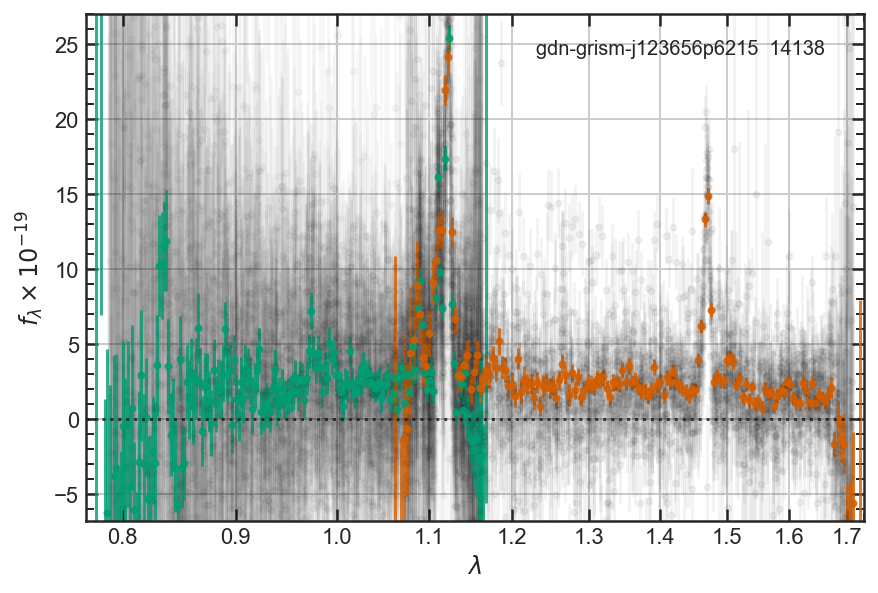

In [51]:
fig = mb.oned_figure()

In [57]:
tfit = mb.template_at_z(1.240109, templates=args['t1'])

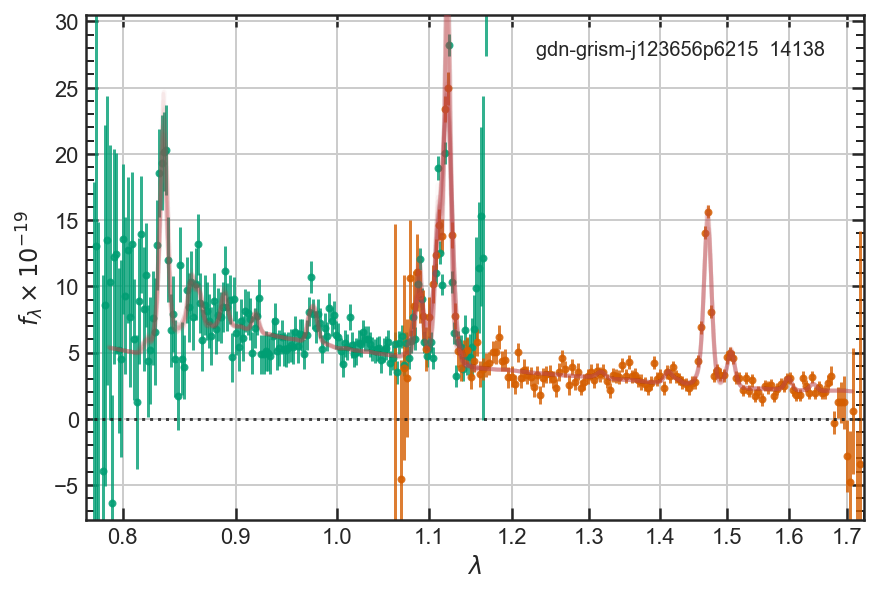

In [58]:
fig = mb.oned_figure(tfit=tfit, show_beams=False)

In [8]:
tfit['cfit']

OrderedDict([('bg 000', (-0.022565401329679092, 0.0017525518235186714)),
             ('bg 001', (-0.0065991350886605085, 0.0008748274211825775)),
             ('bg 002', (-0.008284433569989473, 0.0008265674944704371)),
             ('bg 003', (-0.018439085451666094, 0.0010704506872168246)),
             ('bg 004', (-0.010766802391161595, 0.0009088162221625084)),
             ('bg 005', (-0.005984945979469046, 0.0007317578995702894)),
             ('bg 006', (-0.012286255939698901, 0.0012597740354377159)),
             ('bg 007', (-0.006722884584504832, 0.0008118871269274276)),
             ('bg 008', (-0.0025620943328980017, 0.0006972896883356314)),
             ('bg 009', (-0.00247313063875209, 0.0007565885937031511)),
             ('bg 010', (-0.002387590215102098, 0.0007145743444662972)),
             ('bg 011', (-0.0028734092061151184, 0.000785425062208811)),
             ('bg 012', (-0.0017000037446208704, 0.0009586072844151456)),
             ('bg 013', (-0.010434749615147284, 0

In [9]:
tfit2 = mb.template_at_z(1.25, templates=args['t1'], fitter='bounded')

In [10]:
tfit2['cfit']

OrderedDict([('bg 000', (-0.02256741767906152, 0.001752629778451261)),
             ('bg 001', (-0.006597793168143364, 0.0008750041817148331)),
             ('bg 002', (-0.008285218870352853, 0.0008267305082286107)),
             ('bg 003', (-0.018439686602178627, 0.0010705909327550507)),
             ('bg 004', (-0.010768090728600615, 0.0009089381645224556)),
             ('bg 005', (-0.005983896786200913, 0.0007319379187564568)),
             ('bg 006', (-0.012285724965151219, 0.0012598744499722676)),
             ('bg 007', (-0.006721852598585607, 0.0008120402829652528)),
             ('bg 008', (-0.0025639924550227336, 0.0006974987740783594)),
             ('bg 009', (-0.00247284681080775, 0.0007567771790563318)),
             ('bg 010', (-0.0023885447608635825, 0.0007147697678627901)),
             ('bg 011', (-0.002872209148395606, 0.0007856283794593806)),
             ('bg 012', (-0.0016871186786081899, 0.0009595360225867379)),
             ('bg 013', (-0.010432300157964985, 0.0

The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       imagefindpars           mapreg              photeq       
     pixreplace           pixtopix            pixtosky        refimagefindpars  
     resetbits          runastrodriz          skytopix           tweakback      
      tweakreg           updatenpol


([<astropy.io.fits.hdu.image.PrimaryHDU object at 0x1a77373d68>, <astropy.io.fits.hdu.image.ImageHDU object at 0x1a76b9cdd8>, <astropy.io.fits.hdu.image.ImageHDU object at 0x1a76ba37b8>, <astropy.io.fits.hdu.image.ImageHDU object at 0x1a76ba3b38>, <astropy.io.fits.hdu.image.ImageHDU object at 0x1a75bcd470>, <astropy.io.fits.hdu.image.ImageHDU object at 0x1a76b9cda0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x1a77911128>, <astropy.io.fits.hdu.image.ImageHDU object at 0x1a777a1f28>, <astropy.io.fits.hdu.image.ImageHDU object at 0x1a7777d160>, <astropy.io.fits.hdu.image.ImageHDU object at 0x1a75affdd8>, <astropy.io.fits.hdu.image.ImageHDU object at 0x1a777297b8>, <astropy.io.fits.hdu.image.ImageHDU object at 0x1a76ba0320>, <astropy.io.fits.hdu.image.ImageHDU object at 0x1a77407898>, <astropy.io.fits.hdu.image.ImageHDU object at 0x1a77530f28>, <astropy.io.fits.hdu.image.ImageHDU object at 0x1a7786fe48>, <astropy.io.fits.hdu.image.ImageHDU object at 0x1a75bd5dd8>, <astropy.io.fits.hdu

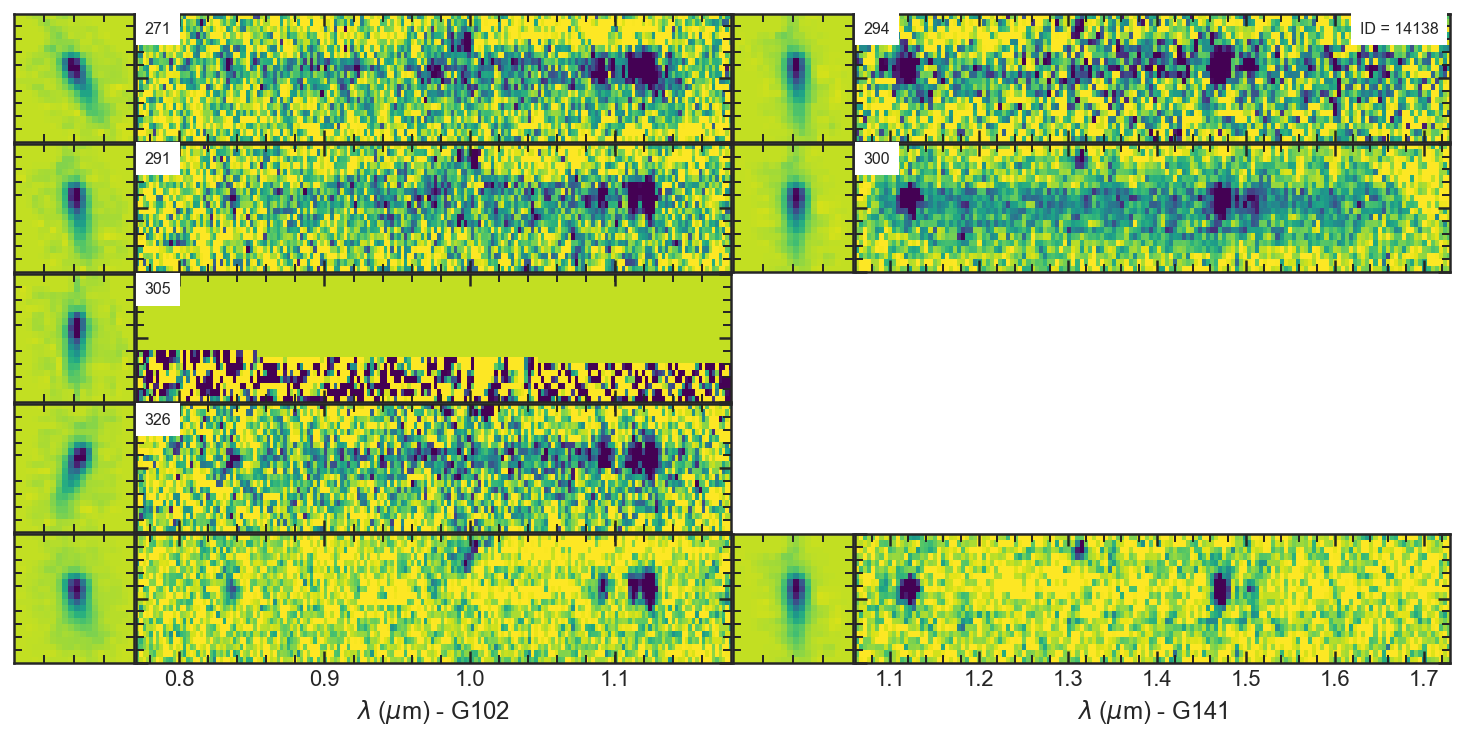

In [11]:
mb.drizzle_grisms_and_PAs(zfit=tfit)

In [12]:
print(tfit['chi2'])

101759.990672146


In [13]:
mb.DoF

94231

# Test making model

In [33]:
sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = 0, sfh = 4, tau = 0.1, dust_type = 2)
sp.params['dust1'] = 0

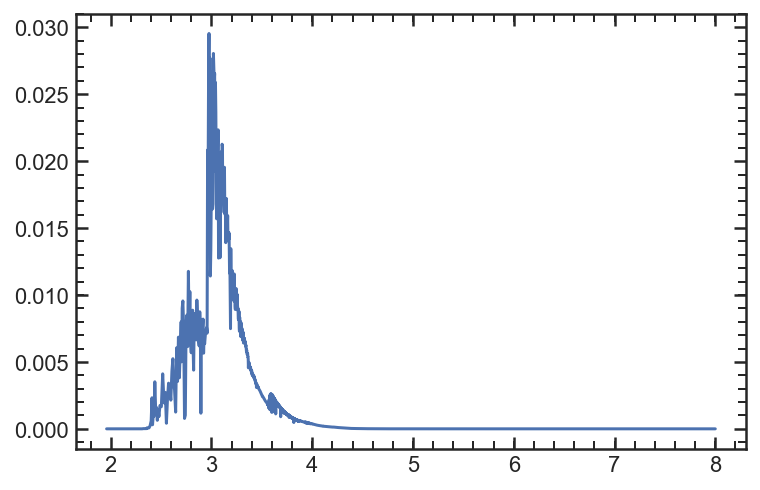

In [44]:
wave,flux = sp.get_spectrum(tage=0.25, peraa=True)
plt.plot(np.log10(wave),flux)

In [16]:
list(args['t1'].keys())

['fsps/fsps_QSF_12_v3_nolines_001.dat',
 'fsps/fsps_QSF_12_v3_nolines_002.dat',
 'fsps/fsps_QSF_12_v3_nolines_003.dat',
 'fsps/fsps_QSF_12_v3_nolines_004.dat',
 'fsps/fsps_QSF_12_v3_nolines_005.dat',
 'fsps/fsps_QSF_12_v3_nolines_006.dat',
 'fsps/fsps_QSF_12_v3_nolines_007.dat',
 'fsps/fsps_QSF_12_v3_nolines_008.dat',
 'fsps/fsps_QSF_12_v3_nolines_009.dat',
 'fsps/fsps_QSF_12_v3_nolines_010.dat',
 'fsps/fsps_QSF_12_v3_nolines_011.dat',
 'fsps/fsps_QSF_12_v3_nolines_012.dat',
 'alf_SSP.dat',
 'line PaB',
 'line HeI-1083',
 'line SIII',
 'line OII-7325',
 'line ArIII-7138',
 'line SII',
 'line Ha',
 'line OI-6302',
 'line HeI-5877',
 'line OIII',
 'line Hb',
 'line OIII-4363',
 'line Hg',
 'line Hd',
 'line H7',
 'line H8',
 'line H9',
 'line H10',
 'line NeIII-3867',
 'line OII',
 'line NeVI-3426',
 'line NeV-3346',
 'line MgII',
 'line CIV-1549',
 'line CIII-1908',
 'line OIII-1663',
 'line HeII-1640',
 'line NIII-1750',
 'line NIV-1487',
 'line NV-1240',
 'line Lya']

In [17]:
from grizli.utils import SpectrumTemplate

In [45]:
test_args = {'fsps_model' : SpectrumTemplate(wave,flux)}

entries = ['line SII','line Ha','line OI-6302','line HeI-5877',
           'line OIII','line Hb','line OIII-4363','line Hg','line Hd','line NeIII-3867','line OII']

for k in args['t1']:
#     if k[:4] == 'line':
    if k in entries:
        test_args[k] = args['t1'][k]

In [37]:
args['t1']

OrderedDict([('fsps/fsps_QSF_12_v3_nolines_001.dat',
              <grizli.utils.SpectrumTemplate at 0x1a74764b70>),
             ('fsps/fsps_QSF_12_v3_nolines_002.dat',
              <grizli.utils.SpectrumTemplate at 0x1a74764cf8>),
             ('fsps/fsps_QSF_12_v3_nolines_003.dat',
              <grizli.utils.SpectrumTemplate at 0x1a74764e80>),
             ('fsps/fsps_QSF_12_v3_nolines_004.dat',
              <grizli.utils.SpectrumTemplate at 0x1a74767048>),
             ('fsps/fsps_QSF_12_v3_nolines_005.dat',
              <grizli.utils.SpectrumTemplate at 0x1a747671d0>),
             ('fsps/fsps_QSF_12_v3_nolines_006.dat',
              <grizli.utils.SpectrumTemplate at 0x1a74767358>),
             ('fsps/fsps_QSF_12_v3_nolines_007.dat',
              <grizli.utils.SpectrumTemplate at 0x1a747674e0>),
             ('fsps/fsps_QSF_12_v3_nolines_008.dat',
              <grizli.utils.SpectrumTemplate at 0x1a74767668>),
             ('fsps/fsps_QSF_12_v3_nolines_009.dat',
           

In [46]:
test_args

{'fsps_model': <grizli.utils.SpectrumTemplate at 0x1a927ea550>,
 'line Ha': <grizli.utils.SpectrumTemplate at 0x1a752d1c50>,
 'line Hb': <grizli.utils.SpectrumTemplate at 0x1a752d82e8>,
 'line Hd': <grizli.utils.SpectrumTemplate at 0x1a752d87f0>,
 'line HeI-5877': <grizli.utils.SpectrumTemplate at 0x1a752d1f60>,
 'line Hg': <grizli.utils.SpectrumTemplate at 0x1a752d8630>,
 'line NeIII-3867': <grizli.utils.SpectrumTemplate at 0x1a762ba080>,
 'line OI-6302': <grizli.utils.SpectrumTemplate at 0x1a752d1dd8>,
 'line OII': <grizli.utils.SpectrumTemplate at 0x1a762ba208>,
 'line OIII': <grizli.utils.SpectrumTemplate at 0x1a752d8128>,
 'line OIII-4363': <grizli.utils.SpectrumTemplate at 0x1a752d8470>,
 'line SII': <grizli.utils.SpectrumTemplate at 0x1a752d1a90>}

In [37]:
%%timeit -n 4
mb.template_at_z(1.25, templates=test_args)

287 ms ± 30.1 ms per loop (mean ± std. dev. of 7 runs, 4 loops each)


In [38]:
%%timeit -n 4
mb.template_at_z(1.25, templates=test_args, fitter='bounded')

216 ms ± 12.1 ms per loop (mean ± std. dev. of 7 runs, 4 loops each)


In [39]:
%%timeit -n 4
mb.template_at_z(1.25, templates=test_args, fitter='lstsq')

208 ms ± 5.43 ms per loop (mean ± std. dev. of 7 runs, 4 loops each)


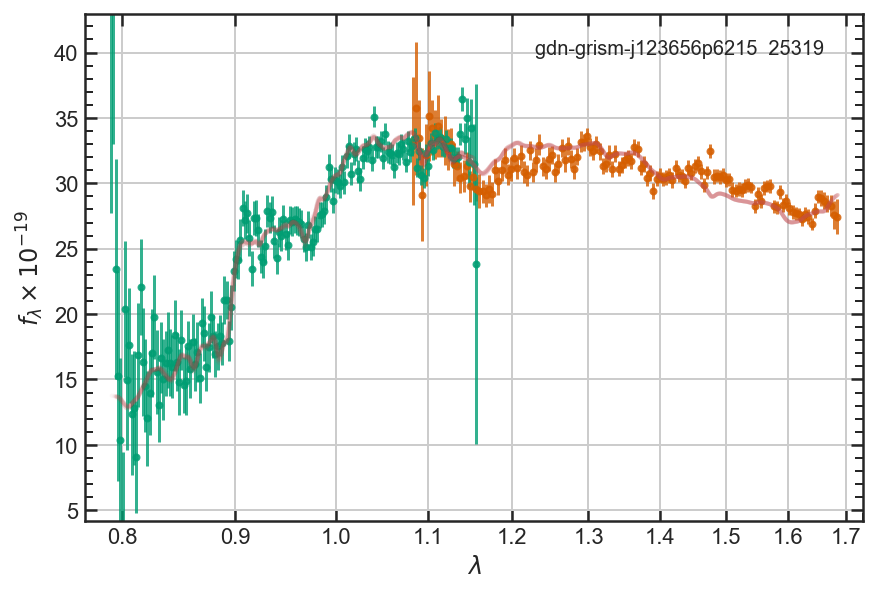

In [23]:
fig = mb.oned_figure(tfit=testfit, show_beams=False)

In [47]:
testfit['chi2'], tfit['chi2']

NameError: name 'testfit' is not defined

(3000, 5000)

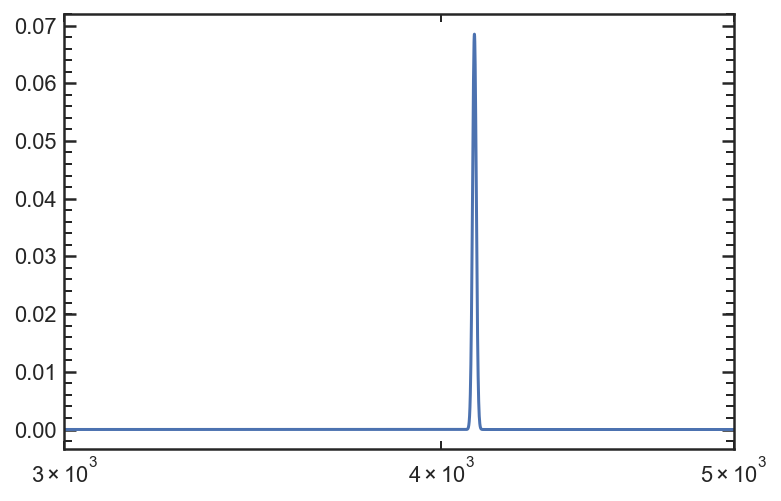

In [50]:
plt.plot(test_args['line Hd'].wave, test_args['line Hd'].flux)
plt.xscale('log')
plt.xlim(3000,5000)

In [114]:
testfit.keys()

odict_keys(['cont1d', 'line1d', 'cfit', 'coeffs', 'chi2', 'covar', 'z', 'templates'])

(8000, 17000)

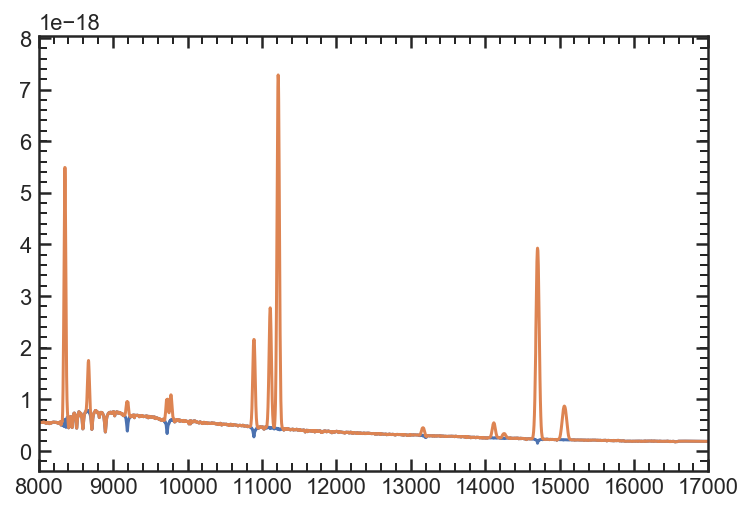

In [178]:
plt.plot(testfit['cont1d'].wave,testfit['cont1d'].flux)
plt.plot(testfit['line1d'].wave,testfit['line1d'].flux)

plt.xlim(8000, 17000)

# plt.xscale('log')

In [119]:
Gs = Gen_SF_spec('GND', 11839, 1.24, g102_lims=[8200, 11300], g141_lims=[11200, 16000],
        phot_errterm = 0.04, irac_err = 0.08) 

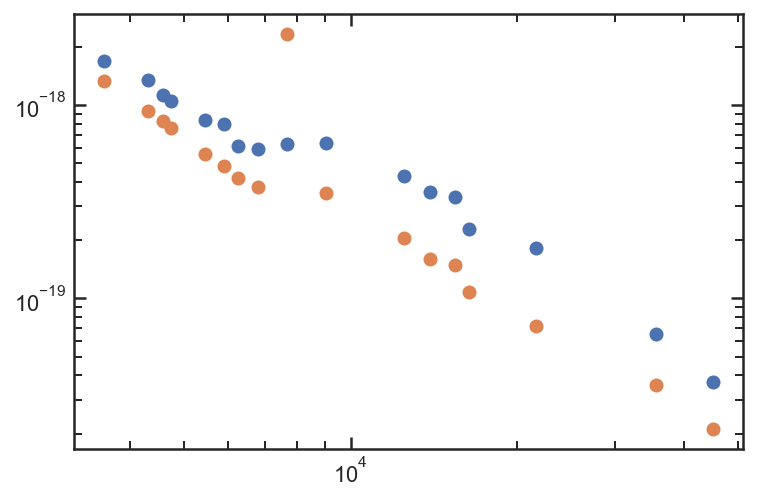

In [162]:
# Gs.Sim_phot_premade(testfit['cont1d'].wave,testfit['cont1d'].flux)
plt.plot(Gs.Pwv, Gs.Pflx,'o')
# plt.plot(Gs.Pwv, Gs.Pmfl,'o')

Gs.Sim_phot_premade(tfit['line1d'].wave,tfit['line1d'].flux)
plt.plot(Gs.Pwv, Gs.Pmfl,'o')
plt.xscale('log')
plt.yscale('log')

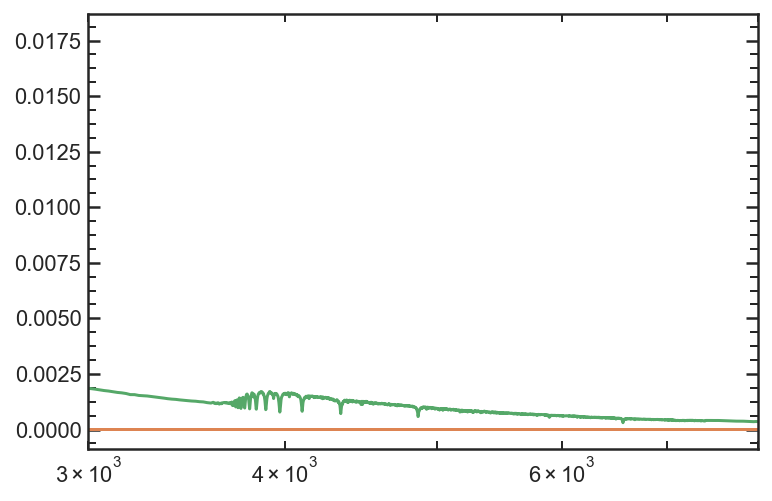

In [185]:
plt.plot(testfit['line1d'].wave / (1 + 1.24),testfit['line1d'].flux)
plt.plot(testfit['cont1d'].wave / (1 + 1.24),testfit['cont1d'].flux)

plt.plot(wave, flux)
plt.xlim(3000, 8000)
plt.xscale('log')

In [101]:
#!/home/vestrada78840/miniconda3/envs/astroconda/bin/python
from spec_id import *
import fsps
import numpy as np
from glob import glob
import pandas as pd
import os
import sys
hpath = os.environ['HOME'] + '/'
  
field = 'GND'
galaxy = 11839
specz = 1.24011 
logmass = 9.732068638965309
    
verbose=False
poolsize = 8

def Z_prior_mu(lmass):
    M = [9, 11.5]
    P = [-0.5813, 0.06818]
    iP = interp1d(M,P)
    return iP(lmass) 

onesig = (0.04 + 0.47)/2

mllim = np.log10(0.001 / 0.019)
mhlim = np.log10(0.031 / 0.019)

agelim = Oldest_galaxy(specz)

def Galfit_prior(u):
    m = 10**Gaussian_prior(u[0], [mllim, mhlim], Z_prior_mu(logmass), onesig)
    a = (agelim - 1)* u[1] + 1
    
    tsamp = np.array([u[2],u[3],u[4],u[5],u[6],u[7]])
    taus = stats.t.ppf( q = tsamp, loc = 0, scale = 0.3, df =2.)
    m1, m2, m3, m4, m5, m6 = logsfr_ratios_to_masses(logmass = 0, logsfr_ratios = taus, agebins = get_agebins(a, binnum = 6))
    
    lm = Gaussian_prior(u[8], [8.0, 12.5], 11, 0.75)
     
    d = 4*u[9]
    
#     bp1 = Gaussian_prior(u[10], [-0.1,0.1], 0, 0.05)
#     rp1 = Gaussian_prior(u[11], [-0.05,0.05], 0, 0.025)
    
#     ba = log_10_prior(u[12], [0.1,10])
#     bb = log_10_prior(u[13], [0.0001,1])
#     bl = log_10_prior(u[14], [0.01,1])
    
#     ra = log_10_prior(u[15], [0.1,10])
#     rb = log_10_prior(u[16], [0.0001,1])
#     rl = log_10_prior(u[17], [0.01,1])
   
    lwa = get_lwa_SF([m, a, m1, m2, m3, m4, m5, m6], get_agebins(a, binnum = 6),sp)[0]
    
    return [m, a, m1, m2, m3, m4, m5, m6, lm, d, lwa]
#     return [m, a, m1, m2, m3, m4, m5, m6, lm, d, bp1, rp1, ba, bb, bl, ra, rb, rl, lwa]

def Galfit_L(X):
    m, a, m1, m2, m3, m4, m5, m6, lm, d, lwa = X
#     m, a, m1, m2, m3, m4, m5, m6, lm, d, bp1, rp1, ba, bb, bl, ra, rb, rl, lwa = X
    
    sp.params['dust2'] = d
    sp.params['logzsol'] = np.log10(m)
    
    time, sfr, tmax = convert_sfh(get_agebins(a, binnum = 6), [m1, m2, m3, m4, m5, m6], maxage = a*1E9)

    sp.set_tabular_sfh(time,sfr) 
    
    wave, flux = sp.get_spectrum(tage = a, peraa = True)
#     Gmfl, Pmfl = Full_forward_model(Gs, wave, F_lam_per_M(flux,wave*(1 + specz), specz, 0, sp.stellar_mass)*10**lm, specz, 
#                                     wvs, flxs, errs, beams, trans)
    Pmfl = Gs.Sim_phot_mult(wave * (1 + specz), F_lam_per_M(flux,wave*(1 + specz), specz, 0, sp.stellar_mass)*10**lm)
#     Gmfl = Full_calibrate_2(Gmfl, [bp1, rp1], wvs, flxs, errs)

    test_args['fsps_model'] = SpectrumTemplate(wave, F_lam_per_M(flux,wave*(1 + specz), specz, 0, sp.stellar_mass)*10**lm)

    testfit = mb.template_at_z(specz, templates=test_args, fitter='bounded')

#     return Full_fit_2(Gs, Gmfl, Pmfl, [ba,ra], [bb,rb], [bl, rl], wvs, flxs, errs)

    return - (testfit['chi2'] + np.sum((((Gs.Pflx - Pmfl) / Gs.Perr)**2))) / 2
#########define fsps#########
sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = 0, sfh = 3, dust_type = 2)
sp.params['dust1'] = 0

###########gen spec##########
Gs = Gen_SF_spec(field, galaxy, 1, g102_lims=[8200, 11300], g141_lims=[11200, 16000],
        phot_errterm = 0.04, irac_err = 0.08) 

####generate grism items#####
wvs, flxs, errs, beams, trans = Gather_grism_data(Gs)

#######set up dynesty########
# sampler = dynesty.DynamicNestedSampler(Galfit_L, Galfit_prior, ndim = 19, nlive_points = 4000,
#                                          sample = 'rwalk', bound = 'multi',
#                                          pool=Pool(processes=8), queue_size=8)

# sampler.run_nested(wt_kwargs={'pfrac': 1.0}, dlogz_init=0.01, print_progress=True)

In [186]:
#!/home/vestrada78840/miniconda3/envs/astroconda/bin/python
from spec_id import *
import fsps
import numpy as np
from glob import glob
import pandas as pd
import os
import sys
hpath = os.environ['HOME'] + '/'
  
field = 'GND'
galaxy = 11839
specz = 1.24011 
logmass = 9.732068638965309
    
verbose=False
poolsize = 8

#########define fsps#########
sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = 0, sfh = 3, dust_type = 2)
sp.params['dust1'] = 0

###########gen spec##########
Gs = Gen_SF_spec(field, galaxy, 1, g102_lims=[8200, 11300], g141_lims=[11200, 16000],
        phot_errterm = 0.04, irac_err = 0.08) 

def Z_prior_mu(lmass):
    M = [9, 11.5]
    P = [-0.5813, 0.06818]
    iP = interp1d(M,P)
    return iP(lmass) 

onesig = (0.04 + 0.47)/2

mllim = np.log10(0.001 / 0.019)
mhlim = np.log10(0.031 / 0.019)

agelim = Oldest_galaxy(specz)

In [202]:
%%timeit

u = np.random.rand(10)
m = 10**Gaussian_prior(u[0], [mllim, mhlim], Z_prior_mu(logmass), onesig)
a = (agelim - 1)* u[1] + 1

tsamp = np.array([u[2],u[3],u[4],u[5],u[6],u[7]])
taus = stats.t.ppf( q = tsamp, loc = 0, scale = 0.3, df =2.)
m1, m2, m3, m4, m5, m6 = logsfr_ratios_to_masses(logmass = 0, logsfr_ratios = taus, agebins = get_agebins(a, binnum = 6))

d = 4*u[8]

lwa = get_lwa_SF([m, a, m1, m2, m3, m4, m5, m6], get_agebins(a, binnum = 6),sp)[0]

sp.params['dust2'] = d
sp.params['logzsol'] = np.log10(m)

time, sfr, tmax = convert_sfh(get_agebins(a, binnum = 6), [m1, m2, m3, m4, m5, m6], maxage = a*1E9)

sp.set_tabular_sfh(time,sfr) 

wave, flux = sp.get_spectrum(tage = a, peraa = True)

test_args['fsps_model'] = SpectrumTemplate(wave, flux)
testfit = mb.template_at_z(specz, templates=test_args, fitter='bounded')

Pmfl = Gs.Sim_phot_mult(testfit['line1d'].wave,testfit['line1d'].flux)

scl = Scale_model(Gs.Pflx, Gs.Perr, Pmfl)

chi2 = -(testfit['chi2'] + np.sum((((Gs.Pflx - Pmfl*scl) / Gs.Perr)**2))) / 2
# print(testfit['chi2'])
# print(np.sum((((Gs.Pflx - Pmfl*scl) / Gs.Perr)**2)))


700 ms ± 85.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [203]:
%%timeit

u = np.random.rand(9)
m = 10**Gaussian_prior(u[0], [mllim, mhlim], Z_prior_mu(logmass), onesig)
a = (agelim - 1)* u[1] + 1

tsamp = np.array([u[2],u[3],u[4],u[5],u[6],u[7]])
taus = stats.t.ppf( q = tsamp, loc = 0, scale = 0.3, df =2.)
m1, m2, m3, m4, m5, m6 = logsfr_ratios_to_masses(logmass = 0, logsfr_ratios = taus, agebins = get_agebins(a, binnum = 6))

d = 4*u[8]

# lwa = get_lwa_SF([m, a, m1, m2, m3, m4, m5, m6], get_agebins(a, binnum = 6),sp)[0]

sp.params['dust2'] = d
sp.params['logzsol'] = np.log10(m)

time, sfr, tmax = convert_sfh(get_agebins(a, binnum = 6), [m1, m2, m3, m4, m5, m6], maxage = a*1E9)

sp.set_tabular_sfh(time,sfr) 

wave, flux = sp.get_spectrum(tage = a, peraa = True)

test_args['fsps_model'] = SpectrumTemplate(wave, flux)
testfit = mb.template_at_z(specz, templates=test_args, fitter='bounded')

Pmfl = Gs.Sim_phot_mult(testfit['line1d'].wave,testfit['line1d'].flux)

scl = Scale_model(Gs.Pflx, Gs.Perr, Pmfl)

chi2=  -(testfit['chi2'] + np.sum((((Gs.Pflx - Pmfl*scl) / Gs.Perr)**2))) / 2
# print(testfit['chi2'])
# print(np.sum((((Gs.Pflx - Pmfl*scl) / Gs.Perr)**2)))


622 ms ± 24.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [32]:
dres = np.load('../data/out_dict/GND_11839_SFfit_p1.npy').item()

In [226]:
from dynesty.utils import quantile as _quantile
from scipy.ndimage import gaussian_filter as norm_kde

def Get_posterior(results, entry):
    sample = results.samples[:, entry]
    logwt = results.logwt
    logz = results.logz
    
    
    weight = np.exp(logwt - logz[-1])

    q = [0.5 - 0.5 * 0.999999426697, 0.5 + 0.5 * 0.999999426697]
    span = _quantile(sample.T, q, weights=weight)

    s = 0.02

    bins = int(round(10. / 0.02))
    n, b = np.histogram(sample, bins=bins, weights=weight,
                        range=np.sort(span))
    n = norm_kde(n, 10.)
    x0 = 0.5 * (b[1:] + b[:-1])
    y0 = n
    
    return x0, y0 / np.trapz(y0,x0)

def Get_lwaposterior(results, lwa):
    sample = lwa
    logwt = results.logwt
    logz = results.logz
    
    
    weight = np.exp(logwt - logz[-1])

    q = [0.5 - 0.5 * 0.999999426697, 0.5 + 0.5 * 0.999999426697]
    span = _quantile(sample.T, q, weights=weight)

    s = 0.02

    bins = int(round(10. / 0.02))
    n, b = np.histogram(sample, bins=bins, weights=weight,
                        range=np.sort(span))
    n = norm_kde(n, 10.)
    x0 = 0.5 * (b[1:] + b[:-1])
    y0 = n
    
    return x0, y0 / np.trapz(y0,x0)

In [218]:
dres.samples.shape

(28312, 19)

In [219]:
dres.samples[-1]

array([ 4.07859489e-01,  4.74736371e+00,  1.41334838e-02,  4.98900611e-02,
        2.30785074e-01,  5.37797363e-01,  1.31722117e-01,  3.56719008e-02,
        9.73112572e+00,  2.41210785e-01,  4.77986299e-03, -1.60807918e-02,
        1.15832760e+00,  8.85984286e-02,  1.71486790e-01,  9.51858508e-01,
        8.03556658e-02,  1.80675601e-02,  3.48414615e-01])

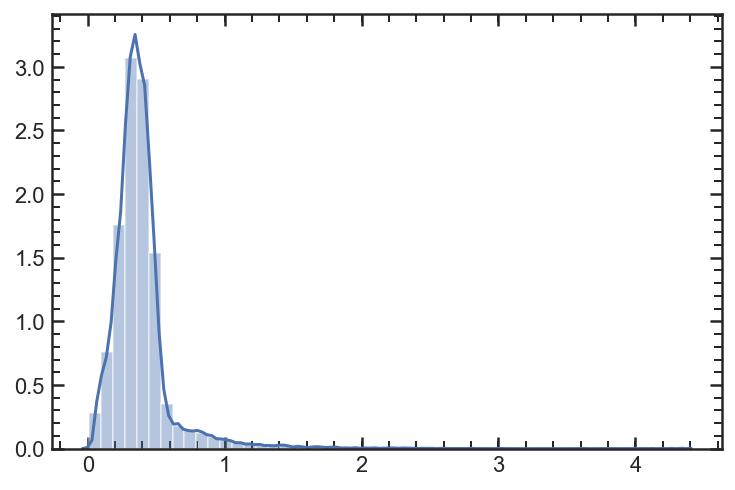

In [220]:
# x,Px = Get_posterior(dres, -1)

sea.distplot(dres.samples[:, -1])

In [224]:
sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = 0, sfh = 3, dust_type = 2)
sp.params['dust1'] = 0  

lwa = []

for i in range(len(dres.samples)):
    lwa.append(get_lwa_SF(dres.samples[i][:8], get_agebins(dres.samples[i][1], binnum = 6),sp)[0])


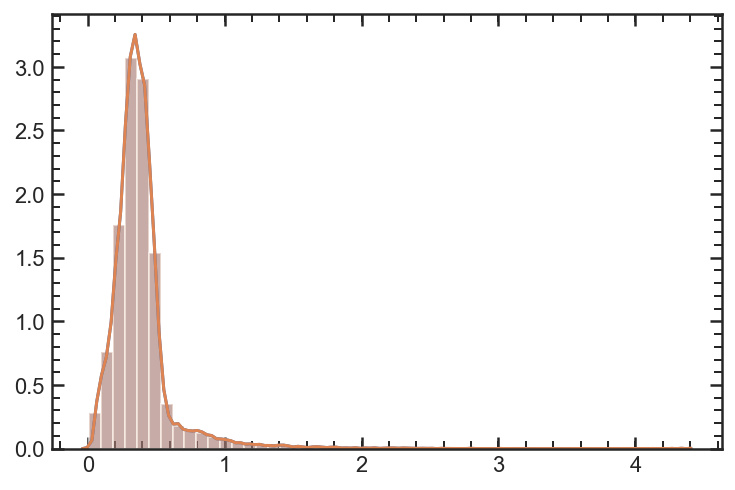

In [225]:
sea.distplot(dres.samples[:, -1])
sea.distplot(lwa)

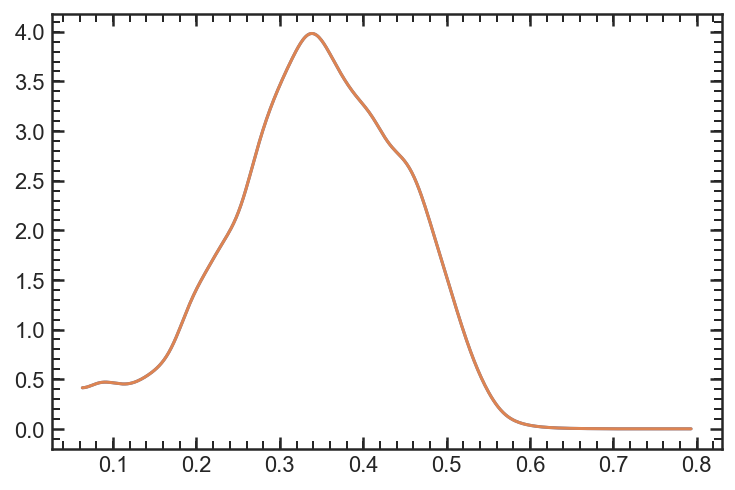

In [230]:
x,Px = Get_posterior(dres, -1)
plt.plot(x,Px)
x,Px = Get_lwaposterior(dres, np.array(lwa))

plt.plot(x,Px)

# sample to get lwa

In [38]:
sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = 0, sfh = 3, dust_type = 2)
sp.params['dust1'] = 0

from spec_tools import Gen_PPF
ppf_dict = {}
params = ['m','a', 'm1', 'm2', 'm3', 'm4', 'm5', 'm6']

for i in params:
    x,px = np.load('../Casey_data/posteriors/GND_11839_SFfit_p1_P{}.npy'.format(i))
    ppf_dict[i] = Gen_PPF(x,px)
    
lwa = []
idx=0
while idx < 5000:
    try:
        draw = np.zeros(len(params))
        for ii in range(len(draw)):
            draw[ii] = ppf_dict[params[ii]](np.random.rand(1))[0]
        lwa.append(get_lwa_SF(draw, get_agebins(draw[1], binnum = 6),sp)[0])
        idx +=1
    except:
        pass

x,Px = np.load('../Casey_data/posteriors/GND_11839_SFfit_p1_Plwa.npy')

plt.plot(x,Px)
sea.distplot(lwa)

In [41]:
# pos_path = '../Casey_data/posteriors/'
pos_path = '../data/posteriors/'

field = 'GND'
galaxy = 21156

#####################################
def Gen_PPF(x,px):
    return interp1d(np.cumsum(px) / np.cumsum(px).max(),x, bounds_error=False, fill_value=min(x))
############build priors#############
x,px = np.load(pos_path + '{0}_{1}_tabfit_Pm.npy'.format(field, galaxy))
print(x[0], x[-1])
Mp = Gen_PPF(x,px)

x,px = np.load(pos_path + '{0}_{1}_tabfit_Pa.npy'.format(field, galaxy))
print(x[0], x[-1])
Ap = Gen_PPF(x,px)

x,px = np.load(pos_path + '{0}_{1}_tabfit_Pd.npy'.format(field, galaxy))
print(x[0], x[-1])
Dp = Gen_PPF(x,px)

x,px = np.load(pos_path + '{0}_{1}_tabfit_Pm1.npy'.format(field, galaxy))
print(x[0], x[-1])
m1p = Gen_PPF(x,px)

x,px = np.load(pos_path + '{0}_{1}_tabfit_Pm2.npy'.format(field, galaxy))
print(x[0], x[-1])
m2p = Gen_PPF(x,px)

x,px = np.load(pos_path + '{0}_{1}_tabfit_Pm3.npy'.format(field, galaxy))
print(x[0], x[-1])
m3p = Gen_PPF(x,px)

x,px = np.load(pos_path + '{0}_{1}_tabfit_Pm4.npy'.format(field, galaxy))
print(x[0], x[-1])
m4p = Gen_PPF(x,px)

x,px = np.load(pos_path + '{0}_{1}_tabfit_Pm5.npy'.format(field, galaxy))
print(x[0], x[-1])
m5p = Gen_PPF(x,px)

x,px = np.load(pos_path + '{0}_{1}_tabfit_Pm6.npy'.format(field, galaxy))
print(x[0], x[-1])
m6p = Gen_PPF(x,px)

x,px = np.load(pos_path + '{0}_{1}_tabfit_Pm7.npy'.format(field, galaxy))
print(x[0], x[-1])
m7p = Gen_PPF(x,px)

x,px = np.load(pos_path + '{0}_{1}_tabfit_Pm8.npy'.format(field, galaxy))
print(x[0], x[-1])
m8p = Gen_PPF(x,px)

x,px = np.load(pos_path + '{0}_{1}_tabfit_Pm9.npy'.format(field, galaxy))
print(x[0], x[-1])
m9p = Gen_PPF(x,px)

x,px = np.load(pos_path + '{0}_{1}_tabfit_Pm10.npy'.format(field, galaxy))
print(x[0], x[-1])
m10p = Gen_PPF(x,px)

0.43990652455729107 1.5648875545498542
2.1674258813754603 4.95200503020194
0.1381568590673323 0.7871883221630143
2.587352984276097e-05 0.001271330190695009
5.665321109356766e-05 0.0018583881996819332
6.66810242906053e-05 0.002375510415271923
0.00011572970443198073 0.007720752702836817
2.412727024171138e-05 0.020004906794248822
0.00029152938905116304 0.05177572469278059
0.0004855394574262742 0.2959220807112235
0.014901077454219348 0.45290532259518756
0.02216254893989659 0.624461672358589
0.0009466777347234979 0.9457310569887745


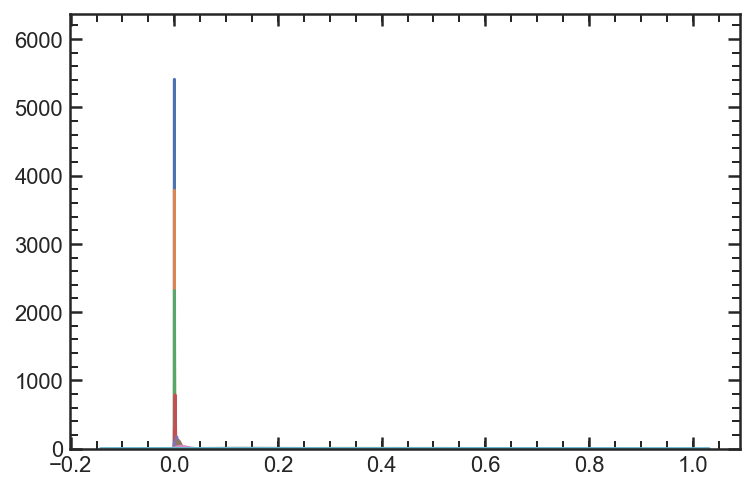

In [42]:
sea.distplot(m1p(np.random.rand(1000)))
sea.distplot(m2p(np.random.rand(1000)))
sea.distplot(m3p(np.random.rand(1000)))
sea.distplot(m4p(np.random.rand(1000)))
sea.distplot(m5p(np.random.rand(1000)))
sea.distplot(m6p(np.random.rand(1000)))
sea.distplot(m7p(np.random.rand(1000)))
sea.distplot(m8p(np.random.rand(1000)))
sea.distplot(m9p(np.random.rand(1000)))
sea.distplot(m10p(np.random.rand(1000)))

# compare sf sample

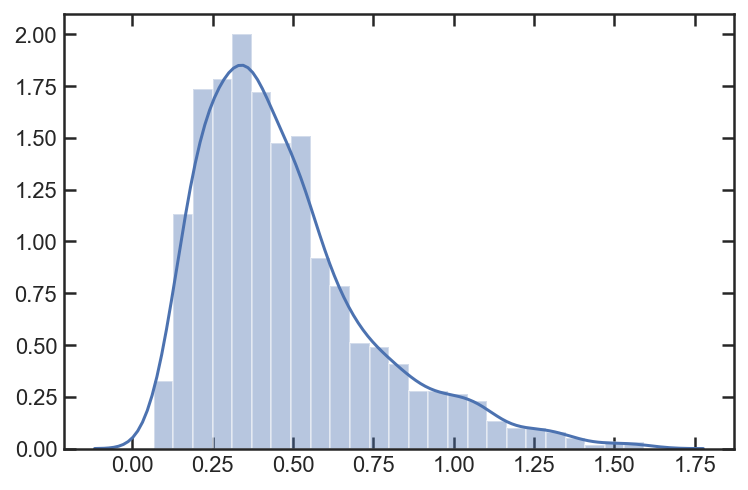

In [41]:
def Z_prior_mu(lmass):
    M = [9, 11.5]
    P = [-0.5813, 0.06818]
    iP = interp1d(M,P)
    return iP(lmass) 

onesig = (0.04 + 0.47)/2
mllim = np.log10(0.001 / 0.019)
mhlim = np.log10(0.031 / 0.019)

sea.distplot(10**Gaussian_prior(np.random.rand(1000), [mllim, mhlim], Z_prior_mu(9.732068638965309), onesig))

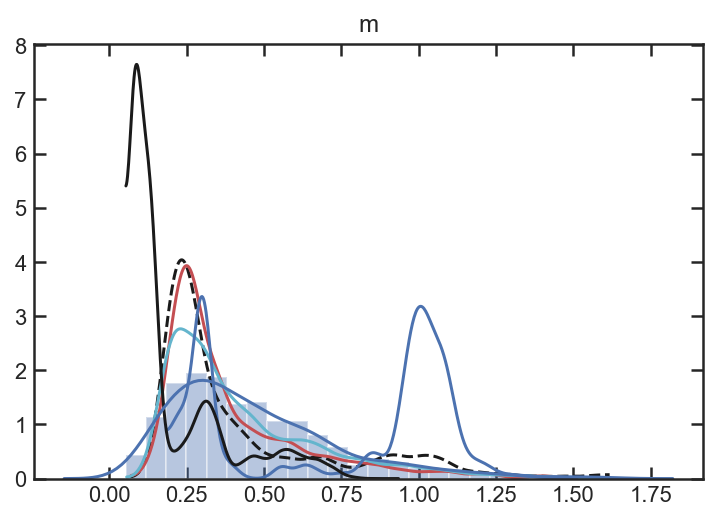

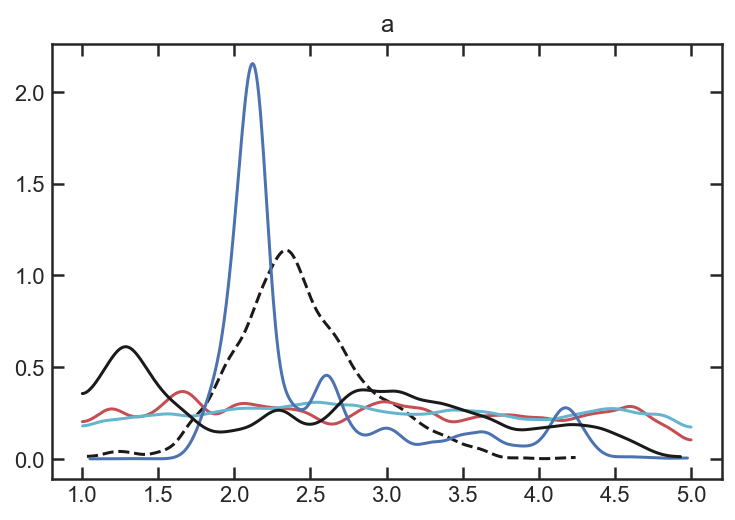

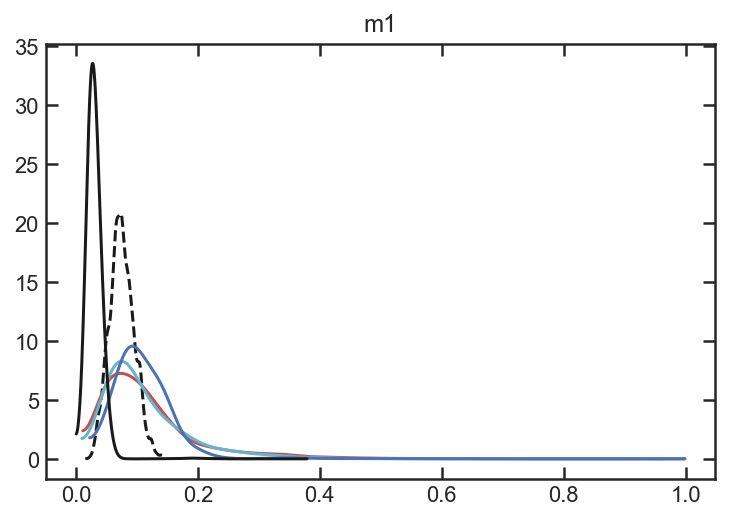

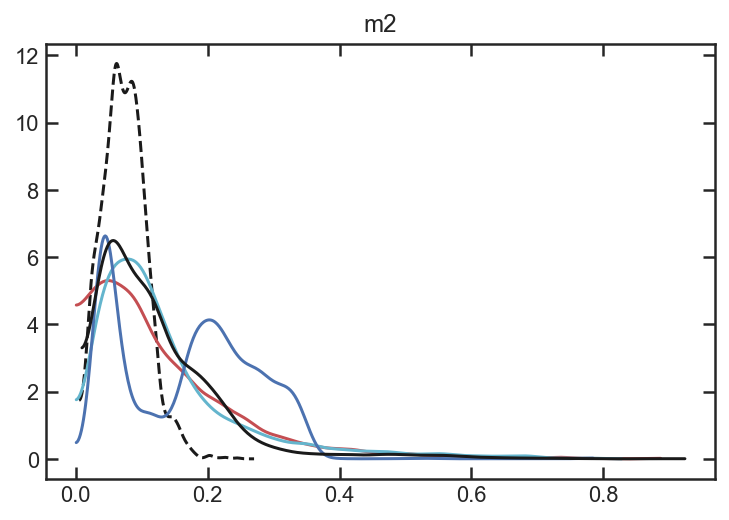

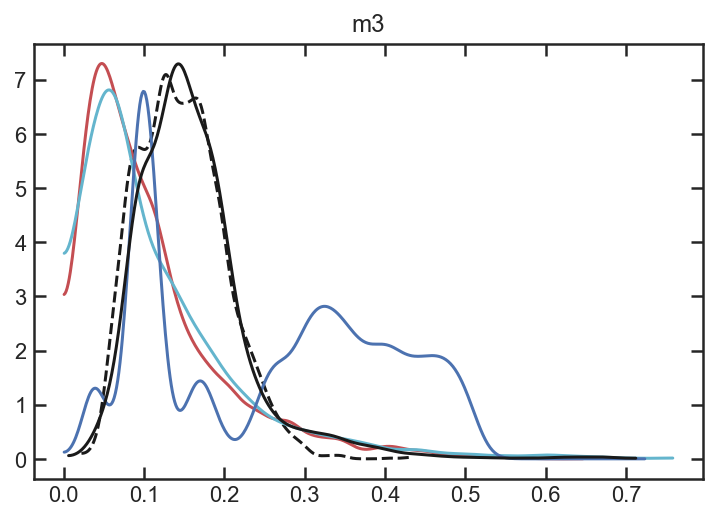

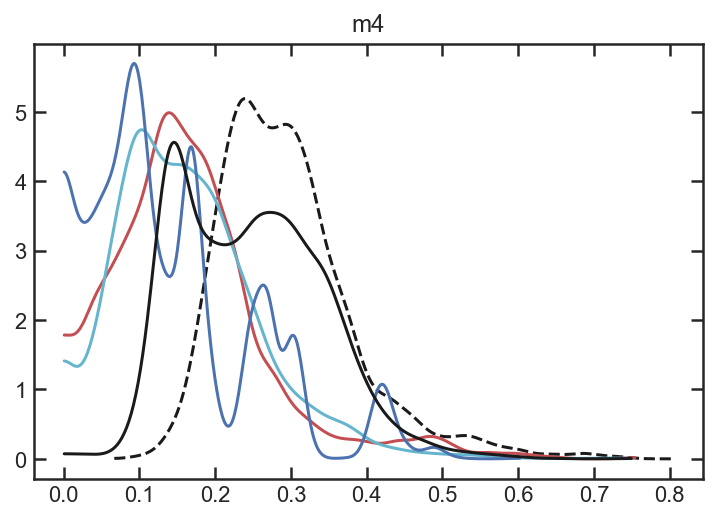

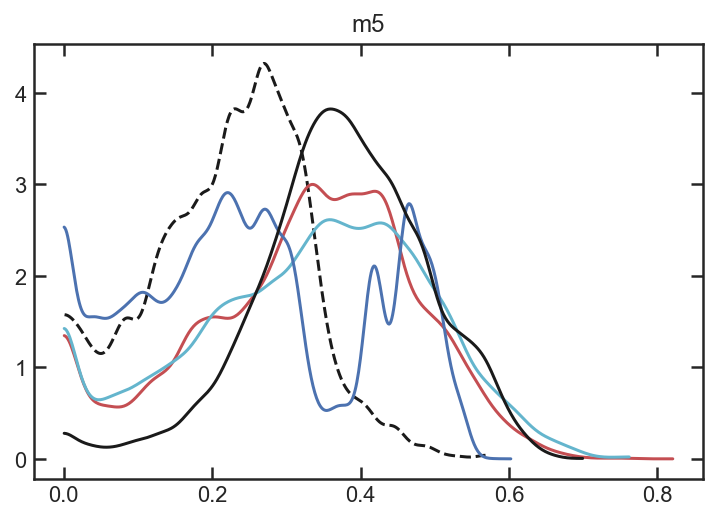

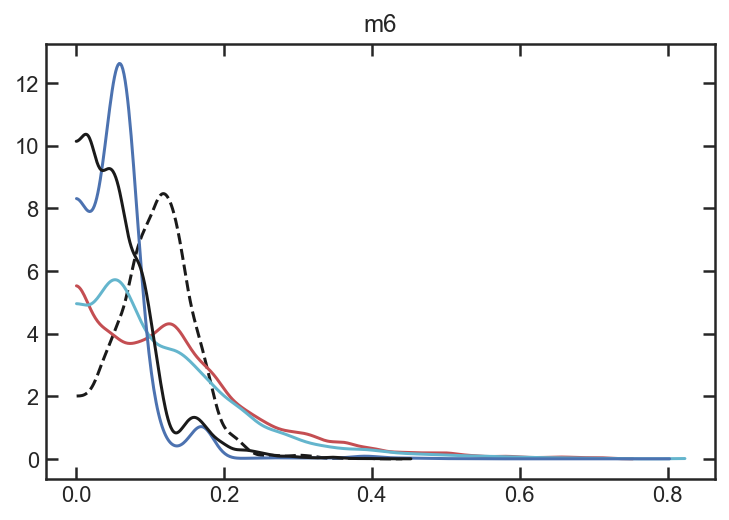

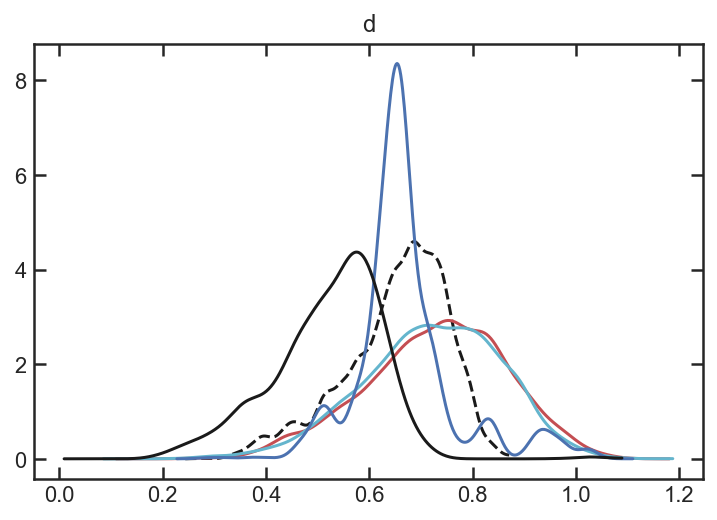

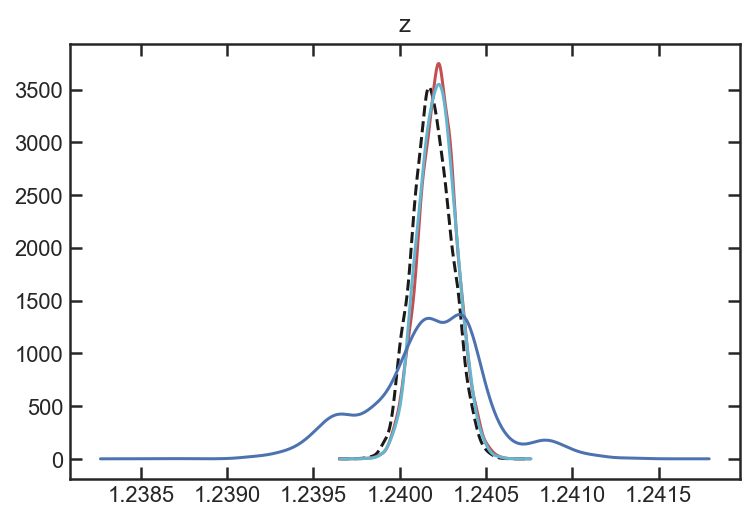

In [42]:
params = ['m', 'a', 'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'd', 'z']
for i in range(len(params)):
    plt.figure()
    plt.title(params[i])
    x,px = np.load('../data/posteriors/GND_11839_SFMfit_sp_P{0}.npy'.format(params[i]))
    plt.plot(x,px,'k--')
    
    x,px = np.load('../data/posteriors/GND_11839_SFMfit_np_P{0}.npy'.format(params[i]))
    plt.plot(x,px,'r')
    
    x,px = np.load('../data/posteriors/GND_11839_SFMfit_fp_P{0}.npy'.format(params[i]))
    plt.plot(x,px,'c')
    
    x,px = np.load('../data/posteriors/GND_11839_SFMfit_P{0}.npy'.format(params[i]))
    plt.plot(x,px,'b')
    
    if params[i] != 'z':
        y,py = np.load('../Casey_data/posteriors/GND_11839_SFfit_P{0}.npy'.format(params[i]))
        plt.plot(y,py,'k') 
        
    if params[i] == 'm':
        sea.distplot(10**Gaussian_prior(np.random.rand(1000), [mllim, mhlim], Z_prior_mu(9.732068638965309), onesig))


In [64]:
bfm, bfa, bfm1, bfm2, bfm3, bfm4, bfm5, bfm6, bfd, bfz, bflogz = np.load('../data/posteriors/GND_11839_SFMfit_sp_bfit.npy')

In [65]:
sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = 0, sfh = 3, dust_type = 2)
sp.params['dust1'] = 0

In [66]:
mb = multifit.MultiBeam('../data/multifit_data/gdn-grism-j123656p6215_14138.beams.fits',**args)

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3510: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3553: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3558: RuntimeWarning: invalid value encountered in sqrt
  contam_mask = ((self.contam*np.sqrt(self.ivar) > contam_sn_mask[0]) &
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3559: RuntimeWarning: invalid value encountered in sqrt
  (self.model*np.

1 ib3706b2q_flt.fits G141
2 ib3706b6q_flt.fits G141
3 ib3706biq_flt.fits G141
4 ib3706bpq_flt.fits G141
5 ib3707caq_flt.fits G141
6 ib3707ceq_flt.fits G141
7 ib3707cqq_flt.fits G141
8 ib3707cuq_flt.fits G141
9 ib3746tuq_flt.fits G141
10 ib3746ujq_flt.fits G141
11 ib3746urq_flt.fits G141
12 ib3746uxq_flt.fits G141
13 ib3747a5q_flt.fits G141
14 ib3747z0q_flt.fits G141
15 ib3747z5q_flt.fits G141
16 ib3747zyq_flt.fits G141
17 icat06gqq_flt.fits G102
18 icat07bxq_flt.fits G102
19 icat07c2q_flt.fits G102
20 icat07c9q_flt.fits G102
21 icat07ceq_flt.fits G102
22 icxt36jmq_flt.fits G102
23 icxt36jnq_flt.fits G102
24 icxt36jqq_flt.fits G102
25 icxt36jsq_flt.fits G102
26 icxt37laq_flt.fits G102
27 icxt37lbq_flt.fits G102
28 icxt37leq_flt.fits G102
29 icxt37lgq_flt.fits G102
30 icxt38p6q_flt.fits G102
31 icxt38p7q_flt.fits G102
32 icxt38paq_flt.fits G102
33 icxt38pcq_flt.fits G102
34 icxt39eoq_flt.fits G102
35 icxt39epq_flt.fits G102
36 icxt39esq_flt.fits G102
37 icxt39euq_flt.fits G102
38 icxt40n

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1433: RuntimeWarning: divide by zero encountered in true_divide
  beam.ivarf = 1./(1/beam.ivarf + (sys_err*beam.scif)**2)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1573: RuntimeWarning: invalid value encountered in sqrt
  self.sivarf = np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1578: RuntimeWarning: invalid value encountered in sqrt
  self.weightf = np.exp(-(self.fcontam*np.abs(self.contamf)*np.sqrt(self.ivarf)))


In [67]:
Gs = Gen_SF_spec('GND', 11839, bfz, g102_lims=[8200, 11300], g141_lims=[11200, 16000],
        phot_errterm = 0.04, irac_err = 0.08) 

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:557: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3510: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


In [68]:
def spec_construct(g102_fit,g141_fit, z, wave0 = 4000, ):
    flat = np.ones_like(g141_fit['cont1d'].wave)
    slope = flat*(g141_fit['cont1d'].wave/(1+z)-wave0)/wave0
    tilt = flat * g141_fit['cfit']['fsps_model'][0]+slope * g141_fit['cfit']['fsps_model_slope'][0]
    untilted_continuum = g141_fit['cont1d'].flux / tilt

    line_g141 = (g141_fit['line1d'].flux - g141_fit['cont1d'].flux)/g141_fit['cont1d'].flux
    untilted_line_g141 = untilted_continuum*(1+line_g141)


    flat = np.ones_like(g102_fit['cont1d'].wave)
    slope = flat*(g102_fit['cont1d'].wave/(1+z)-wave0)/wave0
    tilt = flat * g102_fit['cfit']['fsps_model'][0]+slope * g102_fit['cfit']['fsps_model_slope'][0]
    untilted_continuum = g102_fit['cont1d'].flux / tilt

    line_g102 = (g102_fit['line1d'].flux - g102_fit['cont1d'].flux)/g102_fit['cont1d'].flux
    untilted_line_g102 = untilted_continuum*(1+line_g102)

    FL = np.append(untilted_line_g102[g102_fit['cont1d'].wave <= 12000],untilted_line_g141[g102_fit['cont1d'].wave > 12000])
    return g102_fit['cont1d'].wave, FL

In [69]:
grism_beams = {}
for g in mb.PA:
    grism_beams[g.lower()] = []
    for pa in mb.PA[g]:
        for i in mb.PA[g][pa]:
            grism_beams[g.lower()].append(mb.beams[i])
            
mb_g102 = multifit.MultiBeam(grism_beams['g102'], fcontam=mb.fcontam, 
                             min_sens=mb.min_sens, min_mask=mb.min_mask, 
                             group_name=mb.group_name+'-g102')
# bug, will be fixed ~today to not have to do this in the future
for b in mb_g102.beams:
    if hasattr(b, 'xp'):
        delattr(b, 'xp')
mb_g102.initialize_masked_arrays()

mb_g141 = multifit.MultiBeam(grism_beams['g141'], fcontam=mb.fcontam, 
                             min_sens=mb.min_sens, min_mask=mb.min_mask, 
                             group_name=mb.group_name+'-g141')
# bug, will be fixed ~today to not have to do this in the future
for b in mb_g141.beams:
    if hasattr(b, 'xp'):
        delattr(b, 'xp')
mb_g141.initialize_masked_arrays()
wave0 = 4000

tilt_temps = {}

entries = ['line SII','line Ha','line OI-6302','line HeI-5877',
           'line OIII','line Hb','line OIII-4363','line Hg','line Hd','line NeIII-3867','line OII']

for k in args['t1']:
    if k in entries:
        tilt_temps[k] = args['t1'][k]

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1433: RuntimeWarning: divide by zero encountered in true_divide
  beam.ivarf = 1./(1/beam.ivarf + (sys_err*beam.scif)**2)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1573: RuntimeWarning: invalid value encountered in sqrt
  self.sivarf = np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1578: RuntimeWarning: invalid value encountered in sqrt
  self.weightf = np.exp(-(self.fcontam*np.abs(self.contamf)*np.sqrt(self.ivarf)))
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3510: RuntimeWarning: divide by zero encountered in true_divide
  s

In [70]:

sp.params['dust2'] = bfd
sp.params['logzsol'] = np.log10(bfm)

time, sfr, tmax = convert_sfh(get_agebins(bfa, binnum = 6), [bfm1, bfm2, bfm3, bfm4, bfm5, bfm6], maxage = bfa*1E9)

sp.set_tabular_sfh(time,sfr) 

wave, flux = sp.get_spectrum(tage = bfa, peraa = True)

tilt_temps['fsps_model_slope'] = SpectrumTemplate(wave=wave, flux=flux*(wave-wave0)/wave0)
tilt_temps['fsps_model'] = SpectrumTemplate(wave, flux)

g102_fit = mb_g102.template_at_z(bfz, templates=tilt_temps, fitter='lstsq')
g141_fit = mb_g141.template_at_z(bfz, templates=tilt_temps, fitter='lstsq')

wv_obs, flx = spec_construct(g102_fit,g141_fit,bfz)

Pmfl = Gs.Sim_phot_mult(wv_obs, flx)

scl = Scale_model(Gs.Pflx, Gs.Perr, Pmfl)

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


In [79]:
# y = fig.get_ydata()
ax = fig.add_subplot(111)

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [81]:
ax.draw()

TypeError: draw_wrapper() missing 1 required positional argument: 'renderer'

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:607: RuntimeWarning: invalid value encountered in true_divide
  opt_flux = num.sum(axis=0)/den.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:608: RuntimeWarning: divide by zero encountered in true_divide
  opt_var = 1./den.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/fitting.py:2882: RuntimeWarning: invalid value encountered in greater
  clip &= (er > 0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/fitting.py:2914: RuntimeWarning: invalid value encountered in multiply
  ymin = np.minimum(ymin, np.percentile((flm-er*0.)[clip],
/Users/vestrada/miniconda3

(-1, 40)

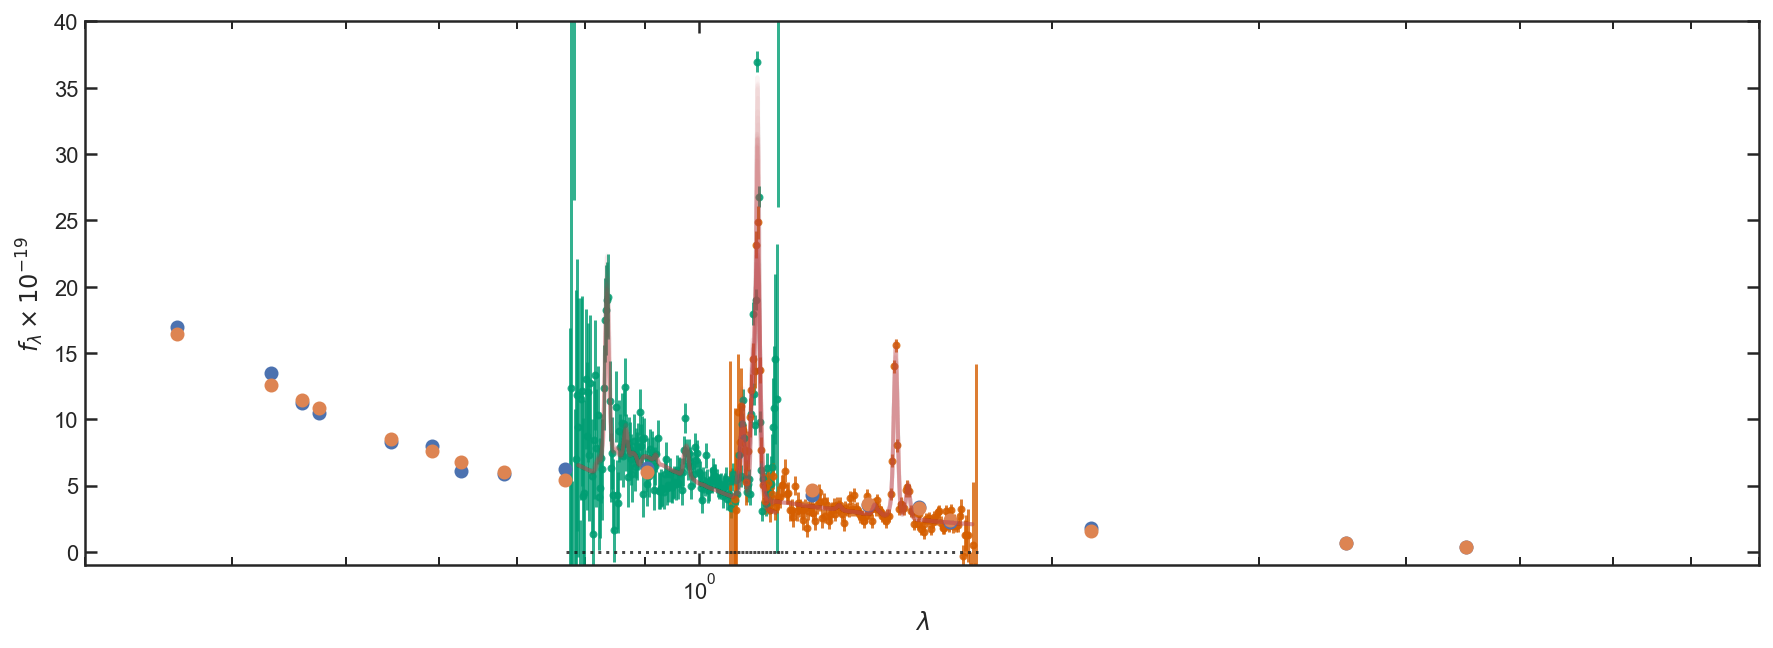

In [71]:
fig = plt.figure(figsize=[15,5])
ax1 = fig.add_subplot(111)

mb_g102.oned_figure(tfit=g102_fit, show_beams=False, axc=ax1)

mb_g141.oned_figure(tfit=g141_fit, show_beams=False, axc=ax1)

ax1.plot(Gs.Pwv / 1E4, Gs.Pflx*1E19,'o')

ax1.plot(Gs.Pwv / 1E4, scl*Pmfl*1E19,'o')
ax1.set_xscale('log')

ax1.set_xlim(.3,8)
ax1.set_ylim(-1,40)
# ax1.set_xticks([0.8,1,1.2,1.4,1.6])
# ax1.set_xticklabels([0.8,1,1.2,1.4,1.6])

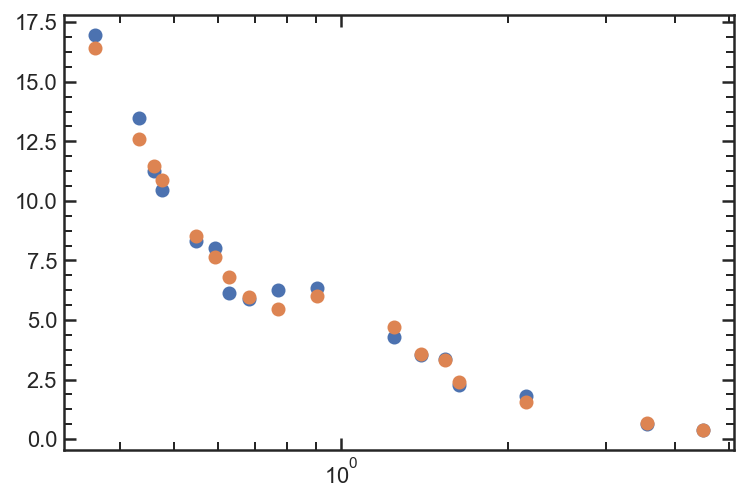

In [109]:
ax1=plt.subplot()
ax1.plot(Gs.Pwv / 1E4, Gs.Pflx*1E19,'o')

ax1.plot(Gs.Pwv / 1E4, scl*Pmfl*1E19,'o')
ax1.set_xscale('log')

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


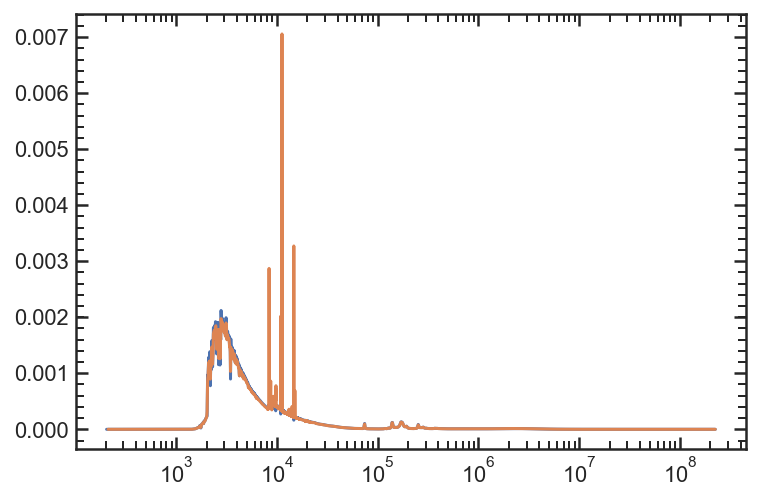

In [76]:
iflux = interp1d(wave*(1+bfz), flux)(wv_obs[flx**2 > 0])

plt.plot(wave*(1+bfz), flux)
plt.plot(wv_obs, flx * (iflux[50] / flx[50]))
plt.xscale('log')

In [75]:
xscl

1.1393675931386458

# compare quiescent

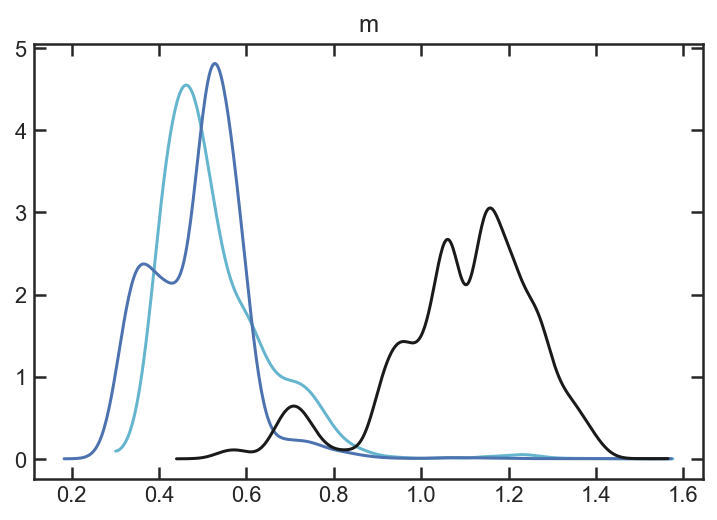

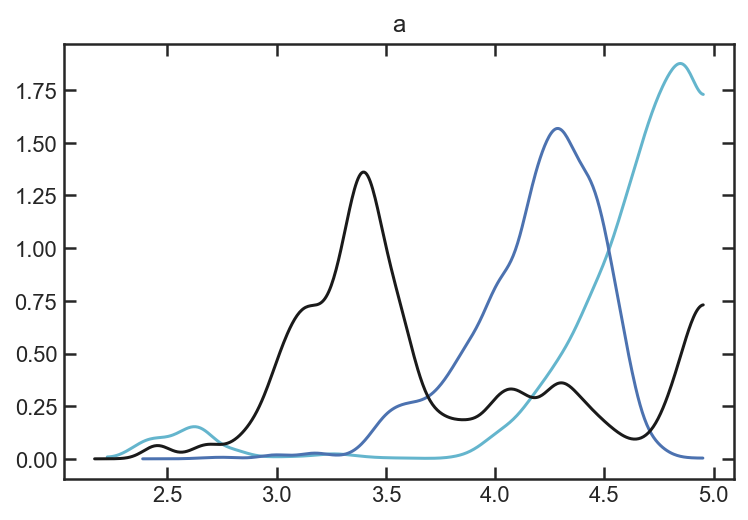

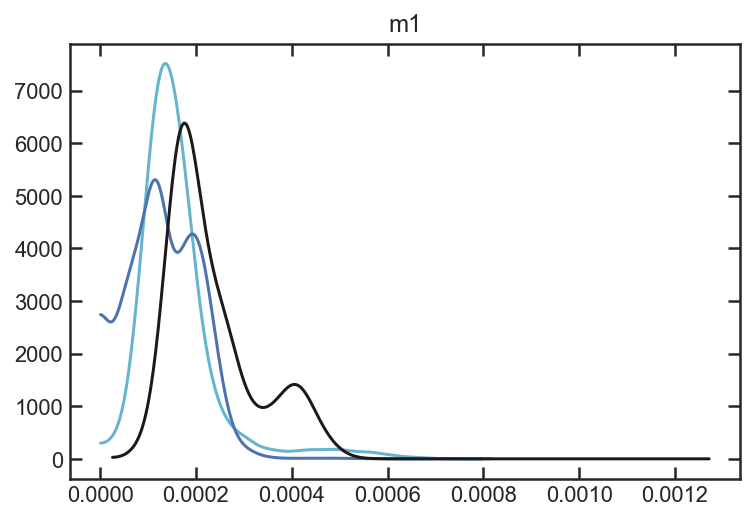

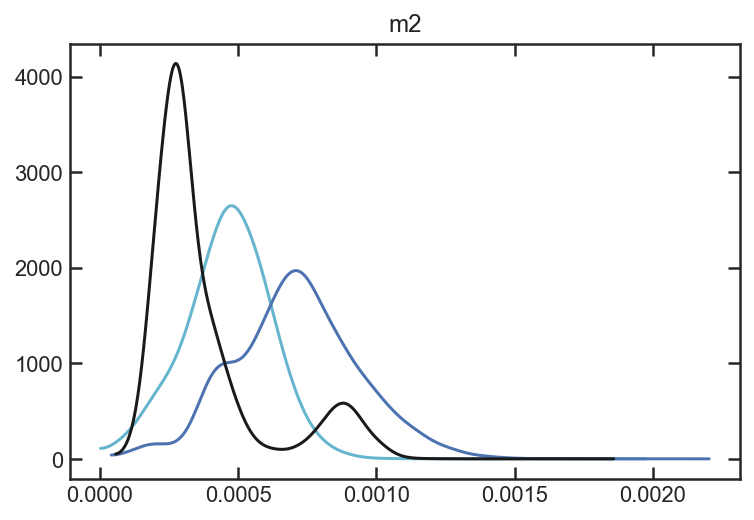

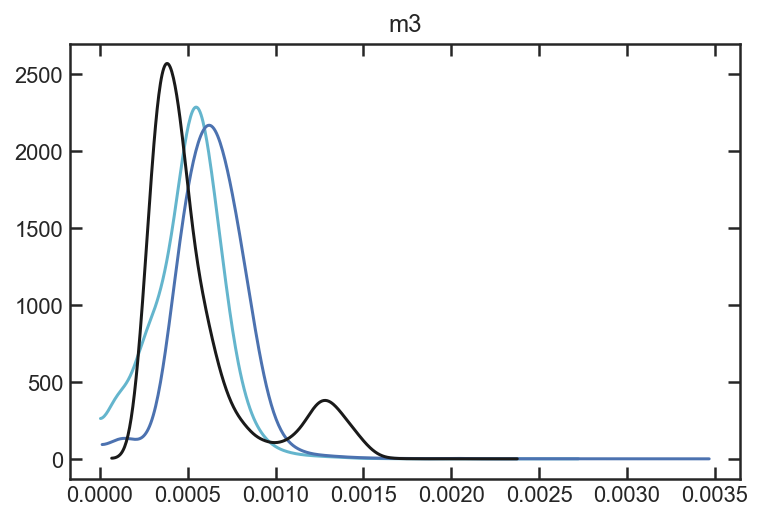

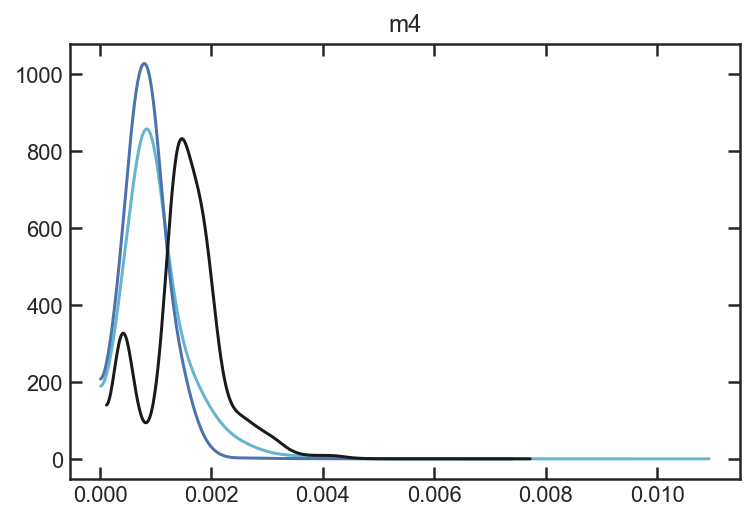

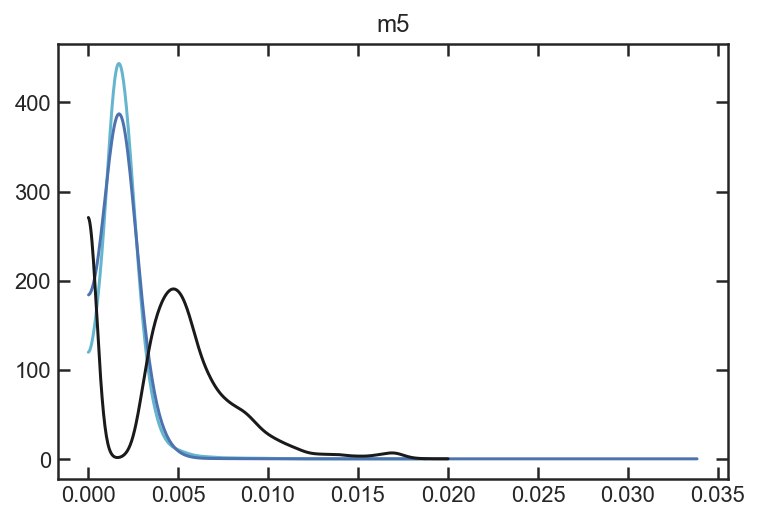

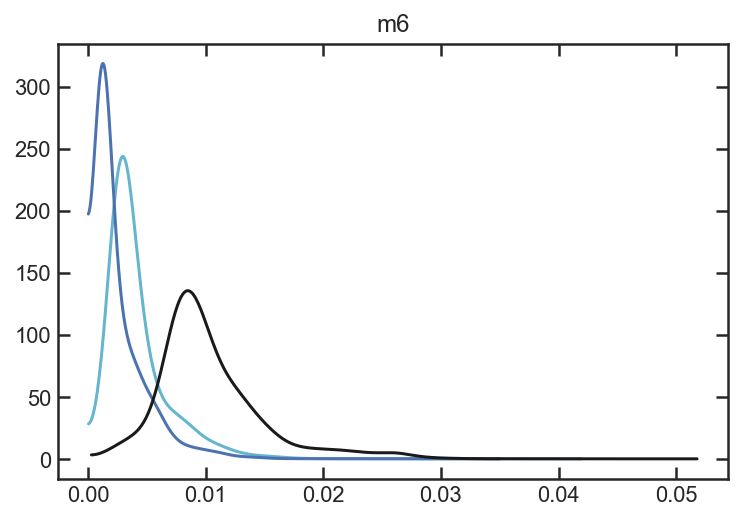

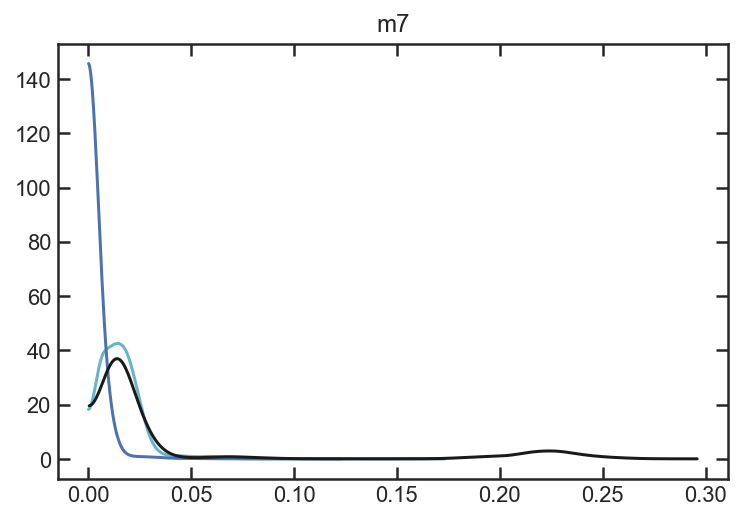

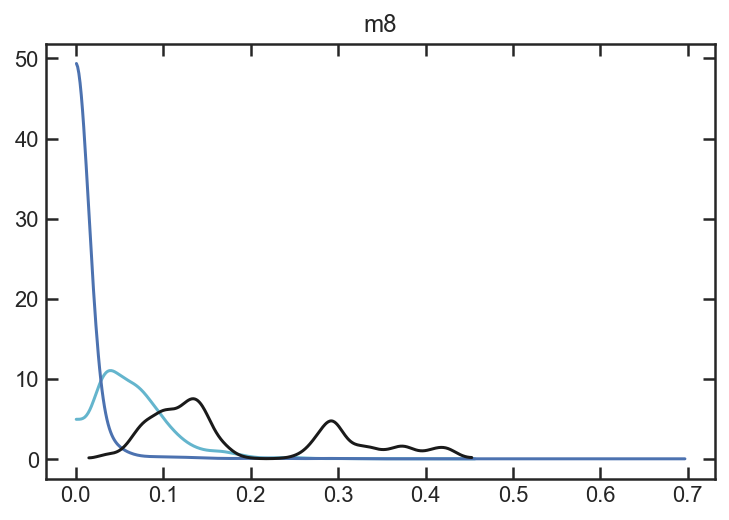

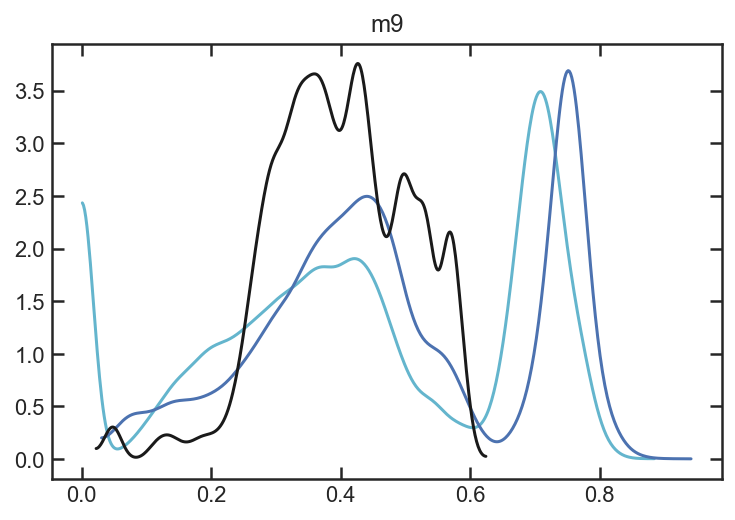

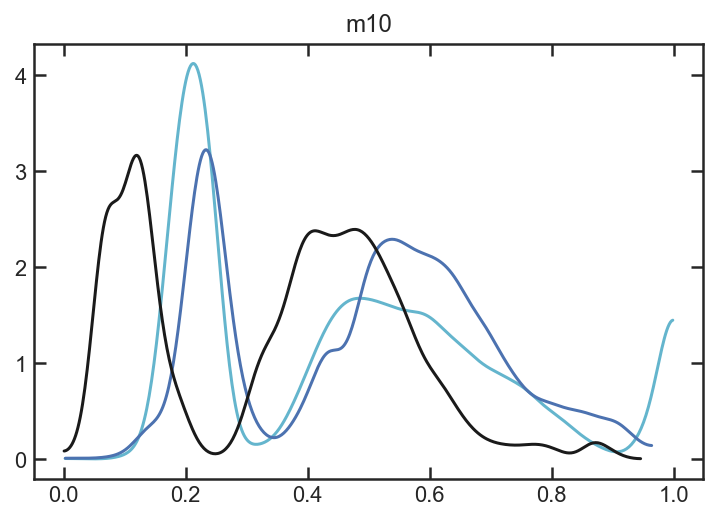

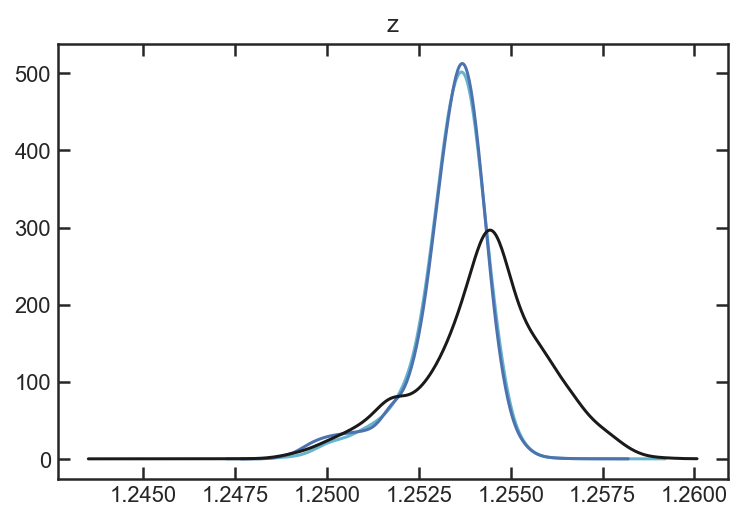

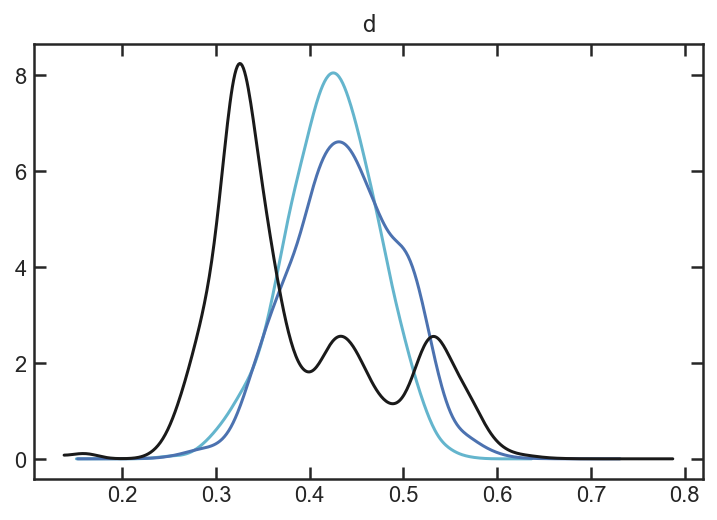

In [47]:
params = ['m', 'a', 'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10','z', 'd']
for i in range(len(params)):
    plt.figure()
    plt.title(params[i])
#     x,px = np.load('../data/posteriors/GND_21156_tabMfit_sp_P{0}.npy'.format(params[i]))
#     plt.plot(x,px, 'k--')

#     x,px = np.load('../data/posteriors/GND_21156_tabMfit_np_P{0}.npy'.format(params[i]))
#     plt.plot(x,px, 'r')
    
    x,px = np.load('../data/posteriors/GND_21156_tabMfit_fp_P{0}.npy'.format(params[i]))
    plt.plot(x,px, 'c')
    
    x,px = np.load('../data/posteriors/GND_21156_tabMfit_nerr_P{0}.npy'.format(params[i]))
    plt.plot(x,px, 'b')
    
    y,py = np.load('../data/posteriors/GND_21156_tabfit_P{0}.npy'.format(params[i]))
    plt.plot(y,py, 'k')    


In [6]:
sbfm, sbfa, sbfm1, sbfm2, sbfm3, sbfm4, sbfm5, sbfm6, sbfm7, sbfm8, sbfm9, sbfm10, sbfz, sbfd, sbflogz = np.load(
    '../data/posteriors/GND_21156_tabMfit_sp_bfit.npy')

nbfm, nbfa, nbfm1, nbfm2, nbfm3, nbfm4, nbfm5, nbfm6, nbfm7, nbfm8, nbfm9, nbfm10, nbfz, nbfd, nbflogz = np.load(
    '../data/posteriors/GND_21156_tabMfit_np_bfit.npy')

fbfm, fbfa, fbfm1, fbfm2, fbfm3, fbfm4, fbfm5, fbfm6, fbfm7, fbfm8, fbfm9, fbfm10, fbfz, fbfd, fbflogz = np.load(
    '../data/posteriors/GND_21156_tabMfit_fp_bfit.npy')

bfm, bfa, bfm1, bfm2, bfm3, bfm4, bfm5, bfm6, bfm7, bfm8, bfm9, bfm10, bfz, bfd, bfba, bfra, bflogz = np.load(
    '../data/posteriors/GND_21156_tabMfit_bfit.npy')

In [7]:
sbflogz, nbflogz, fbflogz, bflogz

(-32548.537885379432,
 -32558.02590145337,
 -32557.080600578884,
 -3262.7463146012265)

In [8]:
bfba, bfra

(9.99999853070052, 9.99807587888515)

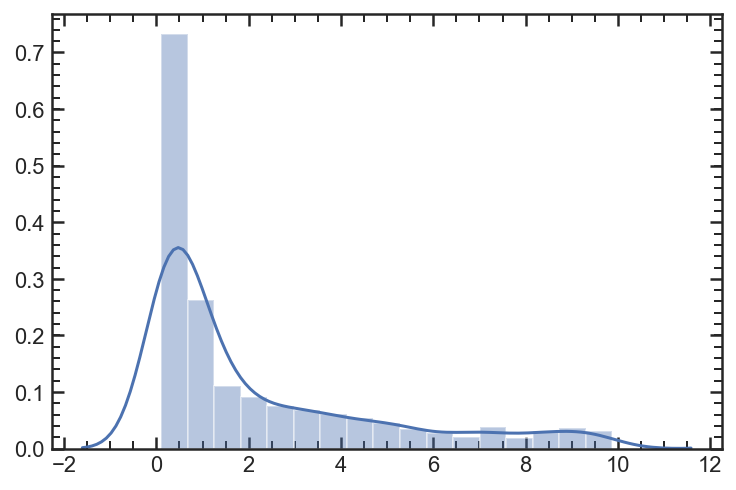

In [488]:
sea.distplot(log_10_prior(np.random.rand(1000), [0.1,10]))

In [9]:
sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = 0, sfh = 3, dust_type = 1)

In [10]:
Gs = Gen_spec('GND', 21156, nbfz, phot_errterm = 0.04, irac_err = 0.08) 

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:557: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3510: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:557: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


In [11]:
mb = multifit.MultiBeam('../data/multifit_data/gdn-grism-j123656p6215_25319.beams.fits',**args)

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3553: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3558: RuntimeWarning: invalid value encountered in sqrt
  contam_mask = ((self.contam*np.sqrt(self.ivar) > contam_sn_mask[0]) &
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3559: RuntimeWarning: invalid value encountered in sqrt
  (self.model*np.sqrt(self.ivar) < contam_sn_mask[1]))


1 ib3721xiq_flt.fits G141
2 ib3721xmq_flt.fits G141
3 ib3721xyq_flt.fits G141
4 ib3721y2q_flt.fits G141


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3510: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


5 ib3725dyq_flt.fits G141
6 ib3725e2q_flt.fits G141
7 ib3725eeq_flt.fits G141
8 ib3725eiq_flt.fits G141
9 icat21cfq_flt.fits G102
10 icat21coq_flt.fits G102
11 icat21dgq_flt.fits G102
12 icat21dlq_flt.fits G102
13 icat25hcq_flt.fits G102
14 icat25hiq_flt.fits G102
15 icat25icq_flt.fits G102
16 icat25iiq_flt.fits G102
17 icxt51jvq_flt.fits G102
18 icxt51jwq_flt.fits G102
19 icxt51jzq_flt.fits G102
20 icxt51k1q_flt.fits G102
21 icxt52i0q_flt.fits G102
22 icxt52i1q_flt.fits G102
23 icxt52i4q_flt.fits G102
24 icxt52i6q_flt.fits G102
25 icxt53i9q_flt.fits G102
26 icxt53iaq_flt.fits G102
27 icxt53idq_flt.fits G102
28 icxt53ifq_flt.fits G102
29 icxt55krq_flt.fits G102
30 icxt55ksq_flt.fits G102
31 icxt55kvq_flt.fits G102
32 icxt55kxq_flt.fits G102
33 icxta4mdq_flt.fits G102
34 icxta4meq_flt.fits G102
35 icxta4mhq_flt.fits G102
36 icxta4mjq_flt.fits G102


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1433: RuntimeWarning: divide by zero encountered in true_divide
  beam.ivarf = 1./(1/beam.ivarf + (sys_err*beam.scif)**2)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1573: RuntimeWarning: invalid value encountered in sqrt
  self.sivarf = np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1578: RuntimeWarning: invalid value encountered in sqrt
  self.weightf = np.exp(-(self.fcontam*np.abs(self.contamf)*np.sqrt(self.ivarf)))


In [12]:
grism_beams = {}
for g in mb.PA:
    grism_beams[g.lower()] = []
    for pa in mb.PA[g]:
        for i in mb.PA[g][pa]:
            grism_beams[g.lower()].append(mb.beams[i])

mb_g102 = multifit.MultiBeam(grism_beams['g102'], fcontam=mb.fcontam, 
                             min_sens=mb.min_sens, min_mask=mb.min_mask, 
                             group_name=mb.group_name+'-g102')
# bug, will be fixed ~today to not have to do this in the future
for b in mb_g102.beams:
    if hasattr(b, 'xp'):
        delattr(b, 'xp')
mb_g102.initialize_masked_arrays()

mb_g141 = multifit.MultiBeam(grism_beams['g141'], fcontam=mb.fcontam, 
                             min_sens=mb.min_sens, min_mask=mb.min_mask, 
                             group_name=mb.group_name+'-g141')
# bug, will be fixed ~today to not have to do this in the future
for b in mb_g141.beams:
    if hasattr(b, 'xp'):
        delattr(b, 'xp')
mb_g141.initialize_masked_arrays()

tilt_temps = {}
wave0 = 4000

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1433: RuntimeWarning: divide by zero encountered in true_divide
  beam.ivarf = 1./(1/beam.ivarf + (sys_err*beam.scif)**2)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1573: RuntimeWarning: invalid value encountered in sqrt
  self.sivarf = np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1578: RuntimeWarning: invalid value encountered in sqrt
  self.weightf = np.exp(-(self.fcontam*np.abs(self.contamf)*np.sqrt(self.ivarf)))
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3553: RuntimeWarning: invalid value encountered in sqrt
  resid = n

In [15]:
from grizli.utils import SpectrumTemplate

sp.params['dust2'] = bfd
sp.params['dust1'] = bfd
sp.params['logzsol'] = np.log10(bfm)

time, sfr, tmax = convert_sfh(get_agebins(bfa), [bfm1, bfm2, bfm3, bfm4, bfm5, bfm6, bfm7, bfm8, bfm9, bfm10], maxage = bfa*1E9)

sp.set_tabular_sfh(time,sfr) 

wave, flux = sp.get_spectrum(tage = bfa, peraa = True)

tilt_temps['fsps_model_slope'] = SpectrumTemplate(wave=wave, flux=flux*(wave-wave0)/wave0)
tilt_temps['fsps_model'] = SpectrumTemplate(wave, flux)

g102_fit = mb_g102.template_at_z(bfz, templates=tilt_temps, fitter='lstsq')
g141_fit = mb_g141.template_at_z(bfz, templates=tilt_temps, fitter='lstsq')

Pmfl = Gs.Sim_phot_mult(wave * (1 + bfz),flux)

scl = Scale_model(Gs.Pflx, Gs.Perr, Pmfl)


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:607: RuntimeWarning: invalid value encountered in true_divide
  opt_flux = num.sum(axis=0)/den.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:608: RuntimeWarning: divide by zero encountered in true_divide
  opt_var = 1./den.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/fitting.py:2882: RuntimeWarning: invalid value encountered in greater
  clip &= (er > 0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/fitting.py:2914: RuntimeWarning: invalid value encountered in multiply
  ymin = np.minimum(ymin, np.percentile((flm-er*0.)[clip],
/Users/vestrada/miniconda3

(-1, 40)

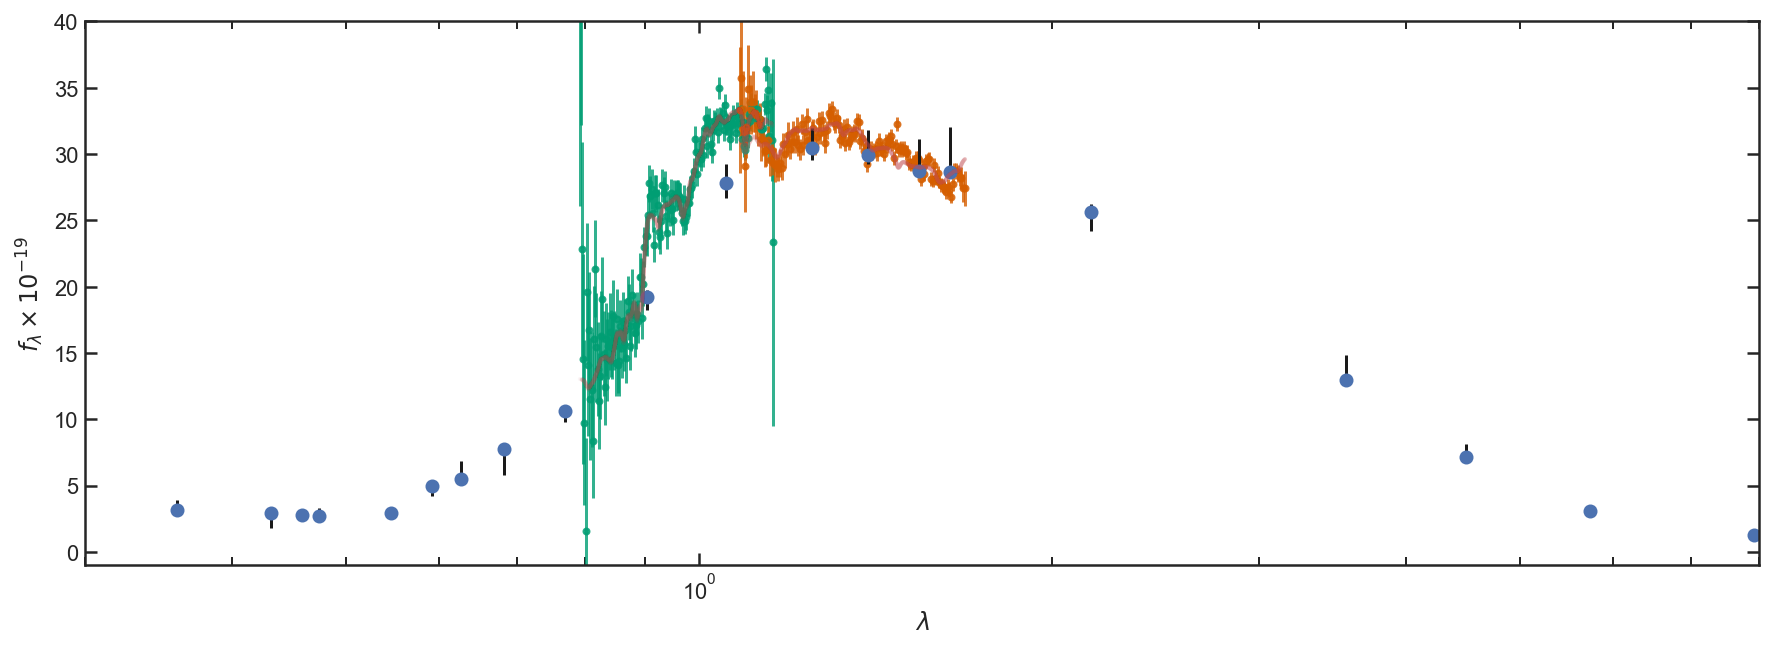

In [20]:
fig = plt.figure(figsize=[15,5])
ax1 = fig.add_subplot(111)

mb_g102.oned_figure(tfit=g102_fit, show_beams=False, axc=ax1)

mb_g141.oned_figure(tfit=g141_fit, show_beams=False, axc=ax1)

ax1.errorbar(Gs.Pwv / 1E4, Gs.Pflx*1E19, Gs.Perr*1E19, color = 'k', linestyle = 'none')

ax1.plot(Gs.Pwv / 1E4, scl*Pmfl*1E19,'o')
ax1.set_xscale('log')

ax1.set_xlim(.3,8)
ax1.set_ylim(-1,40)
# ax1.set_xticks([0.8,1,1.2,1.4,1.6])
# ax1.set_xticklabels([0.8,1,1.2,1.4,1.6])

In [38]:
g102_fit['cfit']['fsps_model_slope'][0]

6.951957596655432e-15

flux $L_\odot / \AA$ 

$L_\odot$ = $3.828X10^{33}$ erg / s

to_flam = $3.828X10^{33}$ /$4 \pi r^2$ erg / s / cm^2 /\AA

In [509]:
z =1.23
mpc_to_cm = 3.086E24 * u.cm / u.Mpc
r = cosmo.luminosity_distance(z) * mpc_to_cm
to_flam = 3.828E33 * (u.erg / u.s / u.angstrom) / ( 4 * np.pi * r**2)

In [510]:
to_flam

<Quantity 4.16242334e-25 erg / (Angstrom cm2 s)>

In [511]:
np.log10(scl / (to_flam.value / sp.stellar_mass))

10.906413453964376

In [ ]:
def scl_to_logmass(scale, redshift, stellar_mass):
    z = redshift
    mpc_to_cm = 3.086E24 * u.cm / u.Mpc
    r = cosmo.luminosity_distance(z) * mpc_to_cm
    to_flam = 3.828E33 * (u.erg / u.s / u.angstrom) / ( 4 * np.pi * r**2)
    return np.log10(scale / (to_flam.value / stellar_mass))

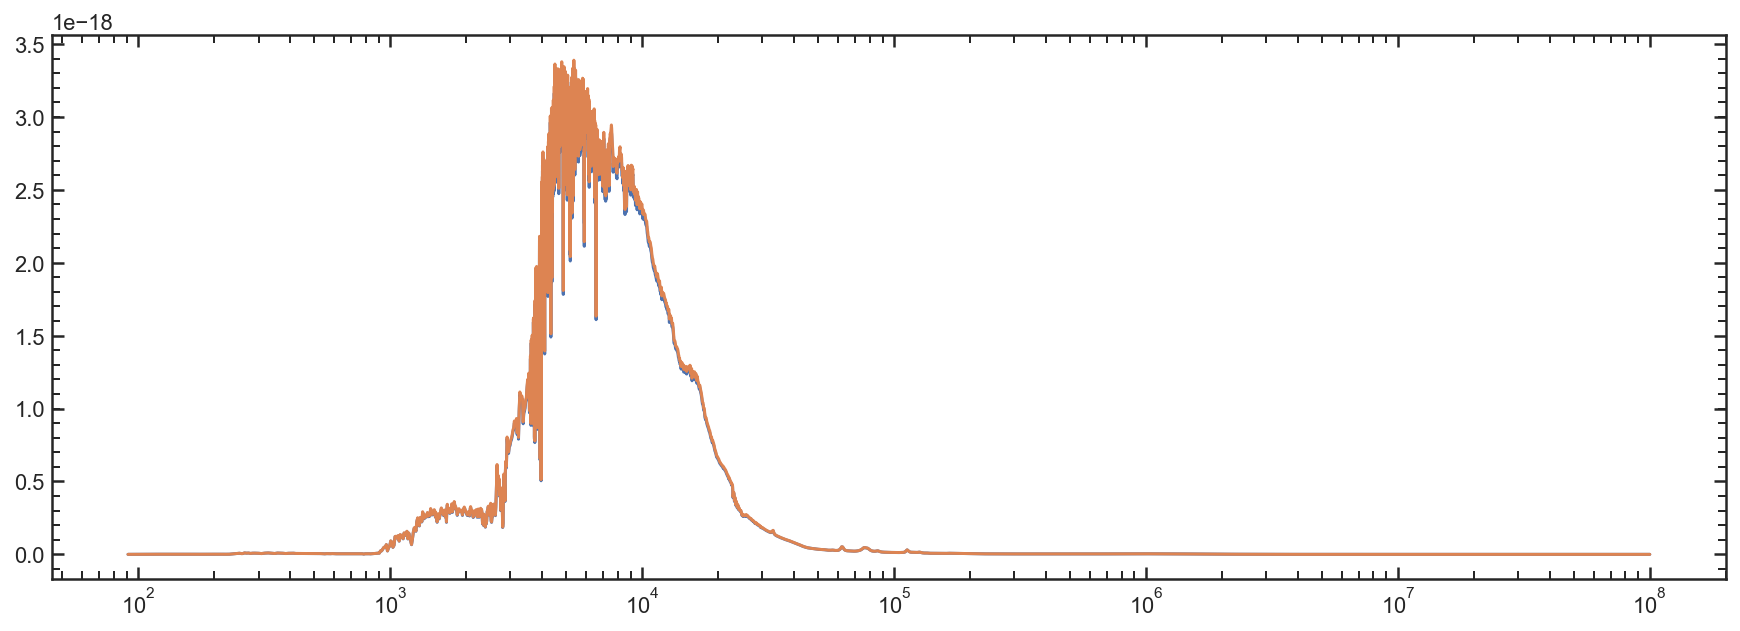

In [513]:
plt.figure(figsize=[15,5])
plt.plot(wave,flux * to_flam / sp.stellar_mass * 10**10.9)
plt.plot(wave,flux * scl)
plt.xscale('log')

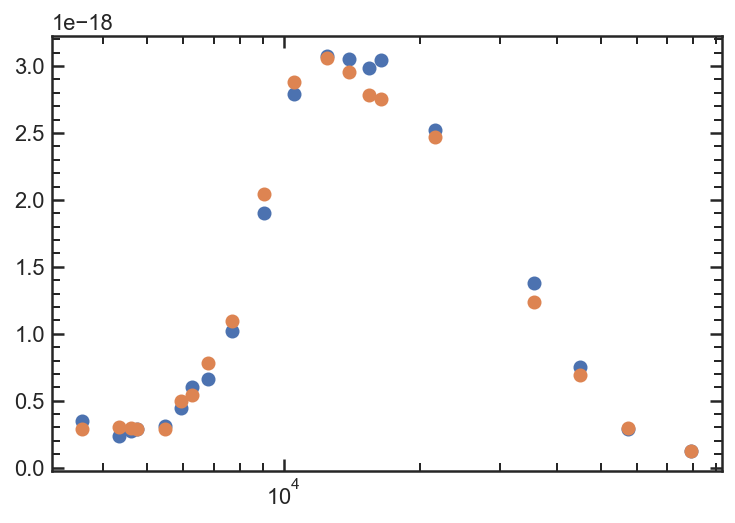

In [445]:
plt.plot(Gs.Pwv, Gs.Pflx,'o')

plt.plot(Gs.Pwv, scl*Pmfl,'o')
plt.xscale('log')

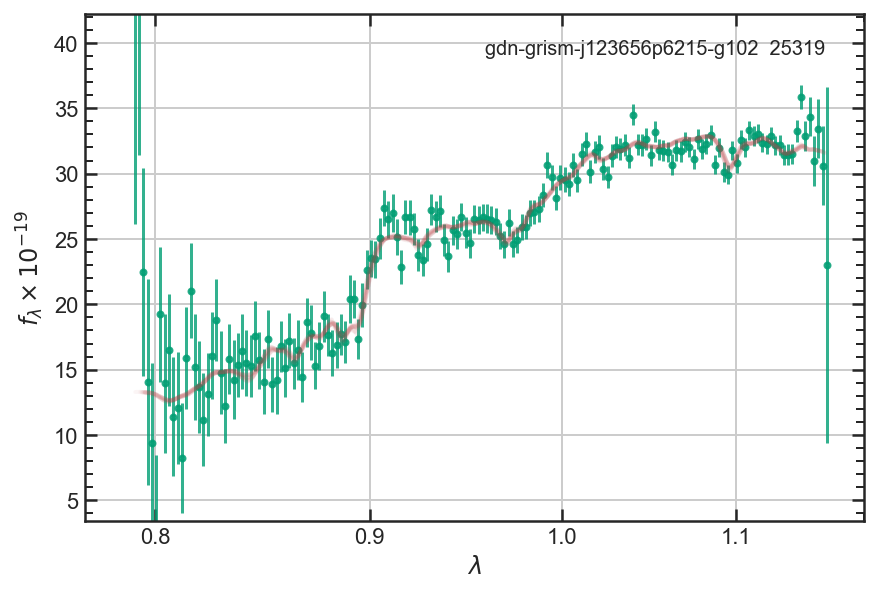

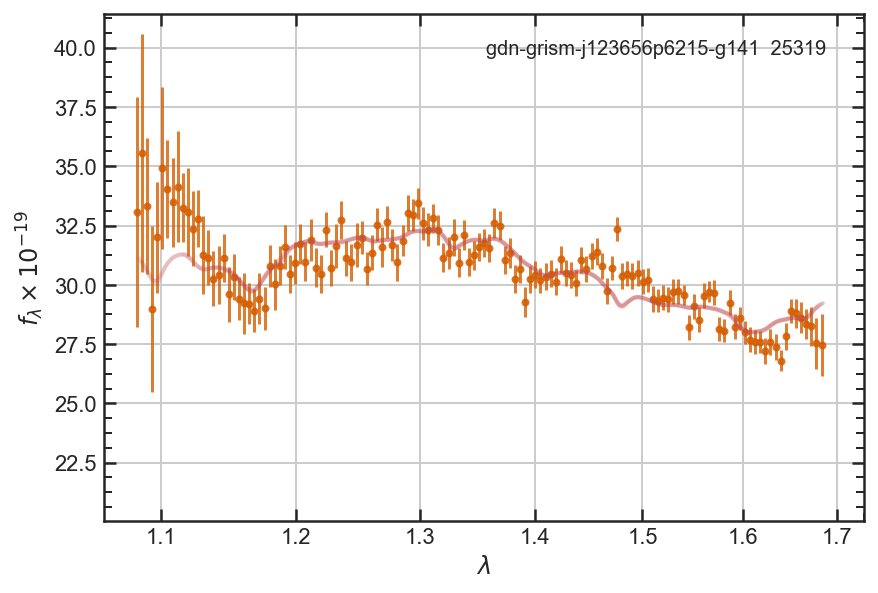

In [450]:
sp.params['dust2'] = nbfd
sp.params['dust1'] = nbfd
sp.params['logzsol'] = np.log10(nbfm)

time, sfr, tmax = convert_sfh(get_agebins(nbfa), [nbfm1, nbfm2, nbfm3, nbfm4, nbfm5, nbfm6, nbfm7, nbfm8, nbfm9, nbfm10], maxage = nbfa*1E9)

sp.set_tabular_sfh(time,sfr) 

wave, flux = sp.get_spectrum(tage = nbfa, peraa = True)

tilt_temps['fsps_model_slope'] = SpectrumTemplate(wave=wave, flux=flux*(wave-wave0)/wave0)
tilt_temps['fsps_model'] = SpectrumTemplate(wave, flux)

g102_fit = mb_g102.template_at_z(nbfz, templates=tilt_temps, fitter='lstsq')
g141_fit = mb_g141.template_at_z(nbfz, templates=tilt_temps, fitter='lstsq')

Pmfl = Gs.Sim_phot_mult(wave * (1 + nbfz),flux)

scl = Scale_model(Gs.Pflx, Gs.Perr, Pmfl)


fig = mb_g102.oned_figure(tfit=g102_fit, show_beams=False)
fig2 = mb_g141.oned_figure(tfit=g141_fit, show_beams=False)

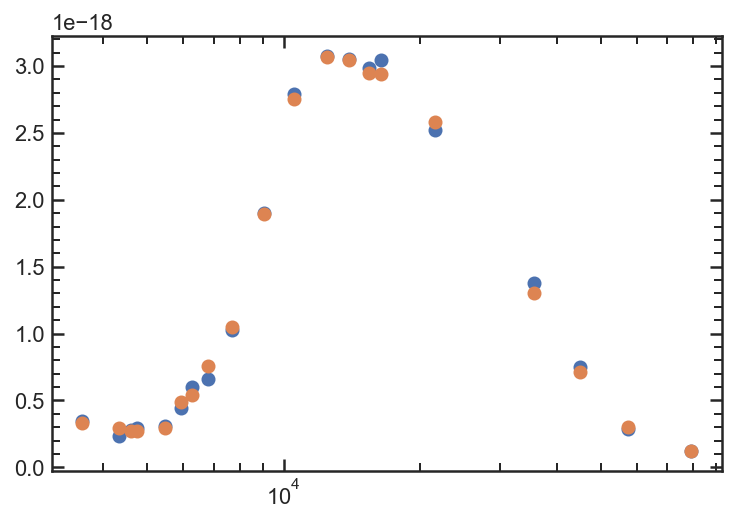

In [451]:
plt.plot(Gs.Pwv, Gs.Pflx,'o')

plt.plot(Gs.Pwv, scl*Pmfl,'o')
plt.xscale('log')

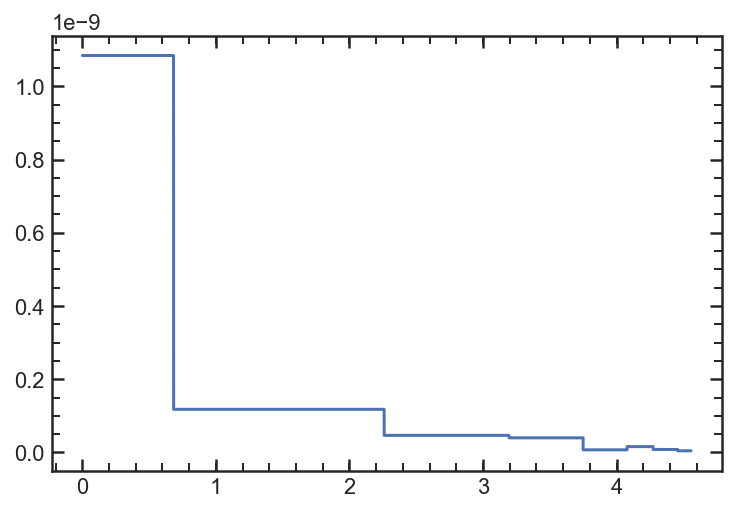

In [452]:
plt.plot(time,sfr)

# get lwa, masses, and tilts


In [48]:
from grizli.utils import SpectrumTemplate


def Derive_nuiscance_fits(ppf_dict, sp, Gs, mb_g102, mb_g141, draws = 1000):
    tilt_temps = {}
    
    lm = []
    lwa = []
    sl_b = []
    sl_r = []
    
    idx=0
    while idx < draws:
        try:
            draw = np.zeros(len(params))
            for ii in range(len(draw)):
                draw[ii] = ppf_dict[params[ii]](np.random.rand(1))[0]

            sp.params['dust2'] = draw[13]
            sp.params['dust1'] = draw[13]
            sp.params['logzsol'] = np.log10(draw[0])

            time, sfr, tmax = convert_sfh(get_agebins(draw[1]), draw[2:12], maxage = draw[1]*1E9)

            sp.set_tabular_sfh(time,sfr) 

            wave, flux = sp.get_spectrum(tage = draw[1], peraa = True)
            
            tilt_temps['fsps_model_slope'] = SpectrumTemplate(wave=wave, flux=flux*(wave-wave0)/wave0)
            tilt_temps['fsps_model'] = SpectrumTemplate(wave, flux)

            g102_fit = mb_g102.template_at_z(draw[12] , templates=tilt_temps, fitter='lstsq')
            g141_fit = mb_g141.template_at_z(draw[12] , templates=tilt_temps, fitter='lstsq')
            
            
            sl_b.append(g102_fit['cfit']['fsps_model_slope'][0])
            sl_r.append(g141_fit['cfit']['fsps_model_slope'][0])
            
            flam = F_lam_per_M(flux, wave * (1+draw[12]), draw[12], 0, sp.stellar_mass)
            Pmfl = Gs.Sim_phot_mult(wave * (1 + draw[12]),flam)
            scl = Scale_model(Gs.Pflx, Gs.Perr, Pmfl)

            lm.append(np.log10(scl))

            lwa.append(get_lwa(draw[:12], get_agebins(draw[1]),sp)[0])

            idx +=1
        except:
            pass
        
    return lm, lwa, sl_b, sl_r

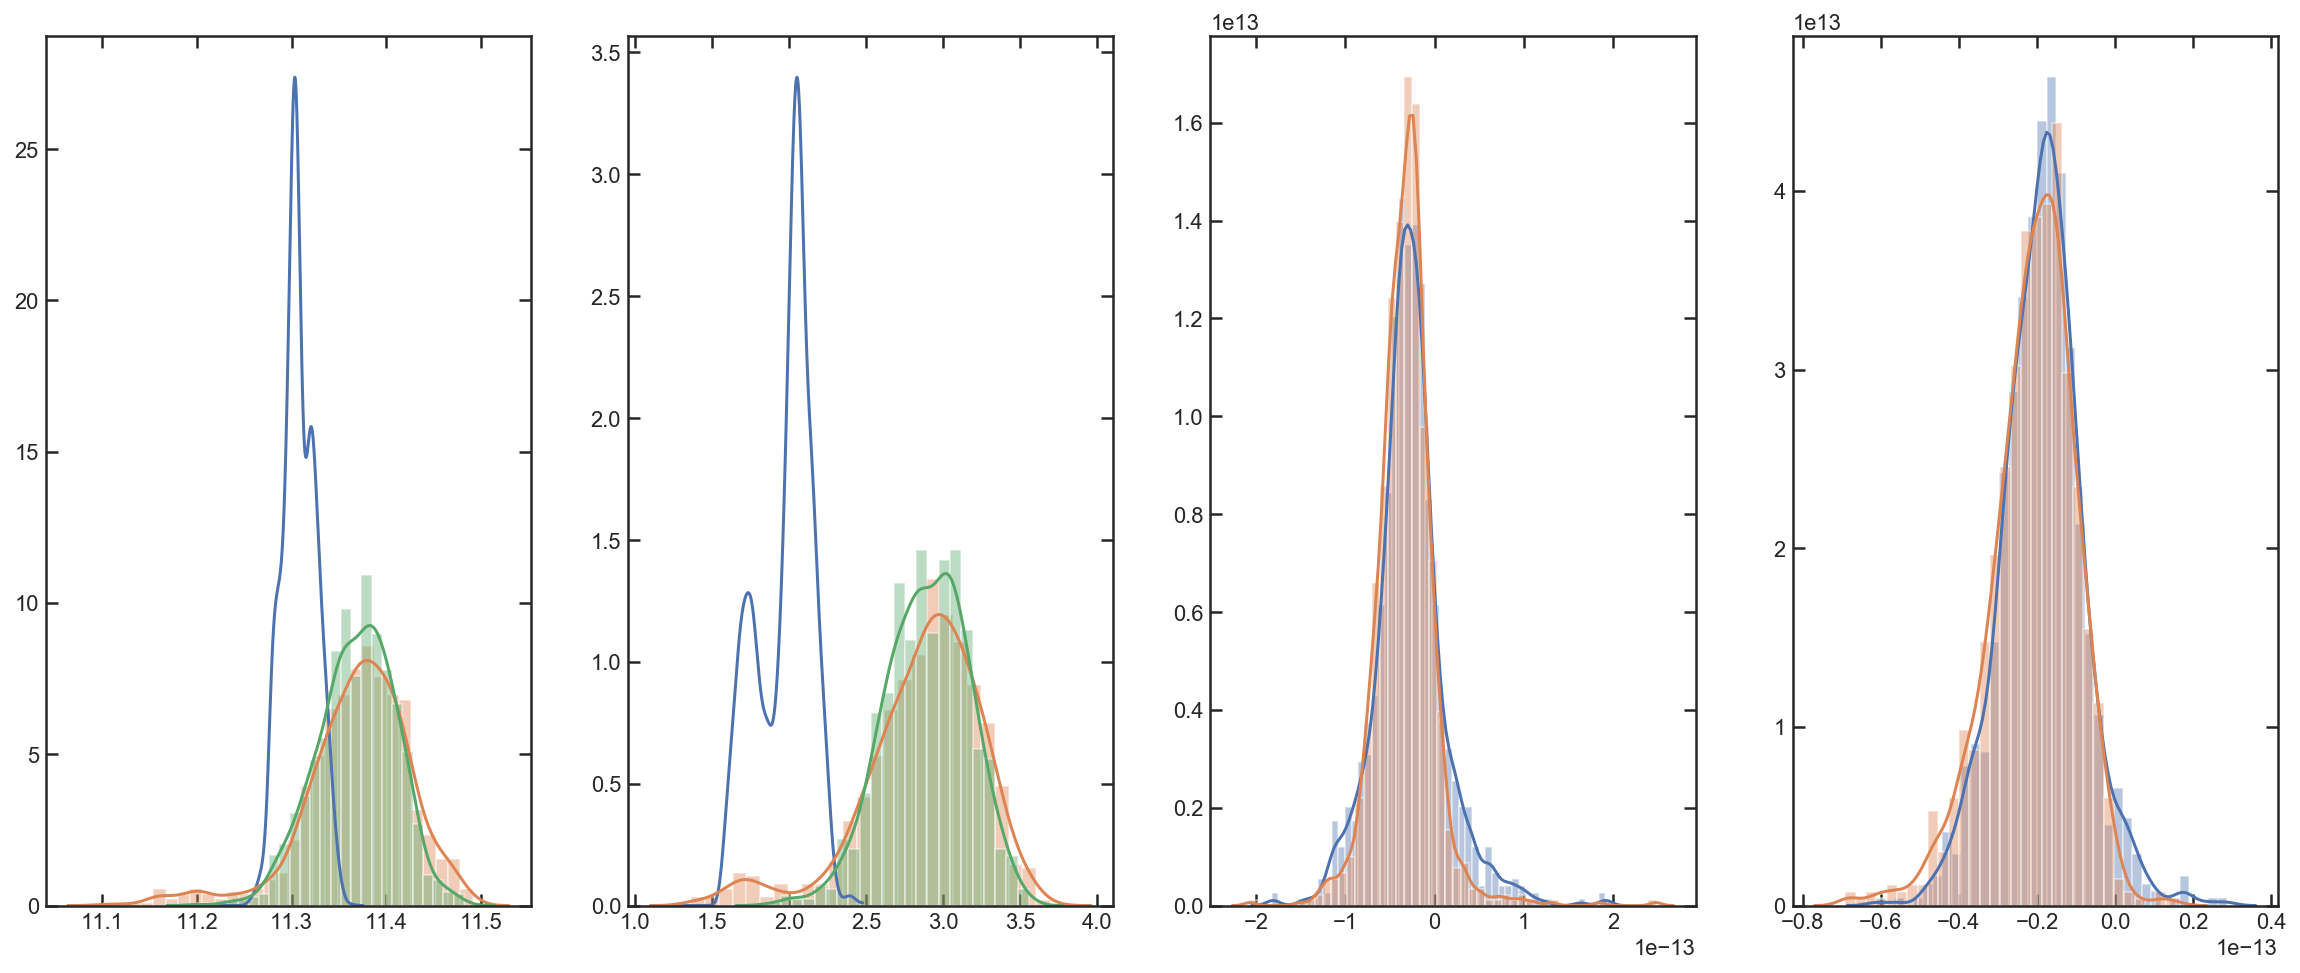

In [49]:
from sim_engine import F_lam_per_M
from spec_tools import Gen_PPF

sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = 0, sfh = 3, dust_type = 1)
params = ['m', 'a', 'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'z', 'd']
#        [ 0 ,  1 ,   2 ,   3 ,   4 ,   5 ,   6 ,   7 ,   8 ,   9 ,  10 ,   11 ,  12,  13]

gs = gridspec.GridSpec(1,4)

plt.figure(figsize=[20,8])
axlm = plt.subplot(gs[0])
axlwa = plt.subplot(gs[1])
axslB = plt.subplot(gs[2])
axslR = plt.subplot(gs[3])

ppf_dict = {}

for i in params:
    x,px = np.load('../data/posteriors/GND_21156_tabMfit_fp_P{}.npy'.format(i))
    ppf_dict[i] = Gen_PPF(x,px)

lm, lwa, slB, slR = Derive_nuiscance_fits(ppf_dict, sp, Gs, mb_g102, mb_g141, draws=1000)

x,Px = np.load('../data/posteriors/GND_21156_tabfit_Plm.npy')
axlm.plot(x,Px)
sea.distplot(lm, ax=axlm)

x,Px = np.load('../data/posteriors/GND_21156_tabfit_Plwa.npy')
axlwa.plot(x,Px)
sea.distplot(lwa, ax=axlwa)

sea.distplot(slB, ax=axslB)
sea.distplot(slR, ax=axslR)

ppf_dict = {}

for i in params:
    x,px = np.load('../data/posteriors/GND_21156_tabMfit_nerr_P{}.npy'.format(i))
    ppf_dict[i] = Gen_PPF(x,px)

lm, lwa, slB, slR = Derive_nuiscance_fits(ppf_dict, sp, Gs, mb_g102, mb_g141, draws=1000)

sea.distplot(lm, ax=axlm)

sea.distplot(lwa, ax=axlwa)

sea.distplot(slB, ax=axslB)
sea.distplot(slR, ax=axslR)

In [62]:
from spec_tools import boot_to_posterior

LM, PLM = boot_to_posterior(lm, np.ones_like(lm))
np.save('../data/posteriors/GND_21156_tabMfit_nerr_Plm', [LM, PLM])

LWA, PLWA = boot_to_posterior(lwa, np.ones_like(lwa))
np.save('../data/posteriors/GND_21156_tabMfit_nerr_Plwa', [LWA, PLWA])

SLB, PSLB = boot_to_posterior(slB, np.ones_like(slB))
np.save('../data/posteriors/GND_21156_tabMfit_nerr_Pslb', [SLB, PSLB])

SLR, PSLR = boot_to_posterior(slR, np.ones_like(slR))
np.save('../data/posteriors/GND_21156_tabMfit_nerr_Pslr', [SLR, PSLR])

In [57]:
from spec_tools import Derive_SFH_weights, z_at_value, boot_to_posterior

class Rescale_sfh_m(object):
    def __init__(self, field, galaxy, trials = 1000):

        ppf_dict = {}
        params = ['a', 'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'lm']

        for i in params:
            x,px = np.load('../data/posteriors/{0}_{1}_tabMfit_nerr_P{2}.npy'.format(field, galaxy, i))
            ppf_dict[i] = Gen_PPF(x,px)

        idx = 0
        x,px = np.load('../data/posteriors/{0}_{1}_tabMfit_nerr_Pz.npy'.format(field, galaxy))
        rshift = x[px == max(px)][0]
        self.fulltimes = np.arange(0.0,Oldest_galaxy(rshift),0.01)
        sfr_grid = []
        ssfr_grid = []
        t_50_grid = []
        t_80_grid = []
        t_90_grid = []
        t_q_grid = []

        while idx < trials:
            try:
                draw = np.zeros(len(params))

                for i in range(len(draw)):
                    draw[i] = ppf_dict[params[i]](np.random.rand(1))[0]

                time, sfr, tmax = convert_sfh(get_agebins(draw[0]), draw[1:11], maxage = draw[0]*1E9)

                T=[0]
                M=[0]
                for i in range(len(time)//2):
                    mass = sfr[i*2+1] * (time[i*2+1] - time[i*2])
                    M.append(M[i] + mass)
                    T.append(time[i*2+1])

                sfr = sfr/ M[-1] * 10**draw[11] / 1E9

                lbt = np.abs(time - time[-1])[::-1]
                lbsfr = sfr[::-1]

                T=[0]
                M=[0]
                for i in range(len(lbt)//2):
                    mass = lbsfr[i*2+1] * (lbt[i*2+1] - lbt[i*2])
                    M.append(M[i] + mass)
                    T.append(lbt[i*2+1])

                t_50_grid.append(interp1d(M/ M[-1], T)(0.5))
                t_80_grid.append(interp1d(M/ M[-1], T)(0.2))
                t_90_grid.append(interp1d(M/ M[-1], T)(0.1))

                sfrmax = np.argmax(lbsfr) 

                check = False
                for i in range(len(lbsfr[0:sfrmax+1])):
                    if int(lbsfr[0:sfrmax+1][-(i+1)]) <= int(max(lbsfr[0:sfrmax+1]) * 0.1):
                        t_q_grid.append(lbt[0:sfrmax+1][-(i+1)])
                        break
                if not check:
                    t_q_grid.append(lbt[0:sfrmax+1][-(i+1)])

                sfr_grid.append(interp1d(lbt,lbsfr,bounds_error=False,fill_value=0)(self.fulltimes))

                ssfr_grid.append(lbsfr[0] / 10**draw[11])
                idx +=1
            except:
                pass

        SFH = []
        SFH_16 = []
        SFH_84 = []
        ftimes = []
        for i in range(len(np.array(sfr_grid).T)):
            adat = np.array(np.array(sfr_grid).T[i])
            gdat = adat[adat>0]
            if len(gdat) < trials * 0.1:
                break
            else:
                SFH.append(np.percentile(gdat,50))
                SFH_16.append(np.percentile(gdat,16))
                SFH_84.append(np.percentile(gdat,84))

                ftimes.append(self.fulltimes[i])
                
        self.SFH = np.array(SFH)
        self.SFH_16 = np.array(SFH_16)
        self.SFH_84 = np.array(SFH_84)
        self.LBT = np.array(ftimes)
        
        self.sfr_grid = np.ma.masked_less_equal(sfr_grid,1E-10)

        weights = Derive_SFH_weights(self.SFH, sfr_grid[0:trials])
       
        ####### t values
        x,y = boot_to_posterior(t_50_grid[0:trials], weights)
        self.t_50, self.t_50_hci, self.t_50_offreg = Highest_density_region(y,x)
        
        x,y = boot_to_posterior(t_80_grid[0:trials], weights)
        self.t_80, self.t_80_hci, self.t_80_offreg = Highest_density_region(y,x)
        
        x,y = boot_to_posterior(t_90_grid[0:trials], weights)
        self.t_90, self.t_90_hci, self.t_90_offreg = Highest_density_region(y,x)
        
        self.t_50 = interp1d(np.cumsum(self.SFH[::-1]) / np.cumsum(self.SFH[::-1])[-1],self.LBT[::-1])(0.5)
        self.t_80 = interp1d(np.cumsum(self.SFH[::-1]) / np.cumsum(self.SFH[::-1])[-1],self.LBT[::-1])(0.8)
        self.t_90 = interp1d(np.cumsum(self.SFH[::-1]) / np.cumsum(self.SFH[::-1])[-1],self.LBT[::-1])(0.9)
        
        x,y = boot_to_posterior(t_q_grid[0:trials], weights)
        self.t_q, self.t_q_hci, self.t_q_offreg = Highest_density_region(y,x) 

        ####### z values
        self.z_50 = z_at_value(cosmo.age,(Oldest_galaxy(rshift) - self.t_50)*u.Gyr)
        hci=[]
        for lims in self.t_50_hci:
            hci.append(z_at_value(cosmo.age,(Oldest_galaxy(rshift) - lims)*u.Gyr))
        self.z_50_hci = np.array(hci)
        self.z_50_offreg = np.array(self.t_50_offreg)

        self.z_80 = z_at_value(cosmo.age,(Oldest_galaxy(rshift) - self.t_80)*u.Gyr)
        hci=[]
        for lims in self.t_80_hci:
            hci.append(z_at_value(cosmo.age,(Oldest_galaxy(rshift) - lims)*u.Gyr))
        self.z_80_hci = np.array(hci)
        self.z_80_offreg = np.array(self.t_80_offreg)
                       
        self.z_90 = z_at_value(cosmo.age,(Oldest_galaxy(rshift) - self.t_90)*u.Gyr)
        hci=[]
        for lims in self.t_90_hci:
            hci.append(z_at_value(cosmo.age,(Oldest_galaxy(rshift) - lims)*u.Gyr))
        self.z_90_hci = np.array(hci)
        self.z_90_offreg = np.array(self.t_90_offreg)
                       
        self.z_q = z_at_value(cosmo.age,(Oldest_galaxy(rshift) - self.t_q)*u.Gyr)
        hci=[]
        for lims in self.t_q_hci:
            hci.append(z_at_value(cosmo.age,(Oldest_galaxy(rshift) - lims)*u.Gyr))
        self.z_q_hci = np.array(hci)
        self.z_q_offreg = np.array(self.t_q_offreg)
        
        x,y = boot_to_posterior(np.log10(ssfr_grid[0:trials]), weights)
        self.lssfr, self.lssfr_hci, self.lssfr_offreg = Highest_density_region(y,x)
            
        self.weights = weights
        self.t_50_grid = t_50_grid
        self.t_80_grid = t_80_grid
        self.t_90_grid = t_90_grid

In [58]:
sfh = Rescale_sfh_m('GND', 21156)

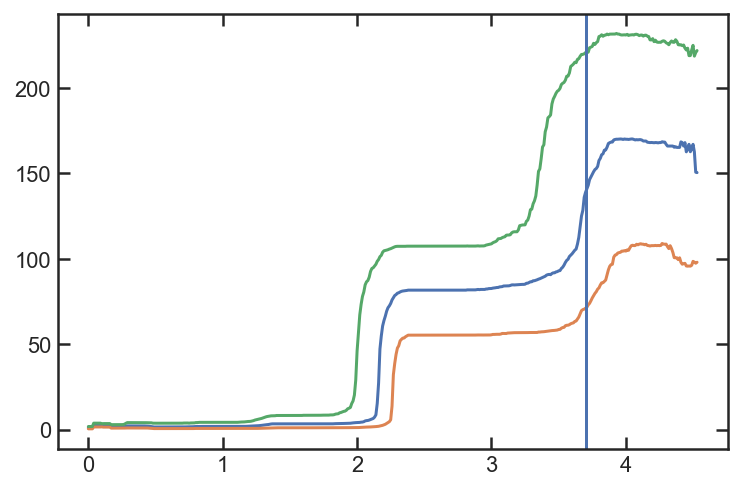

In [61]:
plt.plot(sfh.LBT, sfh.SFH)
plt.plot(sfh.LBT, sfh.SFH_16)
plt.plot(sfh.LBT, sfh.SFH_84)
plt.axvline(sfh.t_50)

# get lwa, masses, tilts, and line fluxes


In [72]:
from grizli.utils import SpectrumTemplate


def Derive_nuiscance_SFfits(ppf_dict, sp, Gs, mb_g102, mb_g141, draws = 1000):
    tilt_temps = {}
    linestr = {}

    entries = ['line SII','line Ha','line OI-6302','line HeI-5877',
               'line OIII','line Hb','line OIII-4363','line Hg','line Hd','line NeIII-3867','line OII']

    for k in args['t1']:
        if k in entries:
            tilt_temps[k] = args['t1'][k]
            linestr[k] = []
        
    lm = []
    lwa = []
    sl_b = []
    sl_r = []
    
    idx=0
    while idx < draws:
        try:
            draw = np.zeros(len(params))
            for ii in range(len(draw)):
                draw[ii] = ppf_dict[params[ii]](np.random.rand(1))[0]

            sp.params['dust2'] = draw[8]
            sp.params['logzsol'] = np.log10(draw[0])

            time, sfr, tmax = convert_sfh(get_agebins(draw[1], binnum = 6), draw[2:8], maxage = draw[1]*1E9)

            sp.set_tabular_sfh(time,sfr) 

            wave, flux = sp.get_spectrum(tage = draw[1], peraa = True)

            tilt_temps['fsps_model_slope'] = SpectrumTemplate(wave=wave, flux=flux*(wave-wave0)/wave0)
            tilt_temps['fsps_model'] = SpectrumTemplate(wave, flux)

            g102_fit = mb_g102.template_at_z(draw[9] , templates=tilt_temps, fitter='lstsq')
            g141_fit = mb_g141.template_at_z(draw[9] , templates=tilt_temps, fitter='lstsq')


            for k in entries:
                lineflux = np.array([g102_fit['cfit'][k][0],g141_fit['cfit'][k][0]])

                linestr[k].append(sum(lineflux) / len(lineflux[lineflux > 0]) )

            sl_b.append(g102_fit['cfit']['fsps_model_slope'][0])
            sl_r.append(g141_fit['cfit']['fsps_model_slope'][0])

            wv_obs, flx = spec_construct(g102_fit,g141_fit,draw[9])
            iflux = interp1d(wave*(1+draw[9]), flux)(wv_obs[flx**2 > 0])

            flam = F_lam_per_M(flx * (iflux[50]/flx[50]),wv_obs, draw[9], 0, sp.stellar_mass)
            Pmfl = Gs.Sim_phot_mult(wv_obs,flam)
            scl = Scale_model(Gs.Pflx, Gs.Perr, Pmfl)

            lm.append(np.log10(scl))

            lwa.append(get_lwa_SF(draw[:8], get_agebins(draw[1], binnum = 6),sp)[0])

            idx +=1
        except:
            pass
        
    return lm, lwa, sl_b, sl_r, linestr

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater


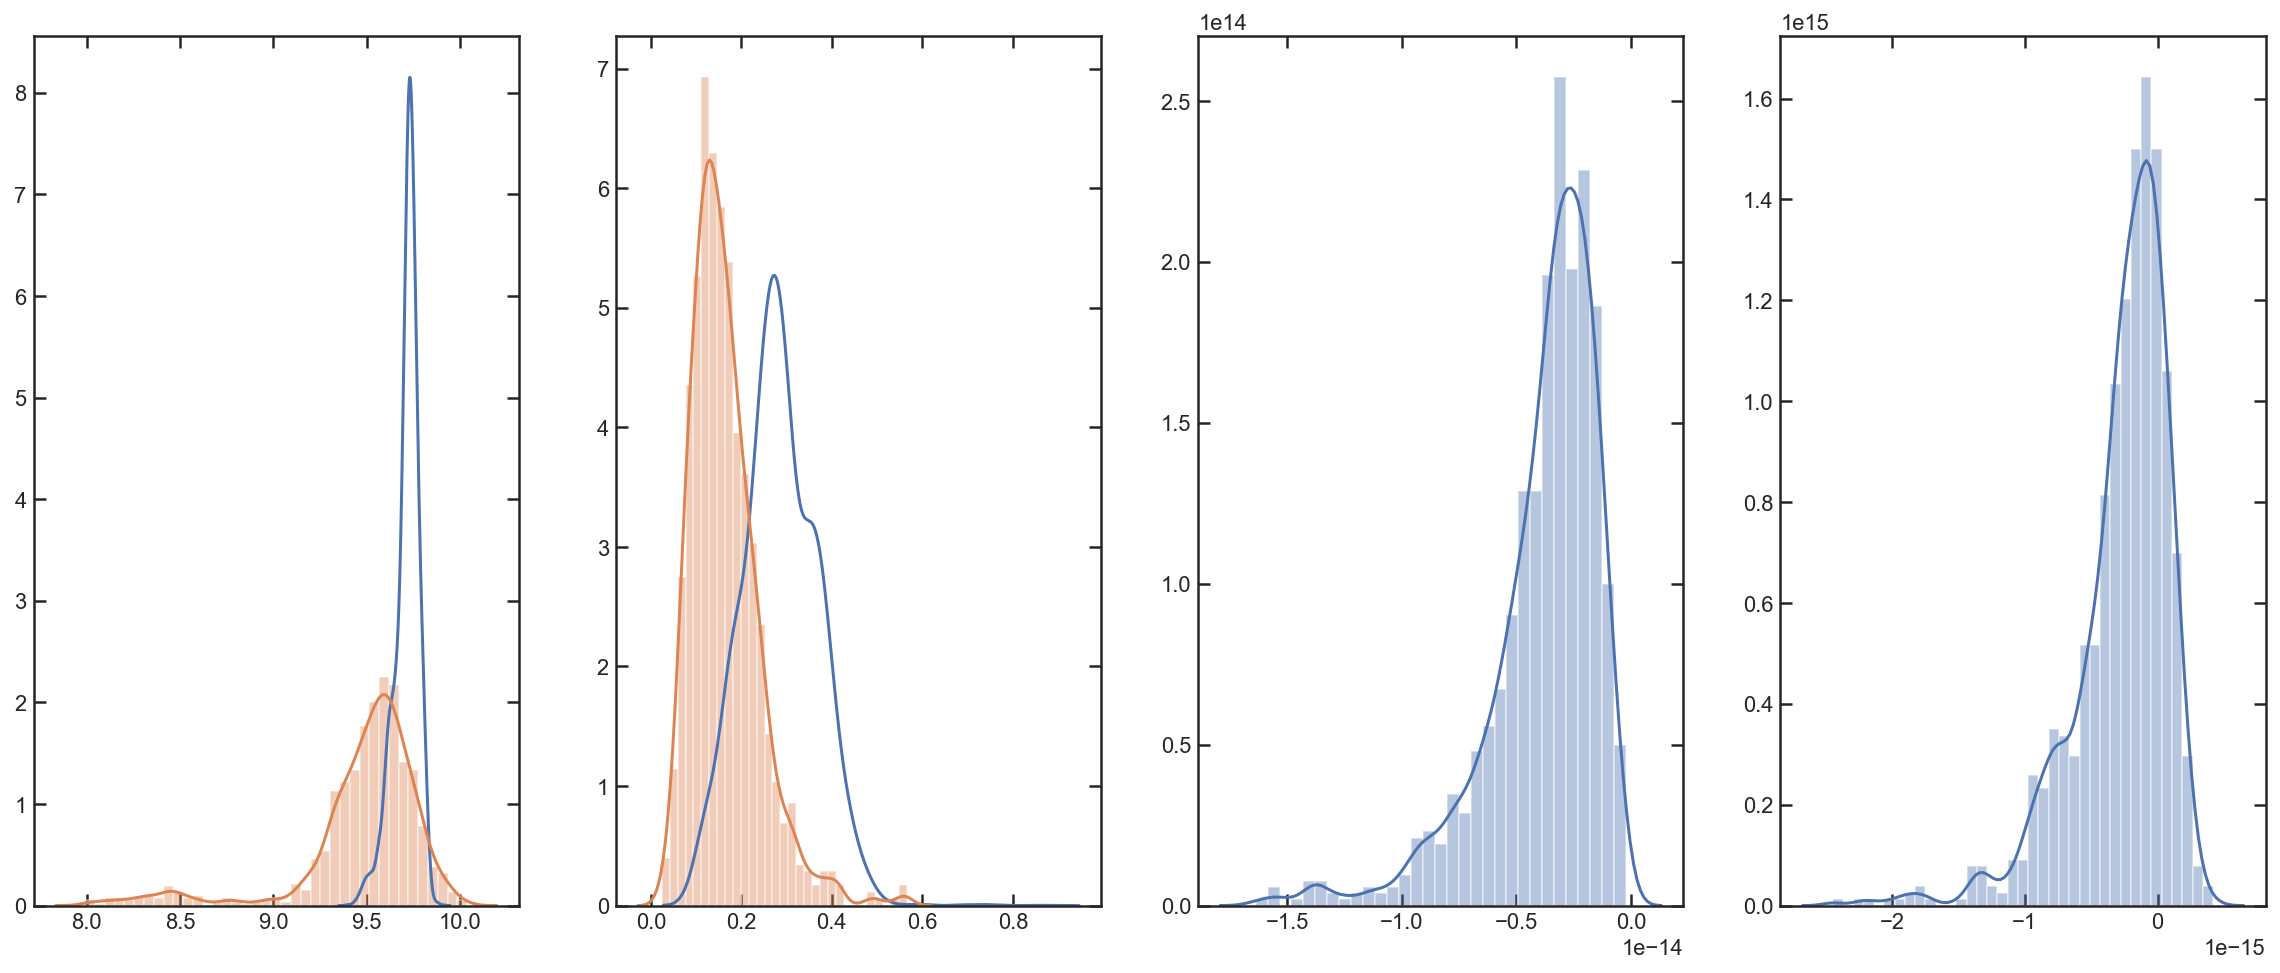

In [73]:
from sim_engine import F_lam_per_M
from spec_tools import Gen_PPF

sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = 0, sfh = 3, dust_type = 2)
sp.params['dust1'] = 0

params = ['m', 'a', 'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'd', 'z']
#        [ 0 ,  1 ,   2 ,   3 ,   4 ,   5 ,   6 ,   7 ,  8 ,  9 ]

gs = gridspec.GridSpec(1,4)

plt.figure(figsize=[20,8])
axlm = plt.subplot(gs[0])
axlwa = plt.subplot(gs[1])
axslB = plt.subplot(gs[2])
axslR = plt.subplot(gs[3])

ppf_dict = {}

for i in params:
    x,px = np.load('../data/posteriors/GND_11839_SFMfit_np_P{}.npy'.format(i))
    ppf_dict[i] = Gen_PPF(x,px)

lm, lwa, slB, slR, linestr = Derive_nuiscance_SFfits(ppf_dict, sp, Gs, mb_g102, mb_g141, draws=1000)

x,Px = np.load('../Casey_data/posteriors/GND_11839_SFfit_Plm.npy')
axlm.plot(x,Px)
sea.distplot(lm, ax=axlm)

x,Px = np.load('../Casey_data/posteriors/GND_11839_SFfit_Plwa.npy')
axlwa.plot(x,Px)
sea.distplot(lwa, ax=axlwa)

sea.distplot(slB, ax=axslB)
sea.distplot(slR, ax=axslR)

# ppf_dict = {}

# for i in params:
#     x,px = np.load('../data/posteriors/GND_11839_SFMfit_sp_P{}.npy'.format(i))
#     ppf_dict[i] = Gen_PPF(x,px)

# lm, lwa, slB, slR = Derive_nuiscance_fits(ppf_dict, sp, Gs, mb_g102, mb_g141, draws=1000)

# sea.distplot(lm, ax=axlm)

# sea.distplot(lwa, ax=axlwa)

# sea.distplot(slB, ax=axslB)
# sea.distplot(slR, ax=axslR)

# ppf_dict = {}

# for i in params:
#     x,px = np.load('../data/posteriors/GND_11839_SFMfit_fp_P{}.npy'.format(i))
#     ppf_dict[i] = Gen_PPF(x,px)

# lm, lwa, slB, slR = Derive_nuiscance_fits(ppf_dict, sp, Gs, mb_g102, mb_g141, draws=1000)

# sea.distplot(lm, ax=axlm)

# sea.distplot(lwa, ax=axlwa)

# sea.distplot(slB, ax=axslB)
# sea.distplot(slR, ax=axslR)

In [196]:
grism_beams = {}
for g in mb.PA:
    grism_beams[g.lower()] = []
    for pa in mb.PA[g]:
        for i in mb.PA[g][pa]:
            grism_beams[g.lower()].append(mb.beams[i])

    print(g, len(grism_beams[g.lower()]))

G102 25
G141 16


In [42]:
linecat = pd.read_pickle('../Casey_data/massMetal_GND.pkl')

In [59]:
lineca

ID          RA        DEC  nlines      z_50      z_02      z_16  \
206   35075  189.257160  62.325262      11  1.780320  1.779364  1.779850   
392   35204  189.278387  62.326530       8  2.096987  2.095948  2.096443   
549   28379  189.299923  62.283155      14  1.143402  1.142528  1.142962   
754   32719  189.269131  62.307222      14  1.250495  1.250196  1.250389   
755   32719  189.269131  62.307222       9  1.250779  1.250209  1.250487   
1266  30204  189.319471  62.292588      11  1.145387  1.144999  1.145191   
1533  20801  189.147621  62.243780       7  1.999847  1.998806  1.999321   
1556  11839  189.123584  62.200011      13  1.240109  1.239838  1.239926   
1741  17927  189.103116  62.230177      13  1.346372  1.345973  1.346147   
1899  17324  189.103710  62.227647      12  2.304721  2.303980  2.304343   
1925  13777  189.143853  62.211387      10  1.231162  1.230195  1.230669   
1948  14281  189.144534  62.212046      13  1.223864  1.223546  1.223676   
1954  19235  189.138540  62.236447      14  1.342986  1.342556  1.342766   
2031  13197  189.133373  62.206913       9  1.463872  1.462859  1.463357   
2142  19659  189.102727  62.238545      12  1.452604  1.452253  1.452416   
2143  14850  189.113839  62.216056      13  1.221181  1.220900  1.221052   
2193  17293  189.105218  62.227458      11  1.856696  1.856252  1.856498   
2329  18197  189.219886  62.231786      14  1.359656  1.359396  1.359474   
2444  21231  189.194733  62.246103       8  2.002546  2.001452  2.001979   
2466  10639  189.222970  62.194759      12  1.265857  1.265542  1.265723   
2572  12674  189.215026  62.204818       9  2.047349  2.045327  2.046317   
2681  21290  189.268060  62.246180      11  2.216624  2.216097  2.216330   
2865  17579  189.196553  62.228314      13  1.315082  1.313983  1.314529   
3082  19591  189.201272  62.237955      10  2.001922  2.001311  2.001608   
3229  21707  189.333230  62.249049       9  1.990297  1.989218  1.989757   
3326  24427  189.370771  62.261684      11  1.774283  1.773942  1.774095   
3361  22547  189.288063  62.252230      13  1.225057  1.224140  1.224595   
3393  24221  189.377773  62.261030       9  1.476900  1.475330  1.476007   
3765  37395  189.299358  62.352114       6  1.225320  1.224989  1.225151   
3936  37893  189.314448  62.367490      12  1.363330  1.362421  1.362858   
4205  30053  189.197529  62.291330       8  2.243292  2.241879  2.242575   
4209  31400  189.172182  62.298808       8  2.326095  2.324801  2.325447   

          z_84      z_97  Lya_FLUX    ...         rest161  rest161_err  \
206   1.780810  1.781250     -99.0    ...        2.088467     0.207864   
392   2.097505  2.098044     -99.0    ...        7.955357     0.152577   
549   1.143836  1.144260     -99.0    ...       43.815441     9.933833   
754   1.250600  1.250793     -99.0    ...        7.938620     0.575707   
755   1.251051  1.251336     -99.0    ...        7.938620     0.575707   
1266  1.145547  1.145745     -99.0    ...       71.678186     0.538850   
1533  2.000387  2.000876     -99.0    ...        5.209579     0.045888   
1556  1.240241  1.240415     -99.0    ...        7.885126     0.187320   
1741  1.346607  1.346838     -99.0    ...        3.425184     0.372052   
1899  2.305099  2.305462     -99.0    ...        1.568568     0.122103   
1925  1.231672  1.232166     -99.0    ...      125.027978     7.707293   
1948  1.224041  1.224194     -99.0    ...       14.117845     0.887179   
1954  1.343160  1.343374     -99.0    ...        8.396114     0.578284   
2031  1.464396  1.464911     -99.0    ...        8.201197     0.633415   
2142  1.452794  1.452953     -99.0    ...        3.695006     0.361214   
2143  1.221278  1.221323     -99.0    ...       48.285120     7.381783   
2193  1.856955  1.857145     -99.0    ...        2.871669     0.154415   
2329  1.359794  1.359849     -99.0    ...       24.181723     2.802887   
2444  2.003117  2.003658     -99.0    ...       19.221297     1.298590   
2466  1.266015  1.26

In [66]:
list(linecat.keys())
#     entries = ['line SII','line Ha','line OI-6302','line HeI-5877',
#                'line OIII','line Hb','line OIII-4363','line Hg','line Hd','line NeIII-3867','line OII']
    
for k in entries:
    try:
        print(linecat[k.strip('line ') + '_FLUX'][1556]*1E-17 )
#     print(k.strip('line ') + '_FLUX')
    except:
        pass

3.5579747937048305e-17
1.52631721908767e-16
2.4402392024230203e-16
4.53150416569906e-17
1.23491692043957e-17
1.12816584076114e-17
1.2509506608589904e-16


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


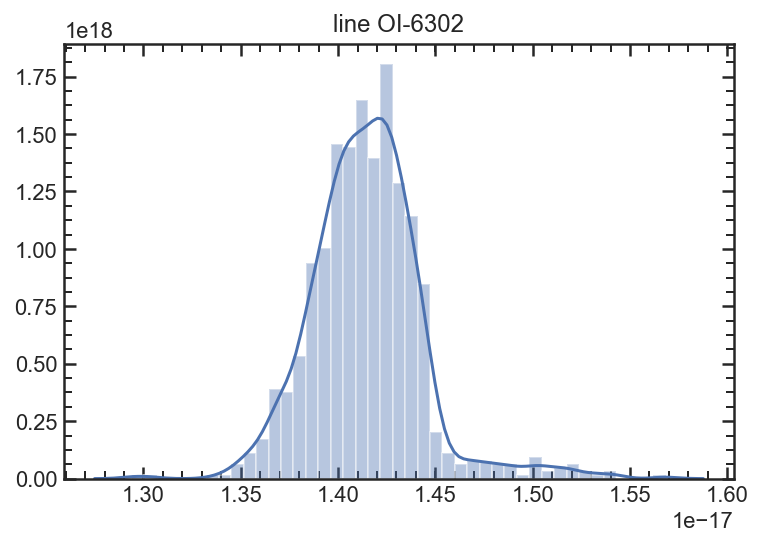

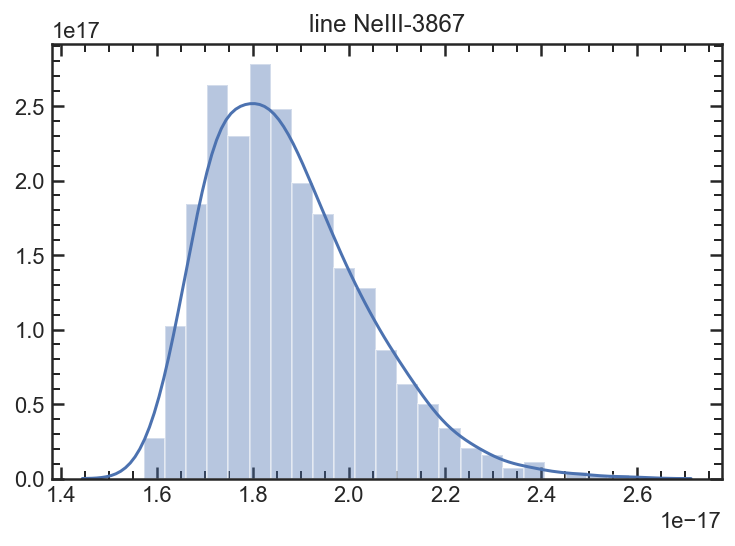

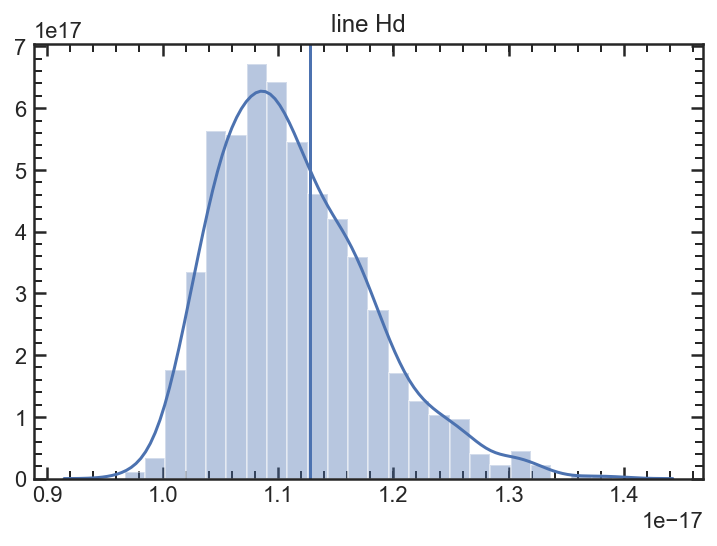

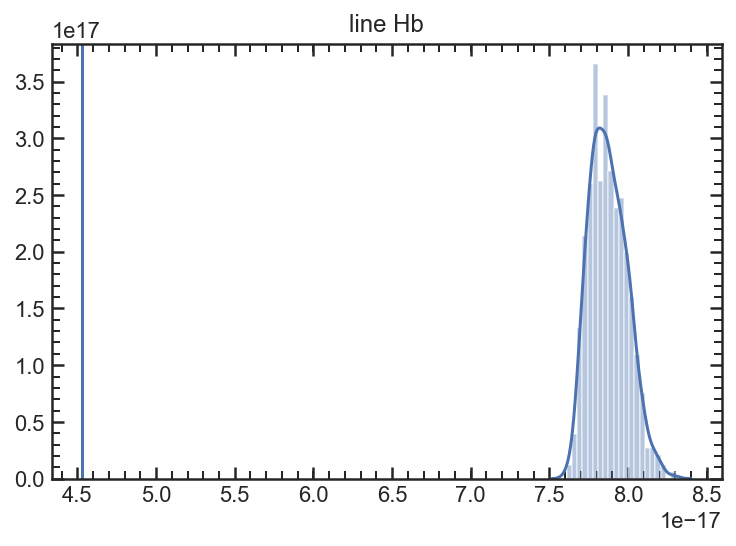

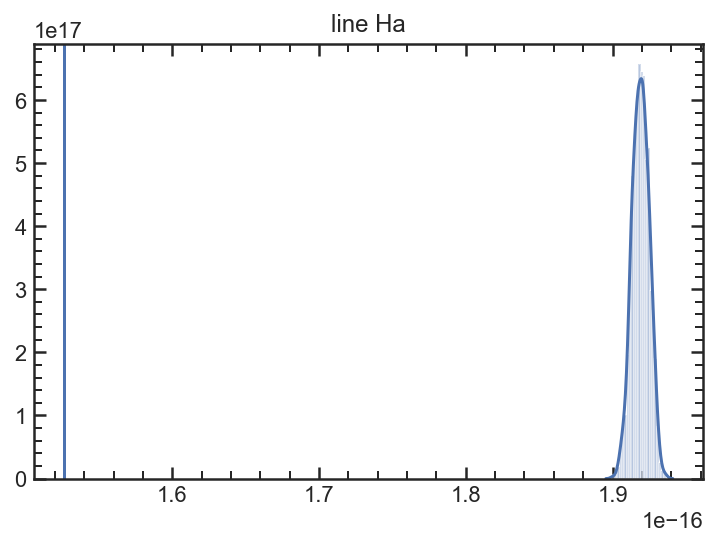

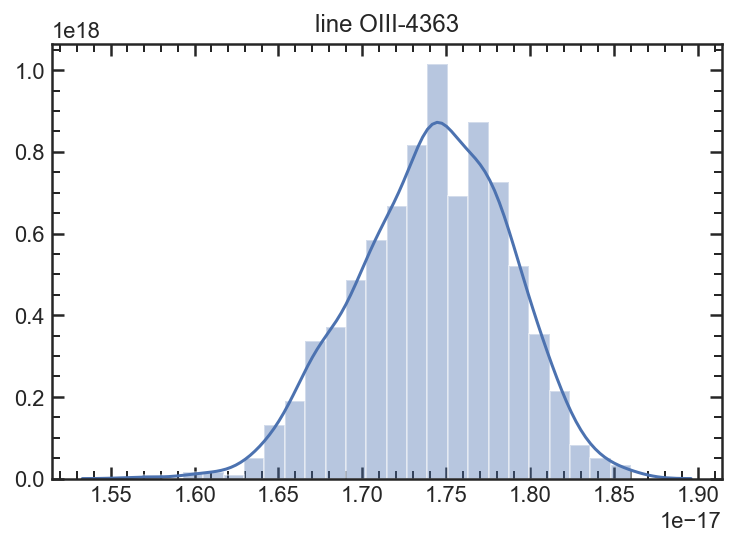

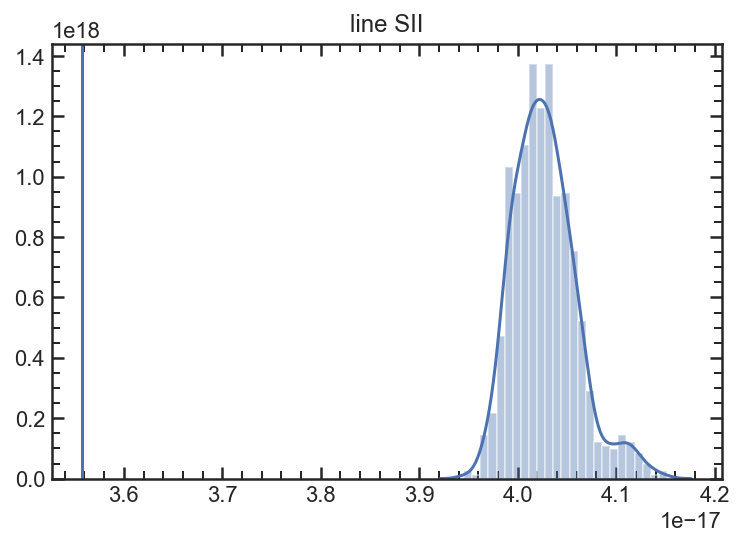

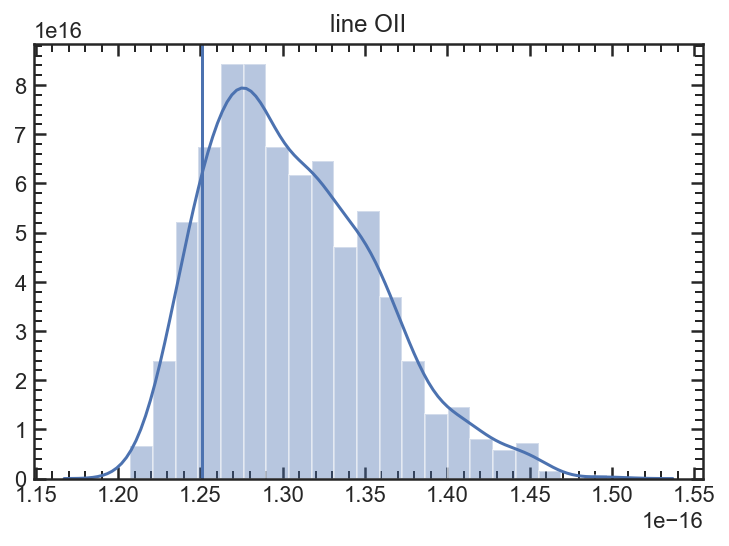

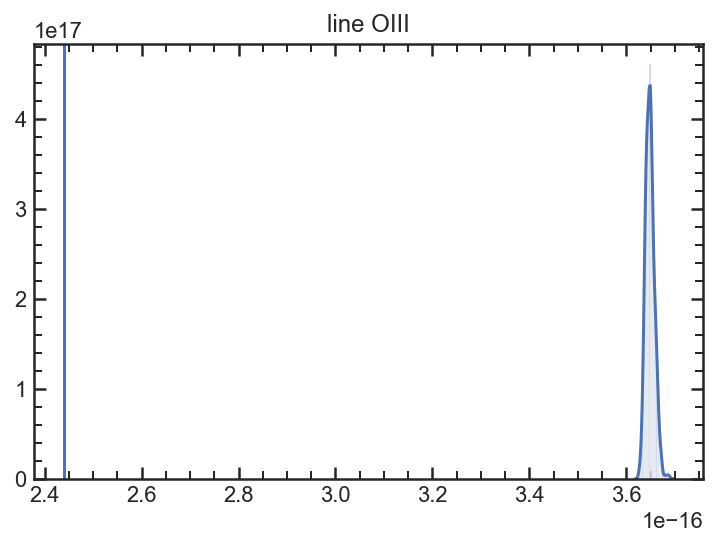

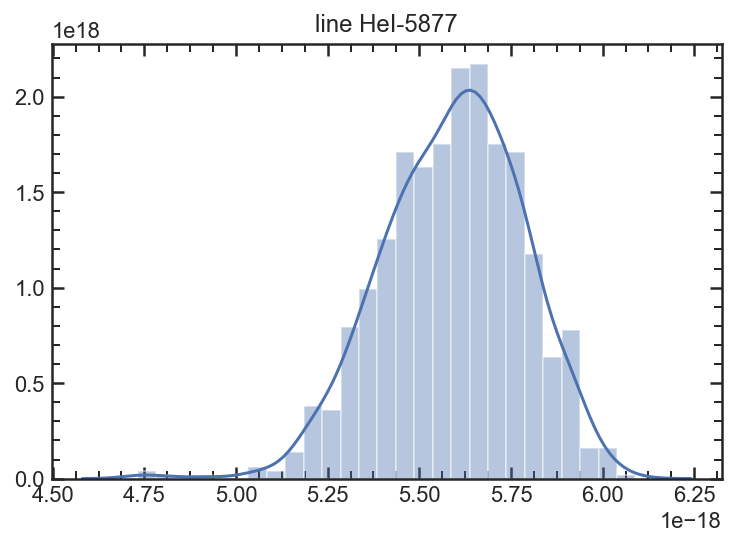

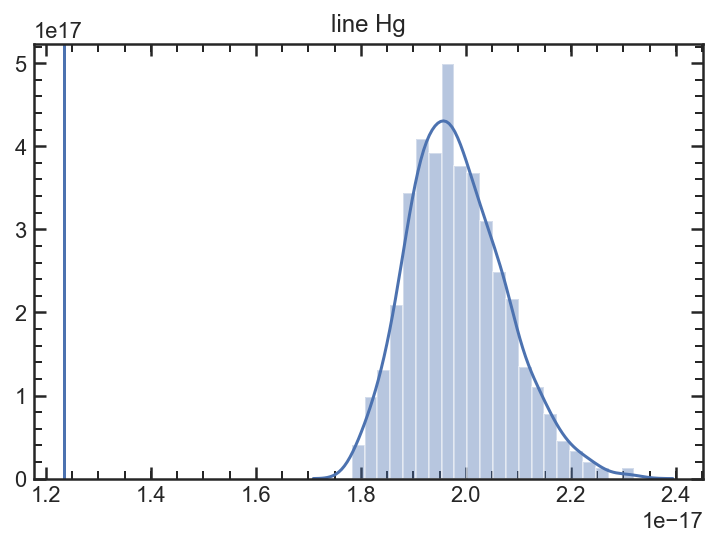

In [67]:
for i in linestr:
    plt.figure()
    sea.distplot(linestr[i])
    plt.title(i)
    try:
        plt.axvline(linecat[i.strip('line ') + '_FLUX'][1556]*1E-17)
#     print(k.strip('line ') + '_FLUX')
    except:
        pass


In [197]:
mb.group_name

'gdn-grism-j123656p6215'

In [198]:
mb_g102 = multifit.MultiBeam(grism_beams['g102'], fcontam=mb.fcontam, 
                             min_sens=mb.min_sens, min_mask=mb.min_mask, 
                             group_name=mb.group_name+'-g102')

# bug, will be fixed ~today to not have to do this in the future
for b in mb_g102.beams:
    if hasattr(b, 'xp'):
        delattr(b, 'xp')

mb_g102.initialize_masked_arrays()

mb_g141 = multifit.MultiBeam(grism_beams['g141'], fcontam=mb.fcontam, 
                             min_sens=mb.min_sens, min_mask=mb.min_mask, 
                             group_name=mb.group_name+'-g141')

# bug, will be fixed ~today to not have to do this in the future
for b in mb_g141.beams:
    if hasattr(b, 'xp'):
        delattr(b, 'xp')

mb_g141.initialize_masked_arrays()

In [199]:
# allow for tilt
from grizli import utils

wave0 = 4000
templ = test_args['fsps_model']
slope_template = utils.SpectrumTemplate(wave=templ.wave, flux=templ.flux*(np.arange(len(templ.wave))-wave0)/wave0)
slope_templates = {}
for t in test_args:
    slope_templates[t] = test_args[t]

slope_templates['fsps_model_slope'] = slope_template

In [151]:
tfit_g102 = mb_g102.template_at_z(bfz, templates=slope_templates, fitter='lstsq')
tfit_g141 = mb_g141.template_at_z(bfz, templates=slope_templates, fitter='lstsq')

In [160]:
print(tfit_g102['chi2']),print(g102_fit['chi2'])

49569.027542788885
49569.02754278205


(None, None)

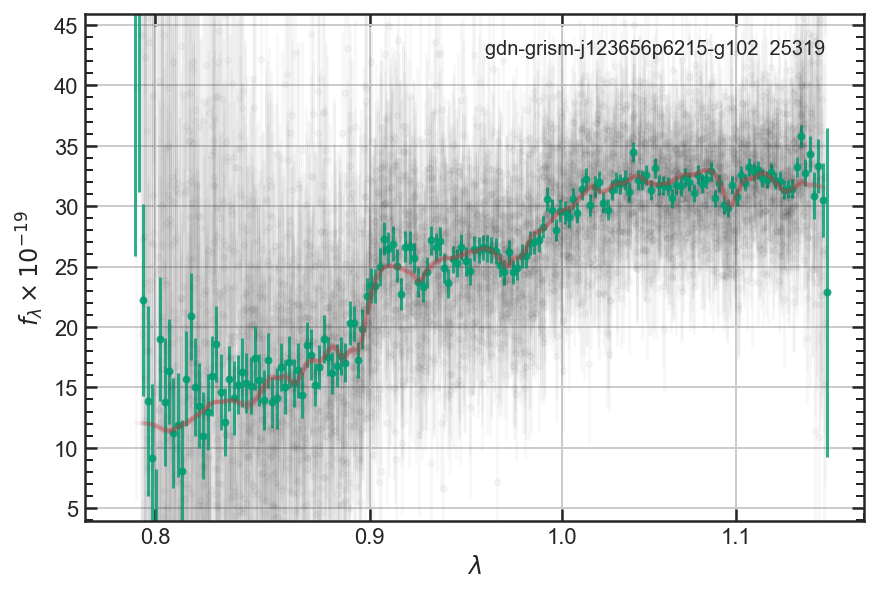

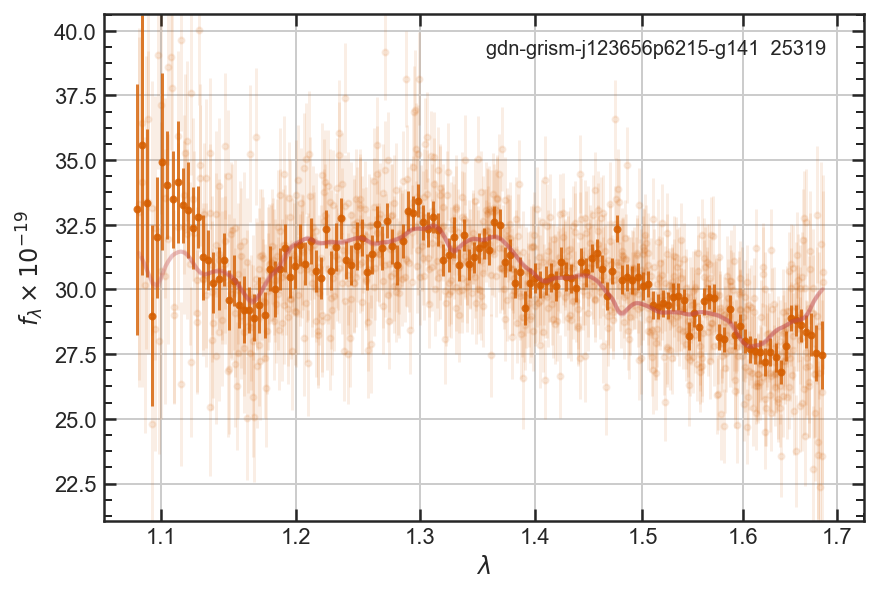

In [154]:
fig = mb_g102.oned_figure(tfit=tfit_g102) #, show_individual_templates=True)
fig2= mb_g141.oned_figure(tfit=tfit_g141)

In [157]:
tilt_temps = {}
tilt_temps['fsps_model_slope'] = SpectrumTemplate(wave=wave, flux=flux*(np.arange(len(wave))-wave0)/wave0)
tilt_temps['fsps_model'] = SpectrumTemplate(wave, flux)

g102_fit = mb_g102.template_at_z(bfz, templates=tilt_temps, fitter='lstsq')
g141_fit = mb_g141.template_at_z(bfz, templates=tilt_temps, fitter='lstsq')

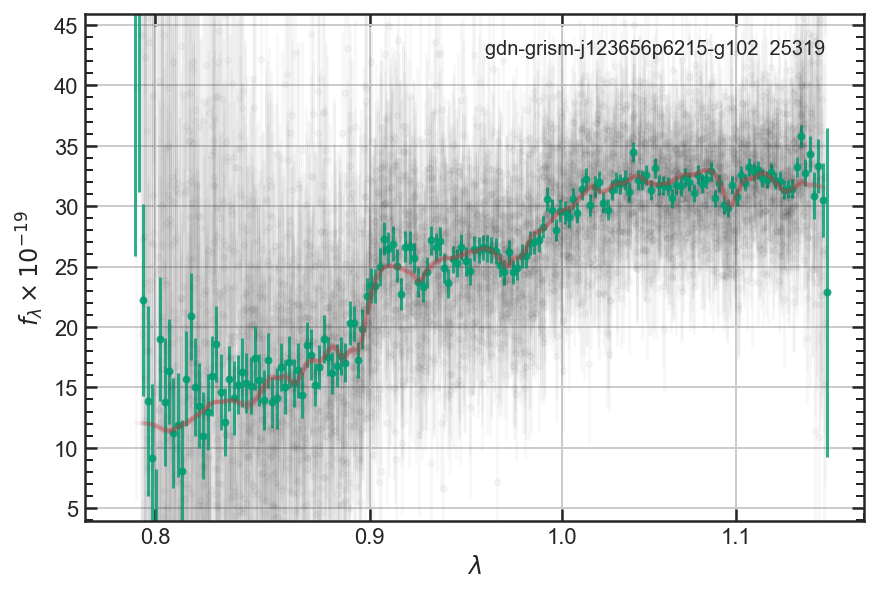

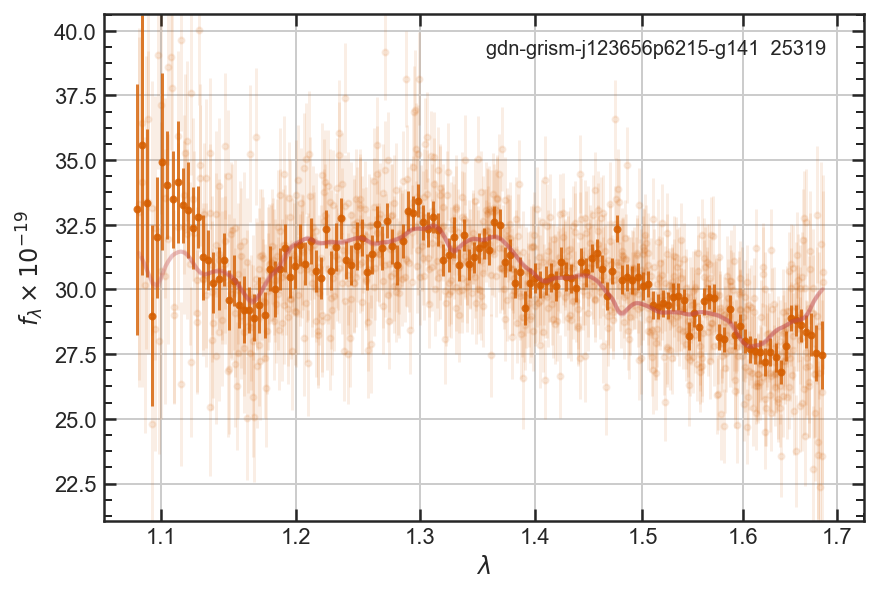

In [158]:
fig = mb_g102.oned_figure(tfit=tfit_g102) #, show_individual_templates=True)
fig2= mb_g141.oned_figure(tfit=tfit_g141)

In [366]:
tilt_temps = {}

entries = ['line SII','line Ha','line OI-6302','line HeI-5877',
           'line OIII','line Hb','line OIII-4363','line Hg','line Hd','line NeIII-3867','line OII']

for k in args['t1']:
#     if k[:4] == 'line':
    if k in entries:
        tilt_temps[k] = args['t1'][k]


sp.params['dust2'] = bfd
sp.params['logzsol'] = np.log10(bfm)

time, sfr, tmax = convert_sfh(get_agebins(bfa, binnum = 6), [bfm1, bfm2, bfm3, bfm4, bfm5, bfm6], maxage = bfa*1E9)

sp.set_tabular_sfh(time,sfr) 

wave, flux = sp.get_spectrum(tage = bfa, peraa = True)



tilt_temps['fsps_model_slope'] = SpectrumTemplate(wave=wave, flux=flux*(wave-wave0)/wave0)
tilt_temps['fsps_model'] = SpectrumTemplate(wave, flux)

g102_fit = mb_g102.template_at_z(bfz, templates=tilt_temps, fitter='lstsq')
g141_fit = mb_g141.template_at_z(bfz, templates=tilt_temps, fitter='lstsq')

Pmfl = Gs.Sim_phot_mult(testfit['line1d'].wave,testfit['line1d'].flux)
Pmfl2 = Gs.Sim_phot_mult(g102_fit['line1d'].wave,g102_fit['line1d'].flux  + g141_fit['line1d'].flux)
Pmfl3 = Gs.Sim_phot_mult(wave * (1 + bfz), flux)

scl = Scale_model(Gs.Pflx, Gs.Perr, Pmfl)
scl2 = Scale_model(Gs.Pflx, Gs.Perr, Pmfl2)
scl3 = Scale_model(Gs.Pflx, Gs.Perr, Pmfl3)

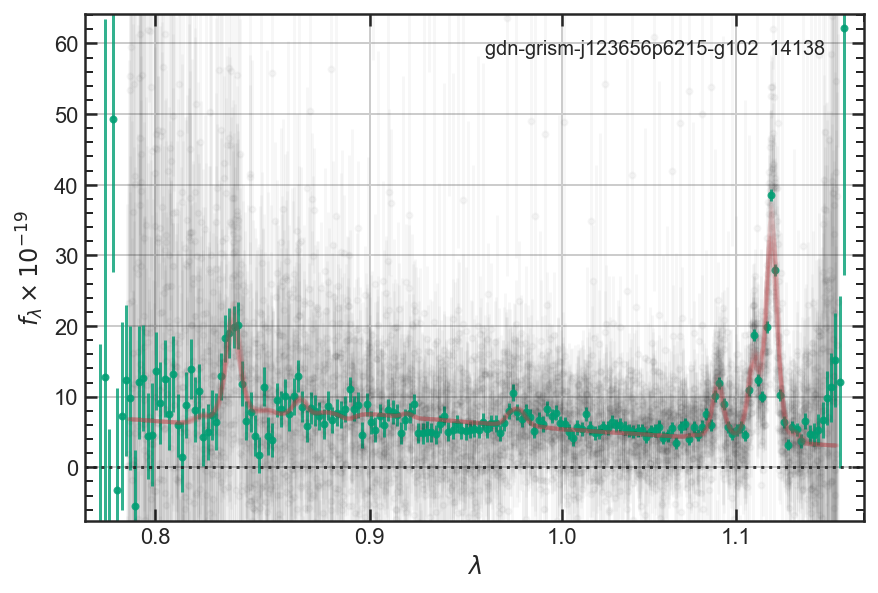

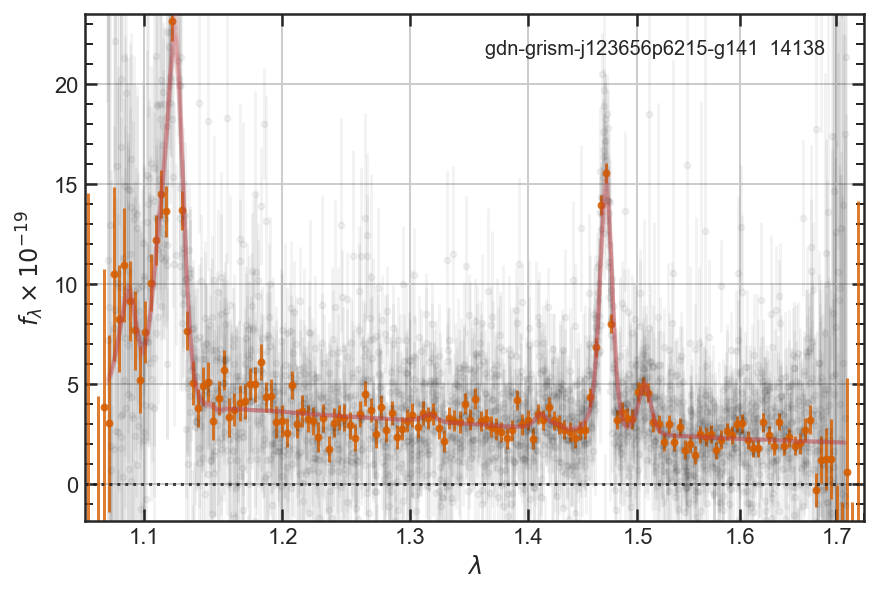

In [367]:
fig = mb_g102.oned_figure(tfit=g102_fit) #, show_individual_templates=True)
fig2= mb_g141.oned_figure(tfit=g141_fit)

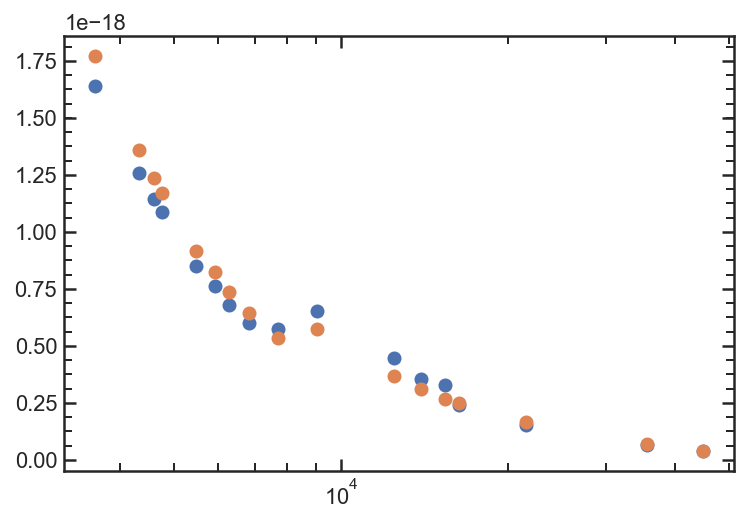

In [227]:
# plt.plot(Gs.Pwv, Gs.Pflx,'o')

plt.plot(Gs.Pwv, scl*Pmfl,'o')
# plt.plot(Gs.Pwv, scl2*Pmfl2,'o')
plt.plot(Gs.Pwv, scl3*Pmfl3,'o')

plt.xscale('log')

(8000, 17000)

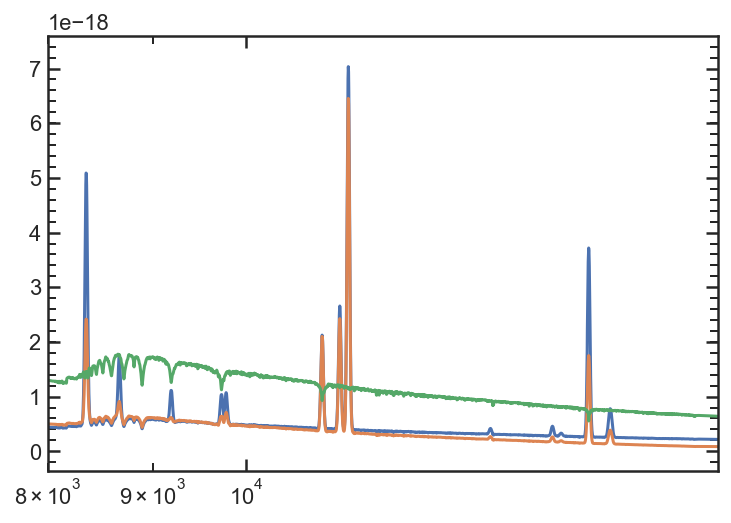

In [223]:
plt.plot(testfit['line1d'].wave,testfit['line1d'].flux*scl)
plt.plot(g102_fit['line1d'].wave,(g102_fit['line1d'].flux  + g141_fit['line1d'].flux)*scl2)
plt.plot(wave * (1 + bfz), flux*scl3)
plt.xscale('log')
plt.xlim(8000, 17000)

(0, 5e-18)

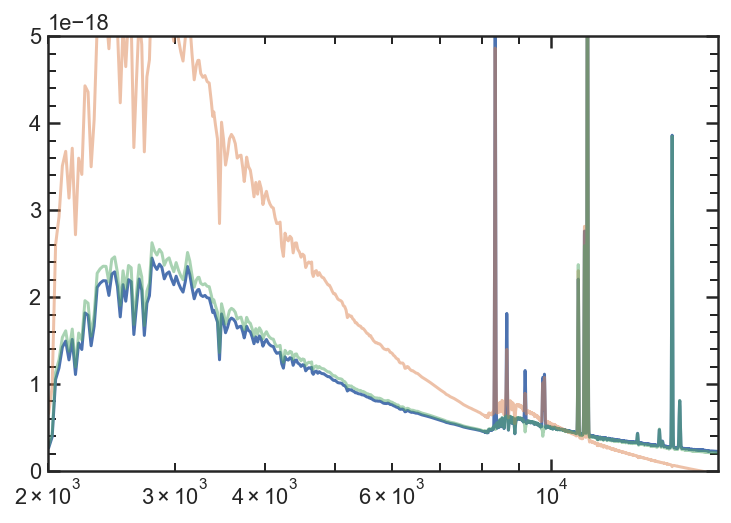

In [368]:
plt.plot(testfit['line1d'].wave,testfit['line1d'].flux)
plt.plot(g102_fit['line1d'].wave,(g102_fit['line1d'].flux), alpha = 0.5)
plt.plot(g141_fit['line1d'].wave,(g141_fit['line1d'].flux), alpha = 0.5)

# plt.plot(tilt_temps['fsps_model'].wave*(1+bfz),g102_notilt*3.7)

# plt.plot(tilt_temps['fsps_model'].wave * (1 + bfz), tilt_temps['fsps_model'].flux*scl3)
plt.xscale('log')
# plt.yscale('log')

plt.xlim(2000, 17000)
plt.ylim(0, 0.5E-17)

In [432]:
def spec_construct(g102_fit,g141_fit, wave0 = 4000, ):
    flat = np.ones_like(g141_fit['cont1d'].wave)
    slope = flat*(g141_fit['cont1d'].wave/(1+bfz)-wave0)/wave0
    tilt = flat * g141_fit['cfit']['fsps_model'][0]+slope * g141_fit['cfit']['fsps_model_slope'][0]
    untilted_continuum = g141_fit['cont1d'].flux / tilt

    line_g141 = (g141_fit['line1d'].flux - g141_fit['cont1d'].flux)/g141_fit['cont1d'].flux
    untilted_line_g141 = untilted_continuum*(1+line_g141)


    flat = np.ones_like(g102_fit['cont1d'].wave)
    slope = flat*(g102_fit['cont1d'].wave/(1+bfz)-wave0)/wave0
    tilt = flat * g102_fit['cfit']['fsps_model'][0]+slope * g102_fit['cfit']['fsps_model_slope'][0]
    untilted_continuum = g102_fit['cont1d'].flux / tilt

    line_g102 = (g102_fit['line1d'].flux - g102_fit['cont1d'].flux)/g102_fit['cont1d'].flux
    untilted_line_g102 = untilted_continuum*(1+line_g102)

    FL = np.append(untilted_line_g102[g102_fit['cont1d'].wave <= 12000],untilted_line_g141[g102_fit['cont1d'].wave > 12000])
    return g102_fit['cont1d'].wave, FL

(3000, 17000)

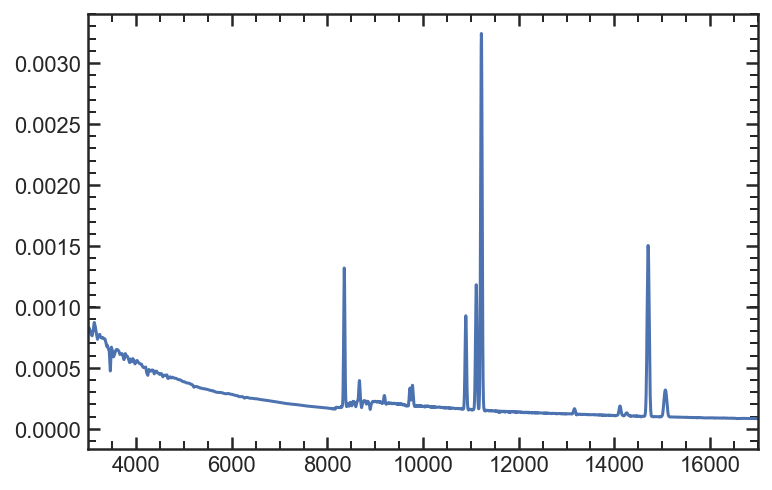

In [434]:
wv_obs, flx = spec_construct(g102_fit,g141_fit)
plt.plot(wv_obs,flx)
plt.xlim(3000, 17000)


(8000, 17000)

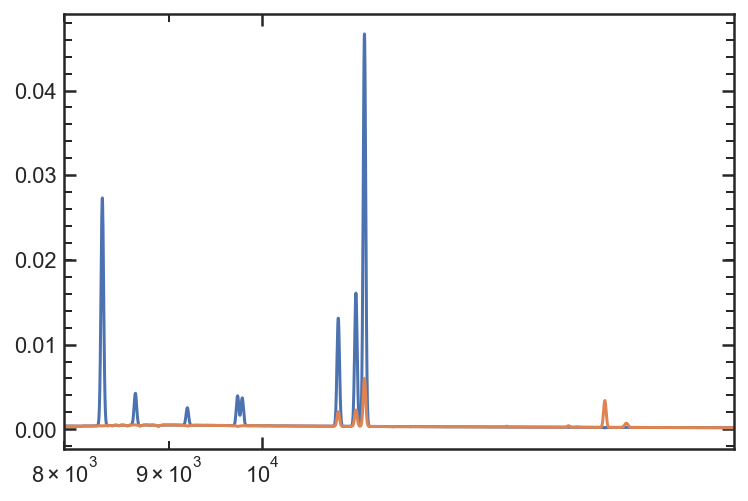

In [340]:
plt.plot(tilt_temps['fsps_model'].wave*(1+bfz),g102_notilt)
plt.plot(tilt_temps['fsps_model'].wave*(1+bfz),g141_notilt)
plt.xscale('log')
# plt.yscale('log')

plt.xlim(8000, 17000)
# plt.ylim(0, 0.5E-17)

In [332]:
np.log10(g102_correct), np.log10(g141_correct)

(15.457015509358747, 14.594761764761962)

In [27]:
#!/home/vestrada78840/miniconda3/envs/astroconda/bin/python
from spec_id import *
import fsps
import numpy as np
from glob import glob
import pandas as pd
import os
import sys
from grizli import multifit
from grizli.utils import SpectrumTemplate
hpath = os.environ['HOME'] + '/'
  
field = 'GND'
galaxy = 21156
specz = 1.25
    

#############multifit###############
args = np.load('../data/multifit_data/fit_args.npy')[0]
mb = multifit.MultiBeam('../data/multifit_data/gdn-grism-j123656p6215_25319.beams.fits',**args)

grism_beams = {}
for g in mb.PA:
    grism_beams[g.lower()] = []
    for pa in mb.PA[g]:
        for i in mb.PA[g][pa]:
            grism_beams[g.lower()].append(mb.beams[i])

mb_g102 = multifit.MultiBeam(grism_beams['g102'], fcontam=mb.fcontam, 
                             min_sens=mb.min_sens, min_mask=mb.min_mask, 
                             group_name=mb.group_name+'-g102')
# bug, will be fixed ~today to not have to do this in the future
for b in mb_g102.beams:
    if hasattr(b, 'xp'):
        delattr(b, 'xp')
mb_g102.initialize_masked_arrays()

mb_g141 = multifit.MultiBeam(grism_beams['g141'], fcontam=mb.fcontam, 
                             min_sens=mb.min_sens, min_mask=mb.min_mask, 
                             group_name=mb.group_name+'-g141')
# bug, will be fixed ~today to not have to do this in the future
for b in mb_g141.beams:
    if hasattr(b, 'xp'):
        delattr(b, 'xp')
mb_g141.initialize_masked_arrays()

tilt_temps = {}
wave0 = 4000
####################################
agelim = Oldest_galaxy(specz)
zscale = 0.035 * (1 + specz)

def Galfit_prior(u):
    m = Gaussian_prior(u[0], [0.002,0.03], 0.019, 0.08)/ 0.019
    a = (agelim - 1)* u[1] + 1

    tsamp = np.array([u[2],u[3],u[4],u[5],u[6],u[7],u[8], u[9], u[10],u[11]])
    taus = stats.t.ppf( q = tsamp, loc = 0, scale = 0.3, df =2.)
    m1, m2, m3, m4, m5, m6, m7, m8, m9, m10 = logsfr_ratios_to_masses(logmass = 0, logsfr_ratios = taus, agebins = get_agebins(a))
  
    z = stats.norm.ppf(u[12],loc = specz, scale = zscale)
    
    d = log_10_prior(u[13],[1E-3,2])

    ba = log_10_prior(u[14], [0.1,10])
    ra = log_10_prior(u[15], [0.1,10])
   
    return [m, a, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, z, d, ba, ra]

#########define fsps#########
sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = 0, sfh = 3, dust_type = 1)

###########gen spec##########
# Gs = Gen_spec(field, galaxy, 1, phot_errterm = 0.04, irac_err = 0.08) 
Gs = Gen_spec(field, galaxy, 1, phot_errterm = 0.0, irac_err = 0.0) 

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3553: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3558: RuntimeWarning: invalid value encountered in sqrt
  contam_mask = ((self.contam*np.sqrt(self.ivar) > contam_sn_mask[0]) &
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3559: RuntimeWarning: invalid value encountered in sqrt
  (self.model*np.sqrt(self.ivar) < contam_sn_mask[1]))


1 ib3721xiq_flt.fits G141
2 ib3721xmq_flt.fits G141
3 ib3721xyq_flt.fits G141
4 ib3721y2q_flt.fits G141


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3510: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


5 ib3725dyq_flt.fits G141
6 ib3725e2q_flt.fits G141
7 ib3725eeq_flt.fits G141
8 ib3725eiq_flt.fits G141
9 icat21cfq_flt.fits G102
10 icat21coq_flt.fits G102
11 icat21dgq_flt.fits G102
12 icat21dlq_flt.fits G102
13 icat25hcq_flt.fits G102
14 icat25hiq_flt.fits G102
15 icat25icq_flt.fits G102
16 icat25iiq_flt.fits G102
17 icxt51jvq_flt.fits G102
18 icxt51jwq_flt.fits G102
19 icxt51jzq_flt.fits G102
20 icxt51k1q_flt.fits G102
21 icxt52i0q_flt.fits G102
22 icxt52i1q_flt.fits G102
23 icxt52i4q_flt.fits G102
24 icxt52i6q_flt.fits G102
25 icxt53i9q_flt.fits G102
26 icxt53iaq_flt.fits G102
27 icxt53idq_flt.fits G102
28 icxt53ifq_flt.fits G102
29 icxt55krq_flt.fits G102
30 icxt55ksq_flt.fits G102
31 icxt55kvq_flt.fits G102
32 icxt55kxq_flt.fits G102
33 icxta4mdq_flt.fits G102
34 icxta4meq_flt.fits G102
35 icxta4mhq_flt.fits G102
36 icxta4mjq_flt.fits G102


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1433: RuntimeWarning: divide by zero encountered in true_divide
  beam.ivarf = 1./(1/beam.ivarf + (sys_err*beam.scif)**2)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1573: RuntimeWarning: invalid value encountered in sqrt
  self.sivarf = np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1578: RuntimeWarning: invalid value encountered in sqrt
  self.weightf = np.exp(-(self.fcontam*np.abs(self.contamf)*np.sqrt(self.ivarf)))
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:557: RuntimeWarning: divide by zero encountered in true_divide
  se

In [39]:
# m, a, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, z, d, ba, ra = Galfit_prior(np.random.rand(16))
m, a, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, z, d, ba, ra = bfm, \
    bfa, bfm1, bfm2, bfm3, bfm4, bfm5, bfm6, bfm7, bfm8, bfm9, bfm10, bfz, bfd, bfba, bfra
    
sp.params['dust2'] = d
sp.params['dust1'] = d
sp.params['logzsol'] = np.log10(m)

time, sfr, tmax = convert_sfh(get_agebins(a), [m1, m2, m3, m4, m5, m6, m7, m8, m9, m10], maxage = a*1E9)

sp.set_tabular_sfh(time,sfr) 

wave, flux = sp.get_spectrum(tage = a, peraa = True)

tilt_temps['fsps_model_slope'] = SpectrumTemplate(wave=wave, flux=flux*(wave-wave0)/wave0)
tilt_temps['fsps_model'] = SpectrumTemplate(wave, flux)

g102_fit = mb_g102.template_at_z(z, templates=tilt_temps, fitter='lstsq')
g141_fit = mb_g141.template_at_z(z, templates=tilt_temps, fitter='lstsq')

Pmfl = Gs.Sim_phot_mult(wave * (1 + z),flux)

scl = Scale_model(Gs.Pflx, Gs.Perr, Pmfl)

print(g102_fit['chi2']/mb_g102.DoF)
print(g141_fit['chi2']/mb_g141.DoF) 
print(np.sum((((Gs.Pflx - Pmfl*scl) / Gs.Perr)**2)) / (len(Gs.Perr)-1))

0.8686394683175176
1.0280470836116367
45.816299422749346


In [29]:
np.sqrt(10)

3.1622776601683795

In [32]:
g102_fit.keys()

odict_keys(['cont1d', 'line1d', 'cfit', 'coeffs', 'chi2', 'covar', 'z', 'templates'])

In [36]:
mb_g102.DoF

57039

# priors

In [74]:
morph_db = pd.read_pickle('../dataframes/fitdb/fullfitdb.pkl')

inout = []
for i in morph_db.index:
    for ii in range(len(morph_db.zgrism_hci[i])//2):
        if morph_db.zgrism_hci[i][2*ii] <= morph_db.zgrism[i] <= morph_db.zgrism_hci[i][2*ii+1]:
            if(morph_db.zgrism_hci[i][2*ii+1] - morph_db.zgrism_hci[i][2*ii]) /( 2 * (1 + morph_db.zgrism[i])) < 0.01:
                inout.append('i')
            else:
                inout.append('o')
        
morph_db['inout'] = inout
morph_db = morph_db.query('inout == "i" and n_f < 3 and Re < 20 and AGN == "-"')

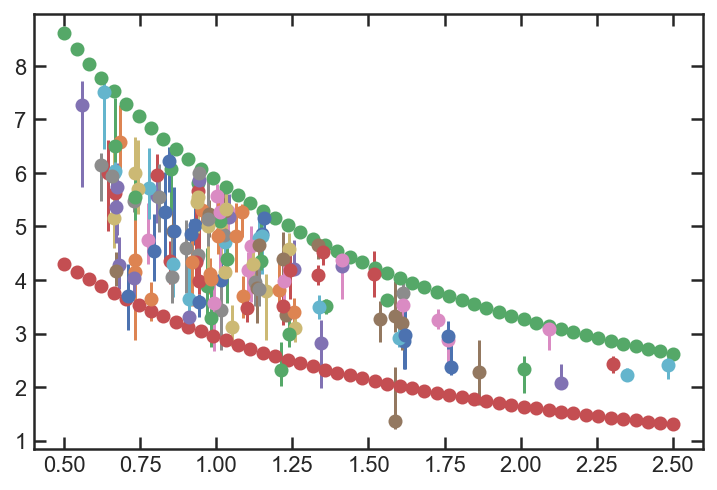

In [85]:
for i in morph_db.index:
    x,px = np.load('../data/posteriors/{}_{}_tabfit_Pa.npy'.format(morph_db.field[i], morph_db.id[i]))
    md, hdr, modal = Highest_density_region(px,x)
    plt.errorbar(morph_db.zgrism[i], md, [[md - hdr[0]], [hdr[1] - md]], fmt = 'o')
    
plt.plot(np.linspace(0.5,2.5), cosmo.age(np.linspace(0.5,2.5)).value)
plt.plot(np.linspace(0.5,2.5), cosmo.age(np.linspace(0.5,2.5)).value/2)

In [86]:
SFdb = pd.read_pickle('../Casey_data/SF_db_p1.pkl')

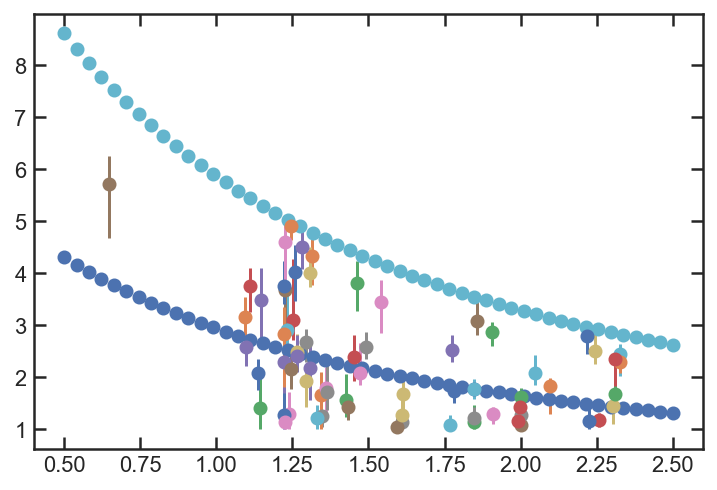

In [87]:
for i in SFdb.index:
    x,px = np.load('../Casey_data/posteriors/{}_{}_SFfit_Pa.npy'.format(SFdb.field[i], SFdb.id[i]))
    md, hdr, modal = Highest_density_region(px,x)
    plt.errorbar(SFdb.zgrism[i], md, [[md - hdr[0]], [hdr[1] - md]], fmt = 'o')
    
plt.plot(np.linspace(0.5,2.5), cosmo.age(np.linspace(0.5,2.5)).value)
plt.plot(np.linspace(0.5,2.5), cosmo.age(np.linspace(0.5,2.5)).value/2)

In [88]:
mb_g102.DoF, mb_g141.DoF, len(Gs.Pflx)-1

(58126, 36193, 16)

In [89]:
Npho = len(Gs.Pflx)-1
N102 = mb_g102.DoF
N141 = mb_g141.DoF

In [91]:
N102 / Npho, N102 / N141

(3632.875, 1.60600116044539)